In [3]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from scipy.signal import correlate
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import matplotlib.patches as patches
import torch
import copy
from scipy.signal import find_peaks
from simu_PSF_polarMFM import *

In [5]:
from extract_experimental_psf import *

# Calibration with widefield

## Finding the radius of the bead

In [6]:
path_z_stack = 'Z:\\DATA\\PolMFM_SilicaBeads_SLB_NR\\widefield\\001_WF_Zstack_100nmstep_560nm\\SilicaBead\\images\\RAW_DATA\\AVG_image_Pos0.ome.tif'

In [8]:
z_stack = []
with Image.open(path_z_stack) as img:
    for i in range(img.n_frames):
        img.seek(i)
        z_stack.append(np.array(img))
z_stack = np.array(z_stack)

### Choose the bead to analyze

In [9]:
box = [[226,265],[129,166]]
#box = [[270,318],[120,172]]

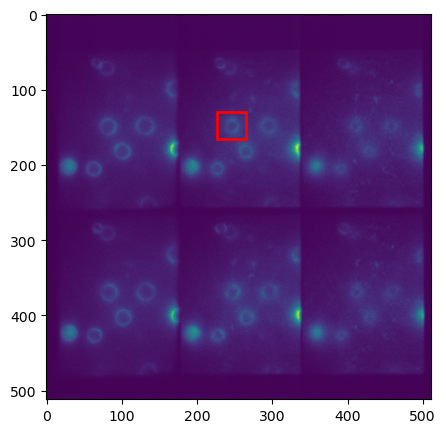

In [10]:
plt.rcParams['figure.figsize'] = [15,5]
fig, ax = plt.subplots()
ax.imshow(z_stack[0])
rect = patches.Rectangle((box[0][0], box[1][0]), box[0][1]-box[0][0], box[1][1]-box[1][0], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [11]:
test = z_stack[-8,box[1][0]:box[1][1],box[0][0]:box[0][1]]

In [12]:
def circle(shape, center, radius):
    x, y = torch.meshgrid(torch.arange(shape[0]), torch.arange(shape[1]))
    r = (((center[1]-x)**2+(center[0]-y)**2)).to(dtype=torch.float64)
    res = 1/(1000+(r-radius**2)**2)
    return res

In [13]:
def loss__(x,y,r, ref):
    return torch.sum((ref-circle(ref.shape, [x,y], r))**2)

In [14]:
def find_params(frame):
    ref = torch.tensor(frame)
    loss_ = []
    params = torch.tensor([20.,20.,3.], requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=0.5)
    for i in range(100):
        optimizer.zero_grad()  # Reset gradients
        loss = loss__(params[0], params[1], params[2], ref)
        loss_.append(loss.detach().numpy())
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
    return params.detach().numpy()

In [15]:
params = find_params(test)

C:\Users\LOCCO_Louise\anaconda3\envs\amaury_env\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


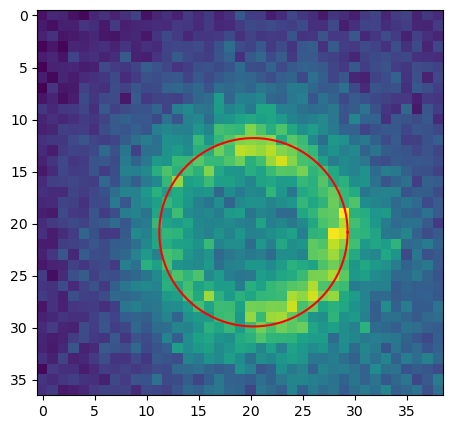

In [16]:
plt.imshow(test)
xx = params[0] + params[2]*np.cos(np.linspace(0,2*np.pi,100))
yy = params[1] + params[2]*np.sin(np.linspace(0,2*np.pi,100))
plt.plot(xx, yy, c='r')

In [17]:
radii = []
for index in range(z_stack.shape[0]-8):
    frame = z_stack[index,box[1][0]:box[1][1],box[0][0]:box[0][1]]
    parameters = find_params(frame)
    radii.append(copy.deepcopy(parameters[2]))

In [18]:
def square(x, x0, a, b):
    return a*((x-x0)**2)+b

In [19]:
p,  pcov = curve_fit(square, np.arange(np.argmax(radii)-5, np.argmax(radii)+6), radii[np.argmax(radii)-5: np.argmax(radii)+6])

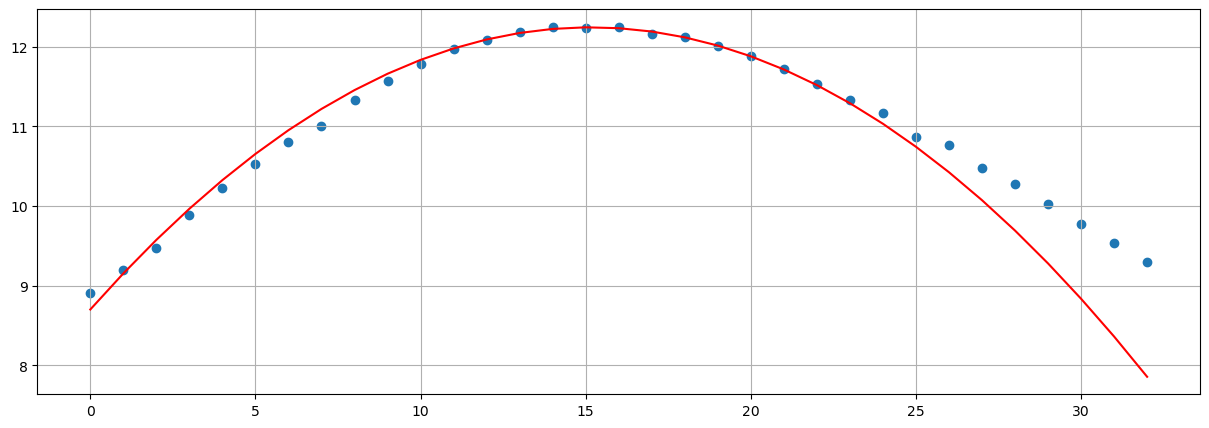

In [20]:
plt.scatter(np.arange(len(radii)), radii)
plt.plot(np.arange(len(radii)), square(np.arange(len(radii)), p[0], p[1], p[2]), c='r')
plt.grid()

In [21]:
x0 = p[0]
R = p[2]
print(R, x0*100/120)

12.244248959825525 12.621095914796546


In [22]:
def r__(R, z):
    if isinstance(z, torch.Tensor):
        return torch.sqrt(R**2-(R-z)**2)
    else:
        return np.sqrt(R**2-(R-z)**2)

In [23]:
def z__(R, r):
    return R-np.sqrt(R**2-r**2)

In [24]:
z_naive = np.arange(len(radii))*(100/120)
A_naive = R-z_naive[np.argmax(radii)]
z_naive = z_naive+A_naive

z1 = 0.65*z_naive
A1 = R-z1[np.argmax(radii)]
z1 = z1+A1

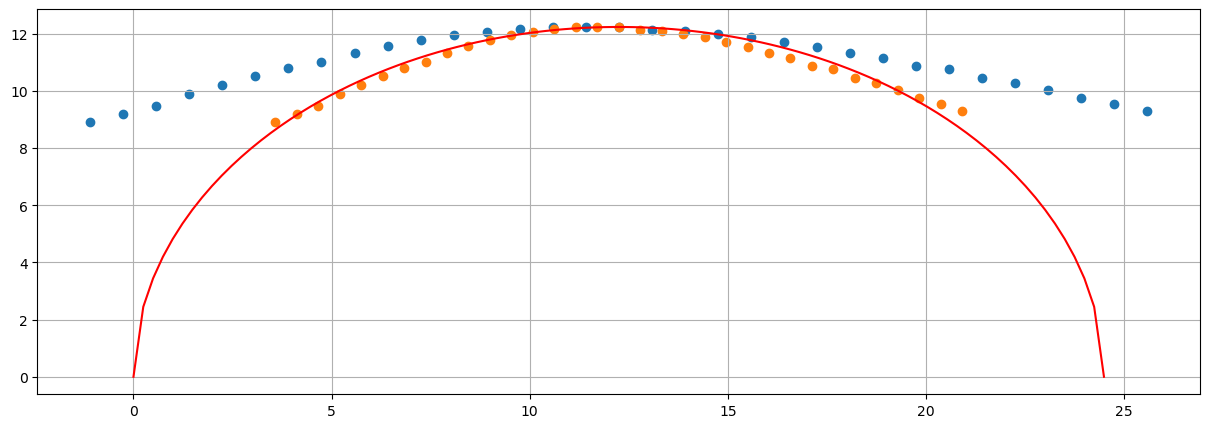

In [25]:
plt.scatter(z_naive, radii)
plt.scatter(z1, radii)
plt.plot(np.linspace(0,2*R,100), r__(R,np.linspace(0,2*R,100)), c='r')
plt.grid()

# center in x0 and just optimize on xi 

In [26]:
range_100 = torch.tensor(np.arange(len(radii))*100/120) # the range netween real focal in pixels

#### warning not intuitive : the real focal plane giving the max radius is not in zp = R but za=R

In [27]:
def loss_xi(xi, offset, radii_list, R_):
    zp = offset + range_100
    z_app = xi*zp

    epsilon = -(0.617)/(4*zp*0.120*n2)
    mm = np.sqrt(n1**2-n2**2)
    xi_univ = (n2/n1)*(1-epsilon-(mm/n1)*torch.sqrt(epsilon*(epsilon-2)))/(1-((n2/n1)**2)*epsilon*(2-epsilon))

    plt.scatter(z_app.detach().numpy(), radii_list.detach().numpy())
    plt.title(np.mean(xi.detach().numpy()))
    plt.plot(np.linspace(0,2*R_,100), r__(R,np.linspace(0,2*R_,100)), c='r')
    plt.show()
    rr = r__(R, z_app)
    return zp.detach().numpy(), z_app.detach().numpy(), torch.sum((rr-radii_list)**2) + torch.sum(torch.exp(-(z_app[1:]-z_app[:-1])*1)) #+ 100*torch.sum((xi-xi_univ)**2)

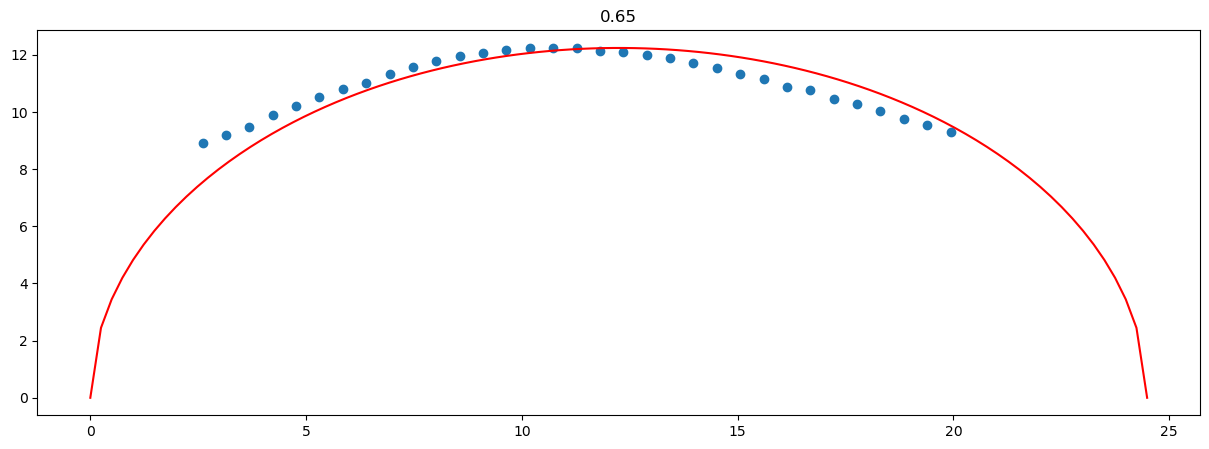

tensor(27.6360, dtype=torch.float64, grad_fn=<AddBackward0>)


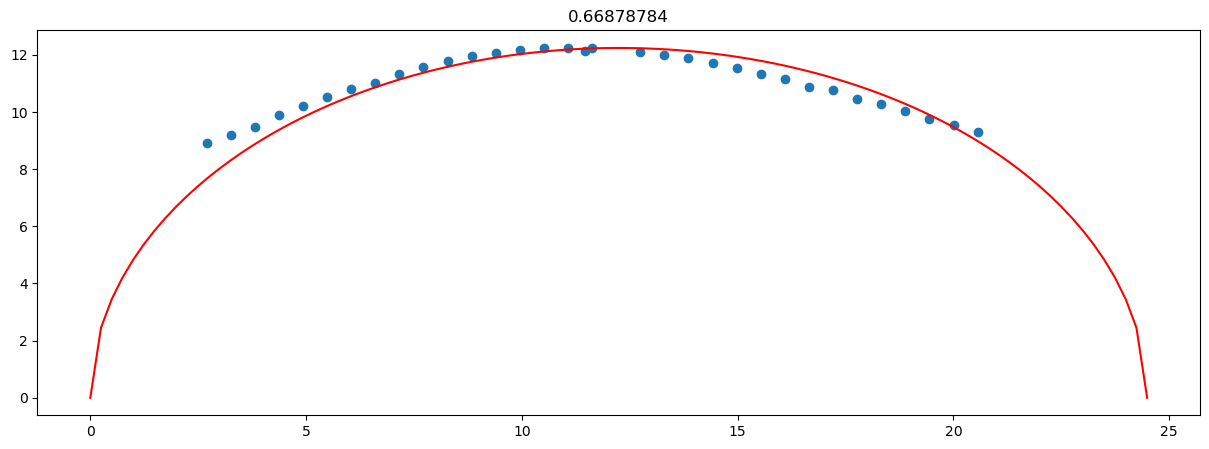

tensor(23.9827, dtype=torch.float64, grad_fn=<AddBackward0>)


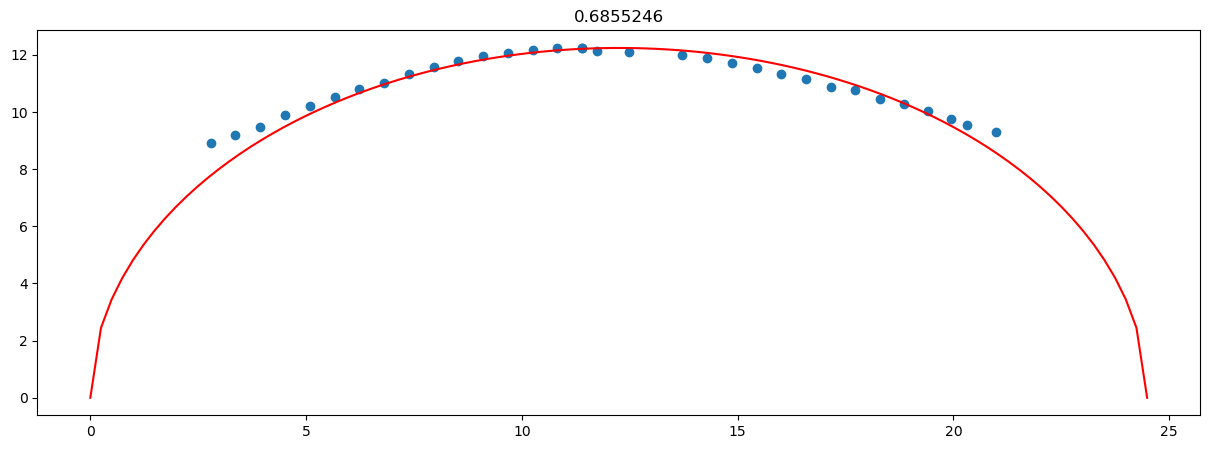

tensor(22.1580, dtype=torch.float64, grad_fn=<AddBackward0>)


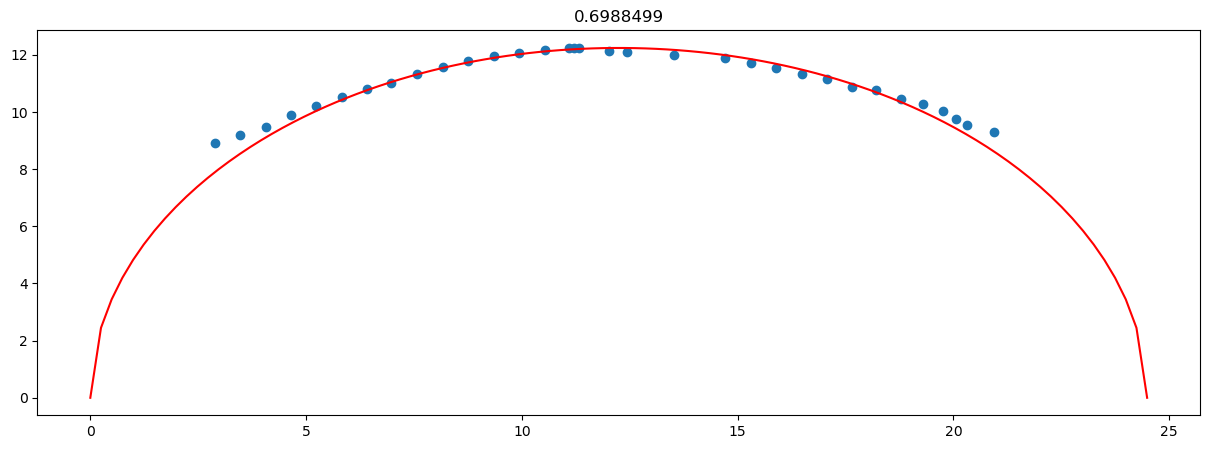

tensor(21.3730, dtype=torch.float64, grad_fn=<AddBackward0>)


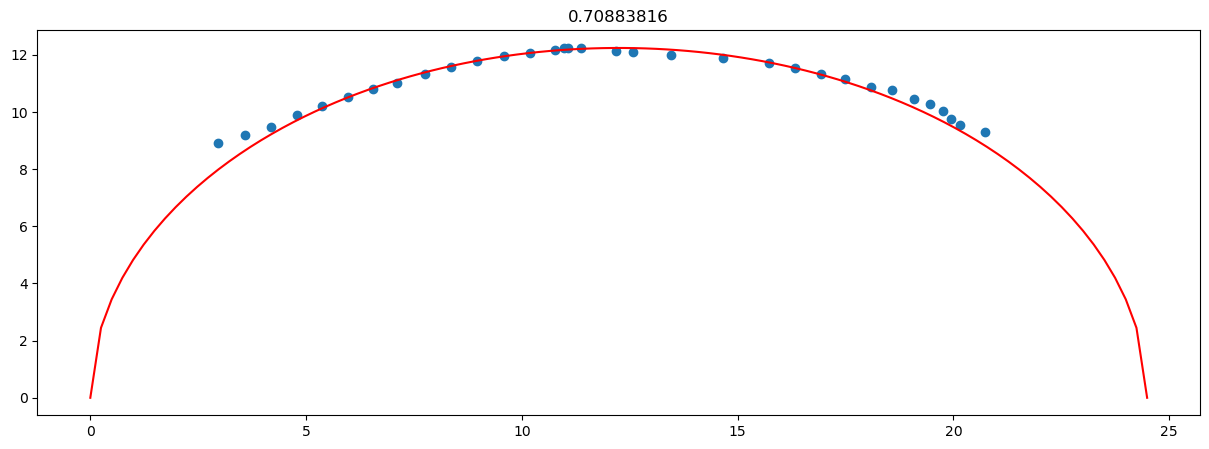

tensor(20.9929, dtype=torch.float64, grad_fn=<AddBackward0>)


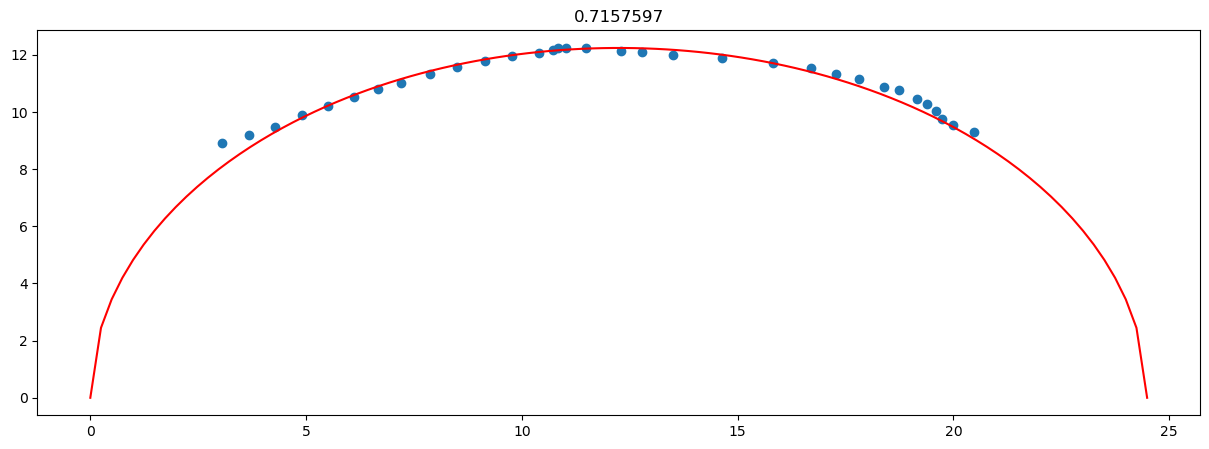

tensor(20.8484, dtype=torch.float64, grad_fn=<AddBackward0>)


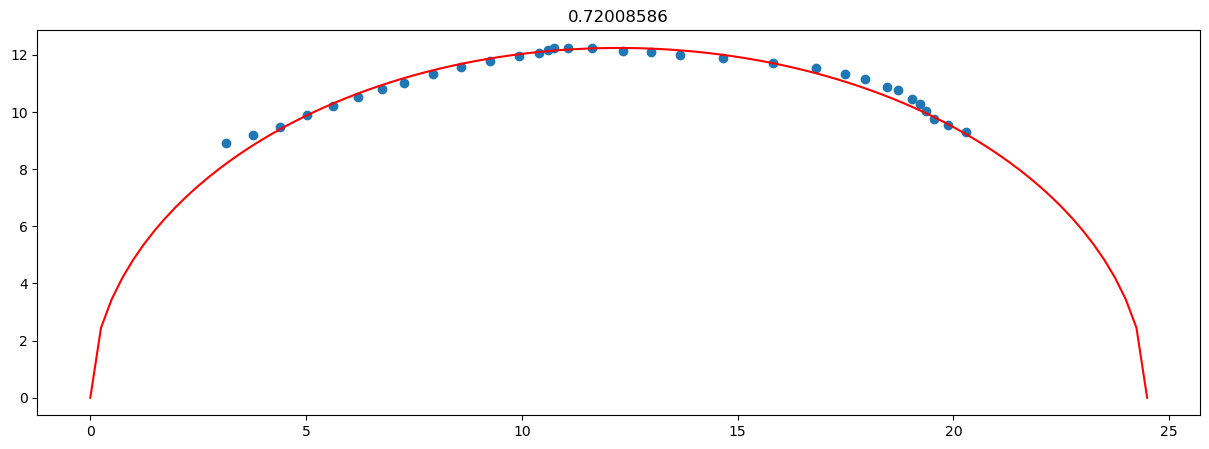

tensor(20.6927, dtype=torch.float64, grad_fn=<AddBackward0>)


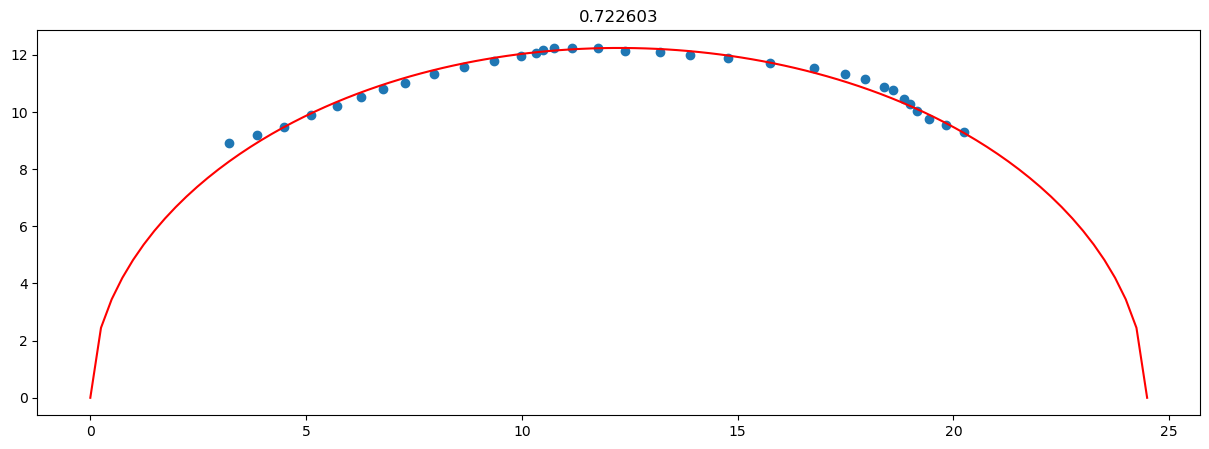

tensor(20.3947, dtype=torch.float64, grad_fn=<AddBackward0>)


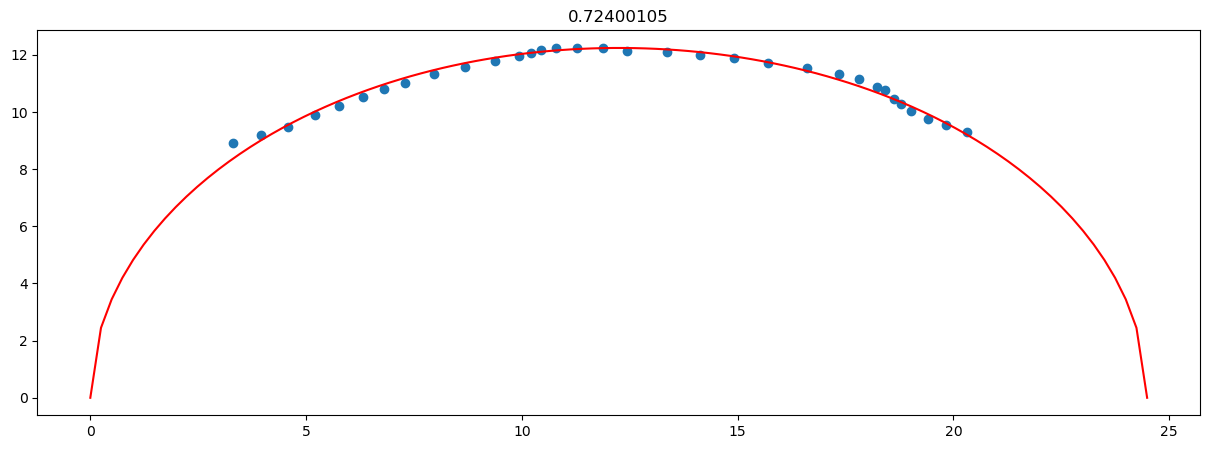

tensor(20.0399, dtype=torch.float64, grad_fn=<AddBackward0>)


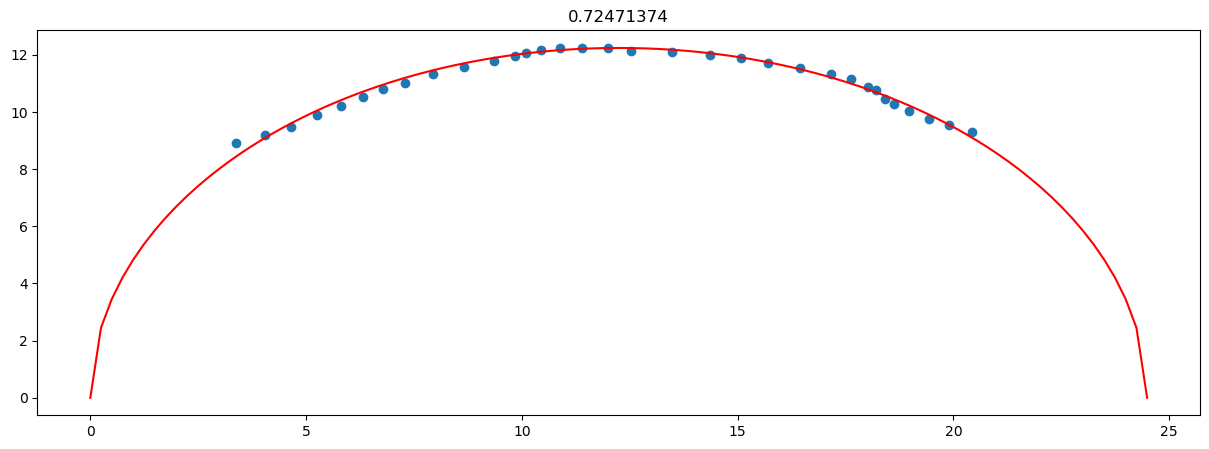

tensor(19.7604, dtype=torch.float64, grad_fn=<AddBackward0>)


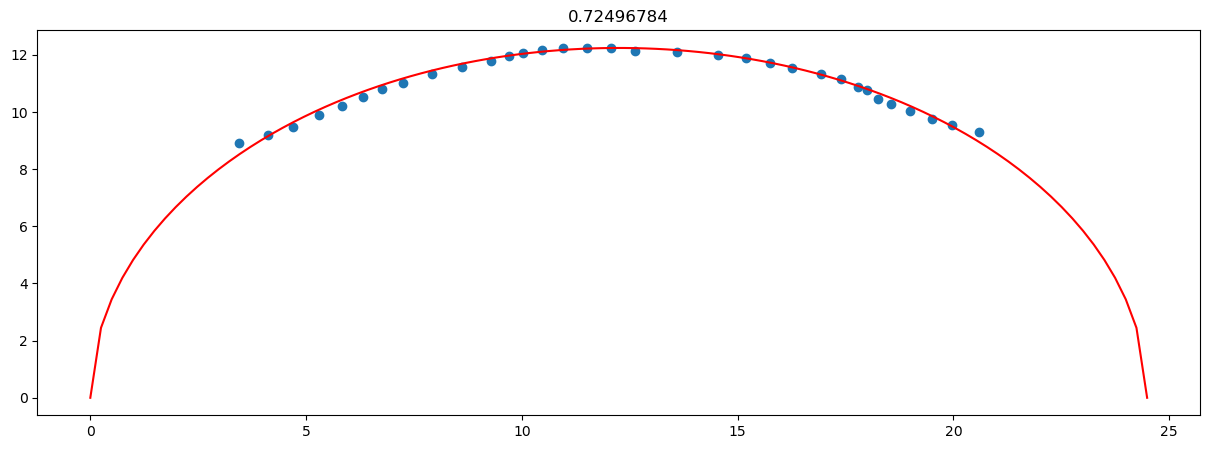

tensor(19.6278, dtype=torch.float64, grad_fn=<AddBackward0>)


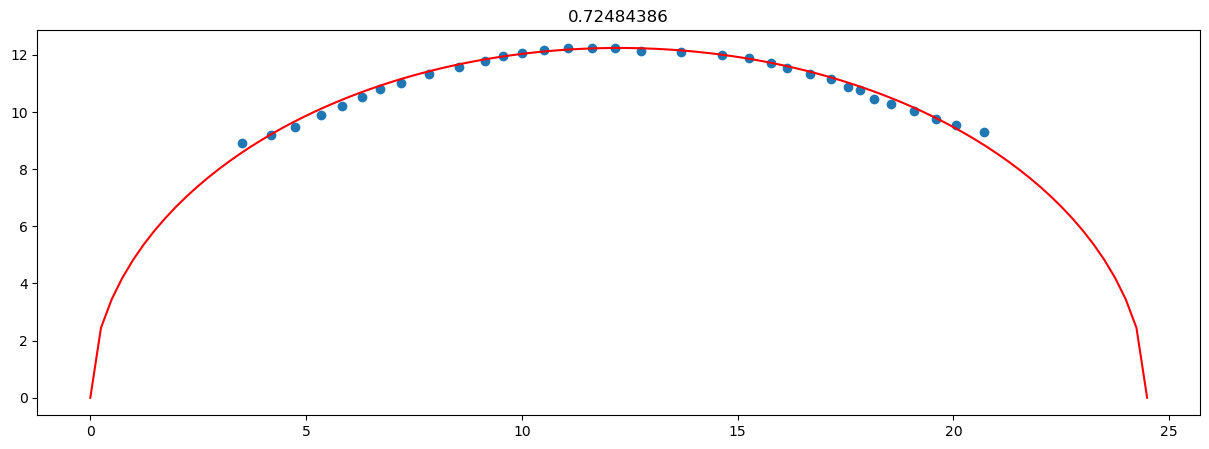

tensor(19.6219, dtype=torch.float64, grad_fn=<AddBackward0>)


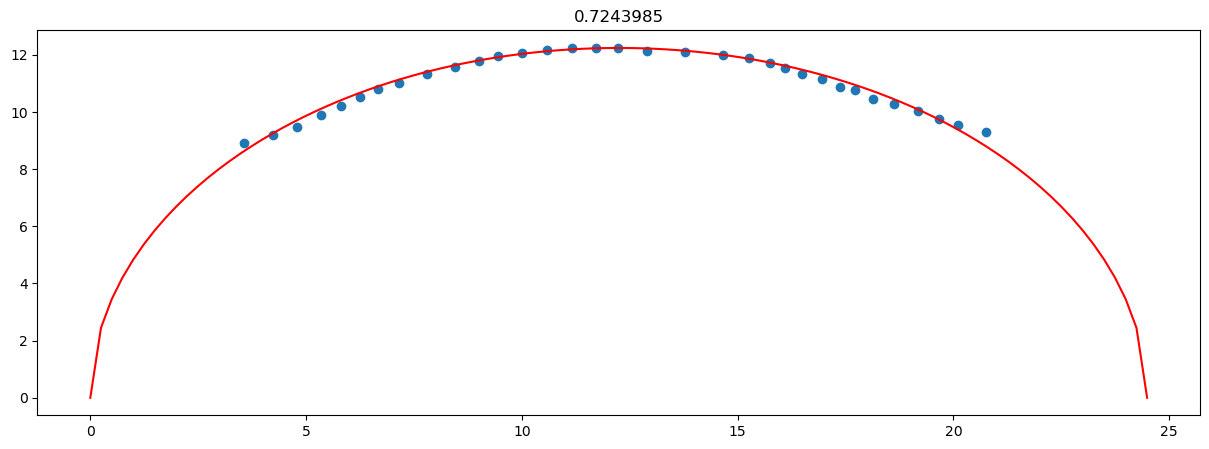

tensor(19.6585, dtype=torch.float64, grad_fn=<AddBackward0>)


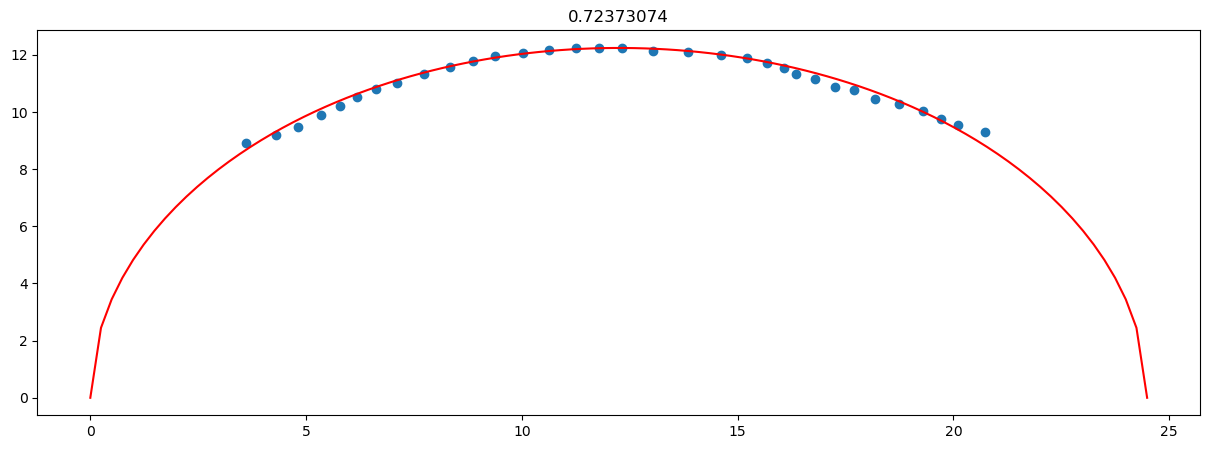

tensor(19.6736, dtype=torch.float64, grad_fn=<AddBackward0>)


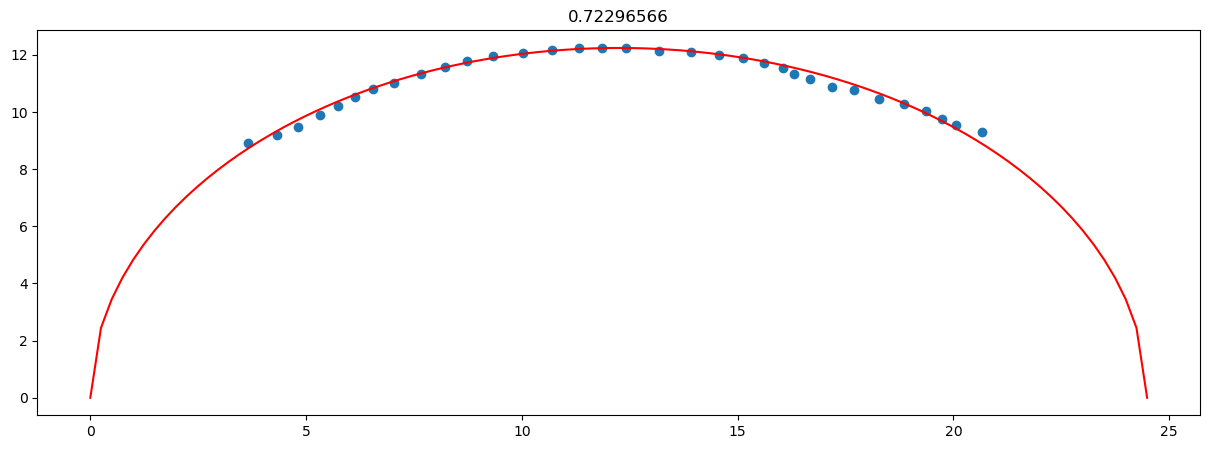

tensor(19.6548, dtype=torch.float64, grad_fn=<AddBackward0>)


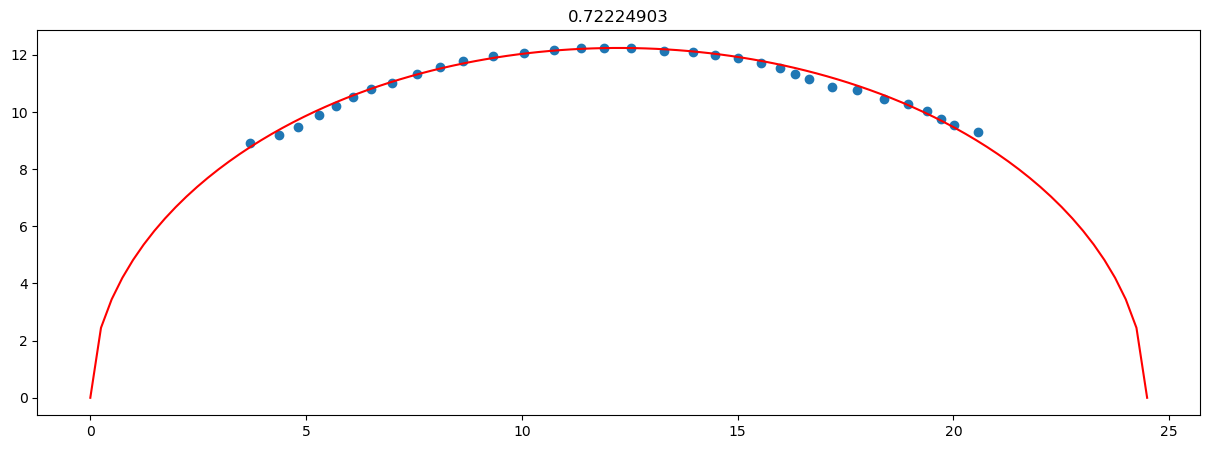

tensor(19.6248, dtype=torch.float64, grad_fn=<AddBackward0>)


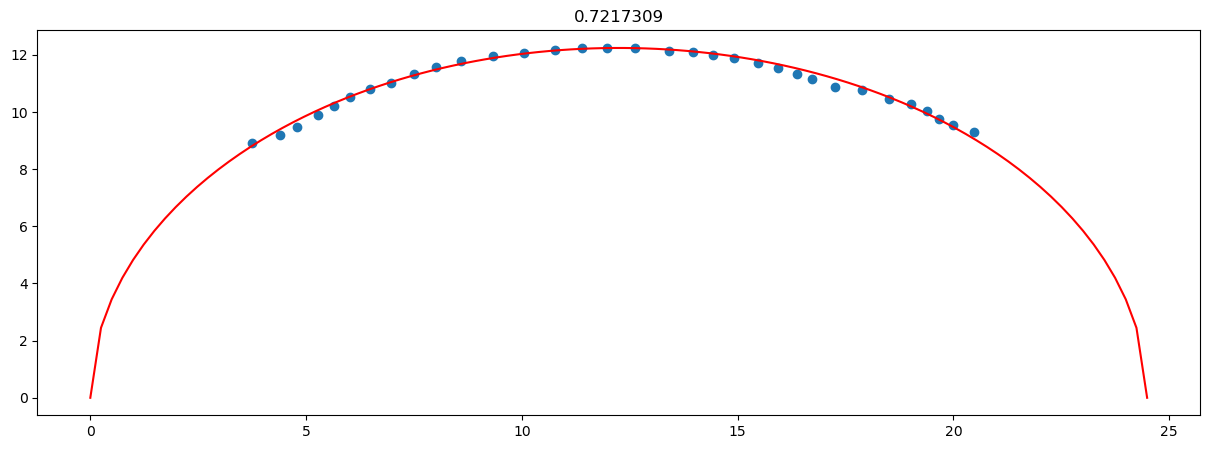

tensor(19.5961, dtype=torch.float64, grad_fn=<AddBackward0>)


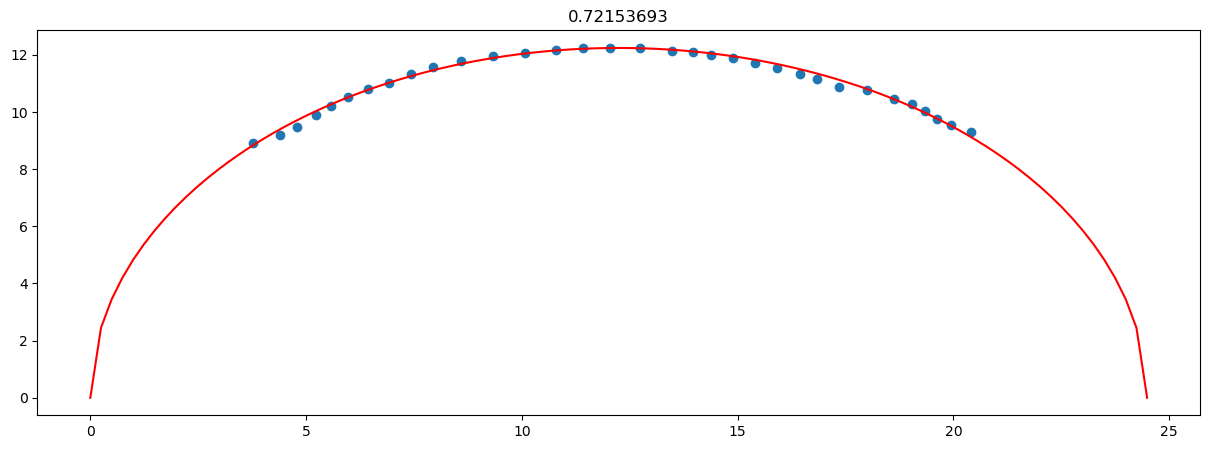

tensor(19.5566, dtype=torch.float64, grad_fn=<AddBackward0>)


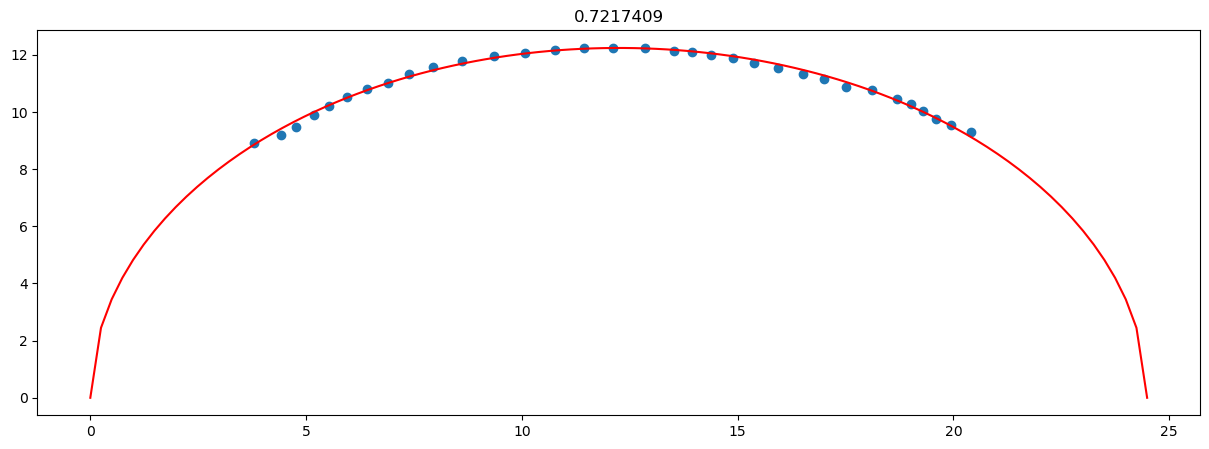

tensor(19.5014, dtype=torch.float64, grad_fn=<AddBackward0>)


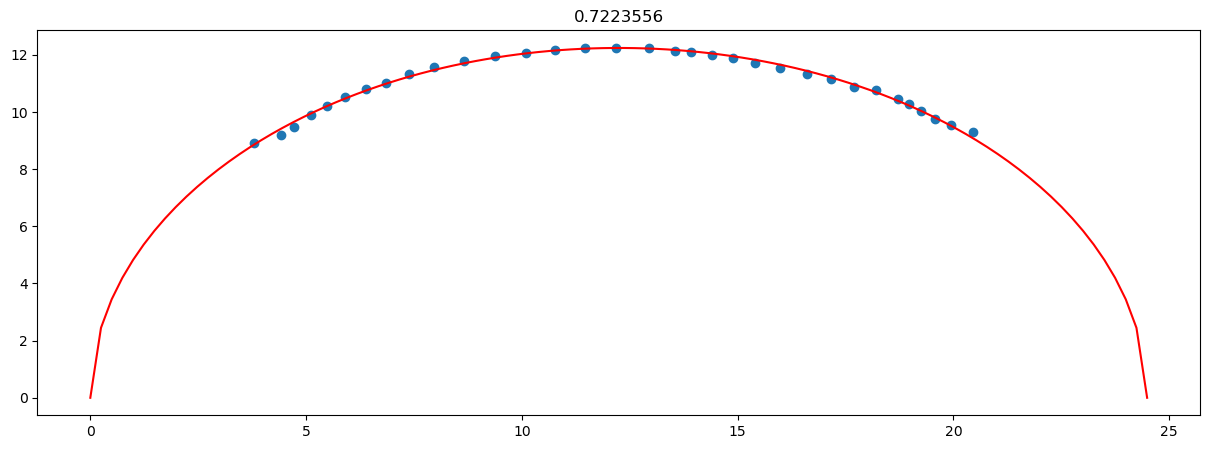

tensor(19.4417, dtype=torch.float64, grad_fn=<AddBackward0>)


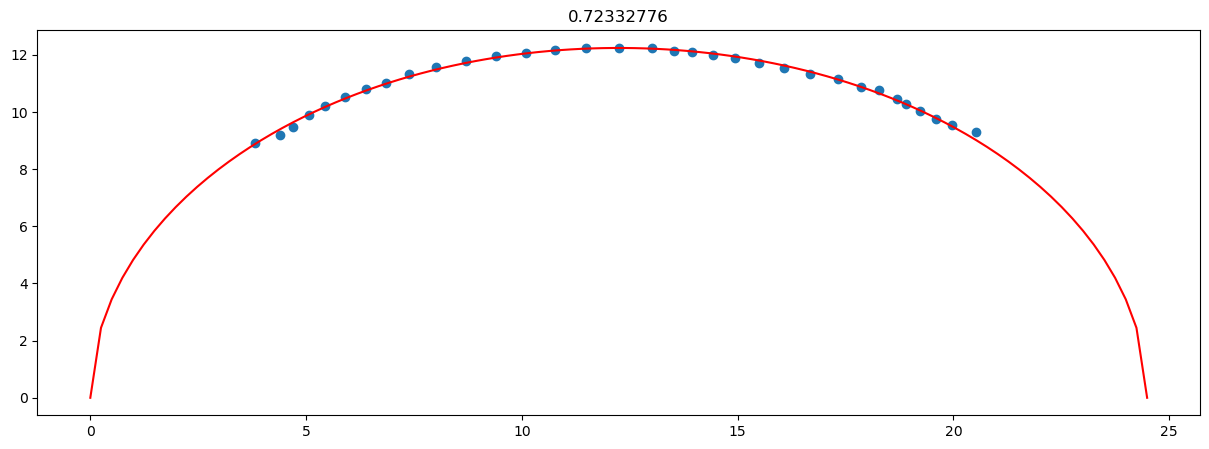

tensor(19.4012, dtype=torch.float64, grad_fn=<AddBackward0>)


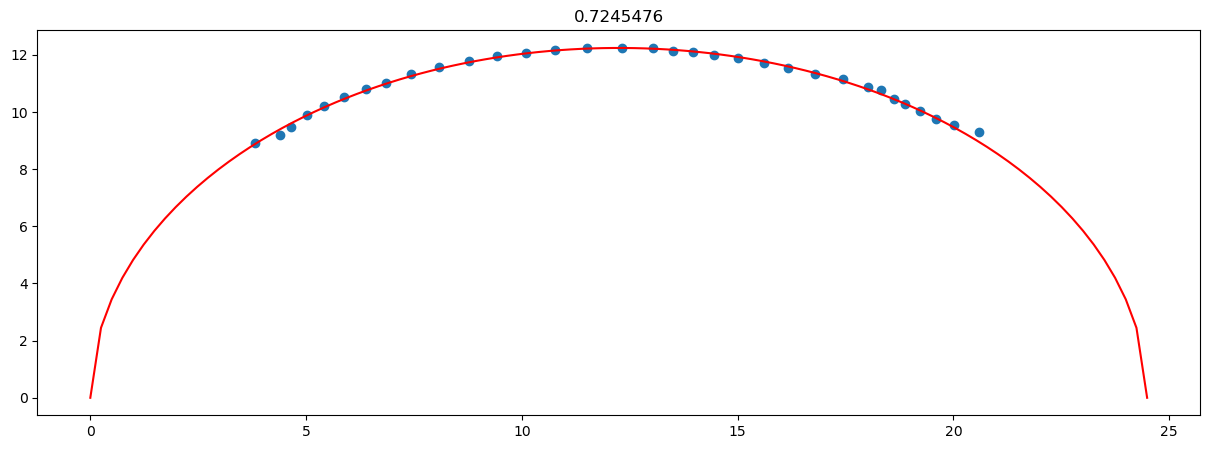

tensor(19.3953, dtype=torch.float64, grad_fn=<AddBackward0>)


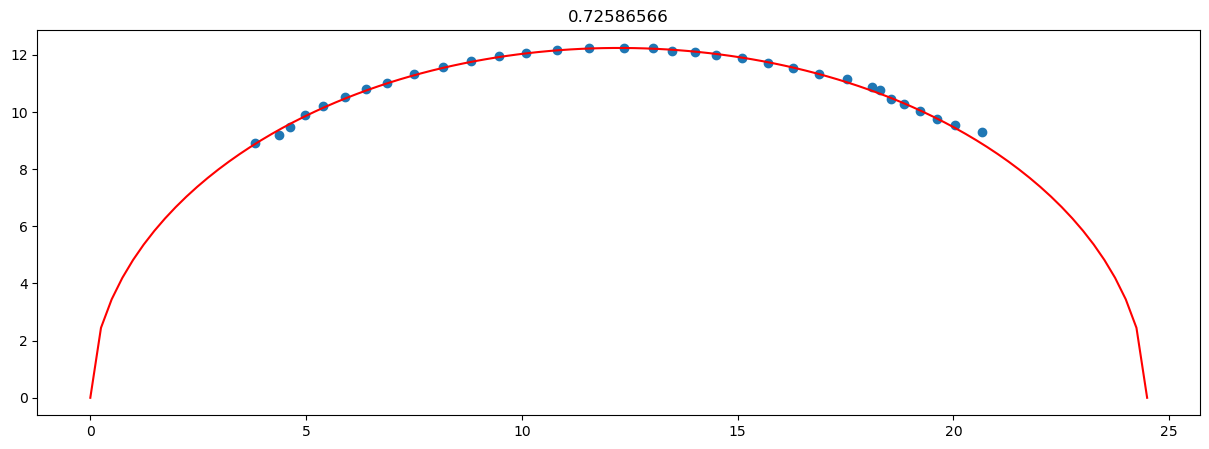

tensor(19.4065, dtype=torch.float64, grad_fn=<AddBackward0>)


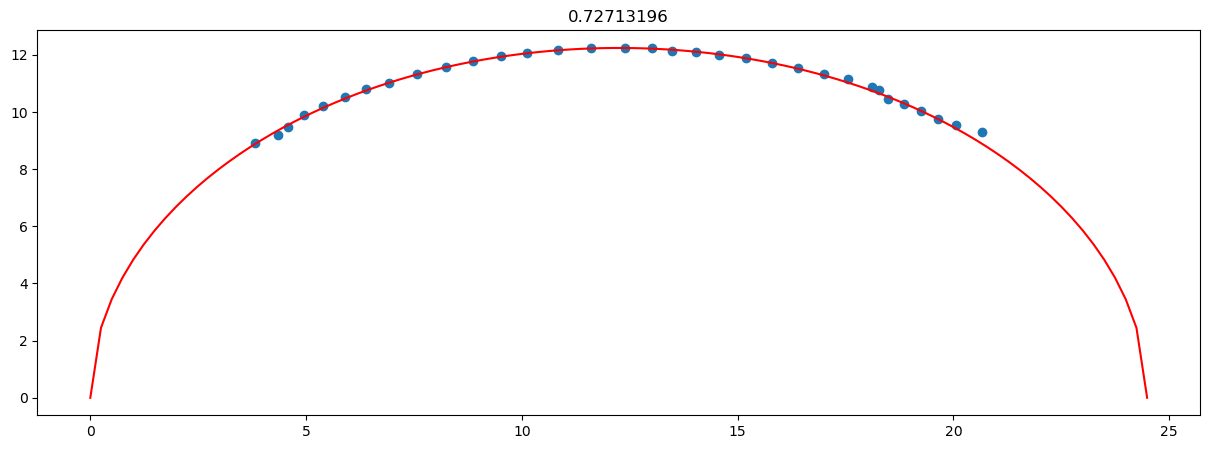

tensor(19.3971, dtype=torch.float64, grad_fn=<AddBackward0>)


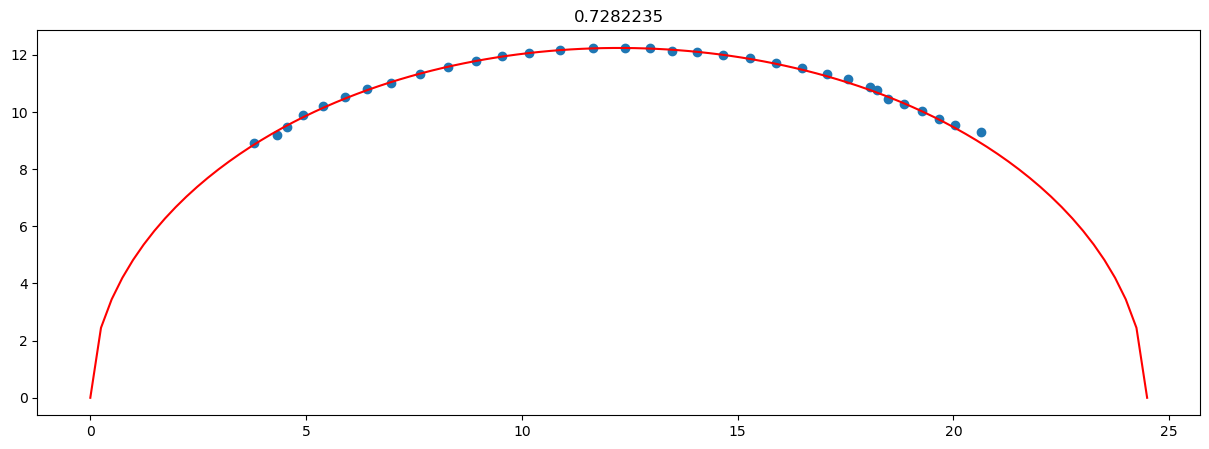

tensor(19.3556, dtype=torch.float64, grad_fn=<AddBackward0>)


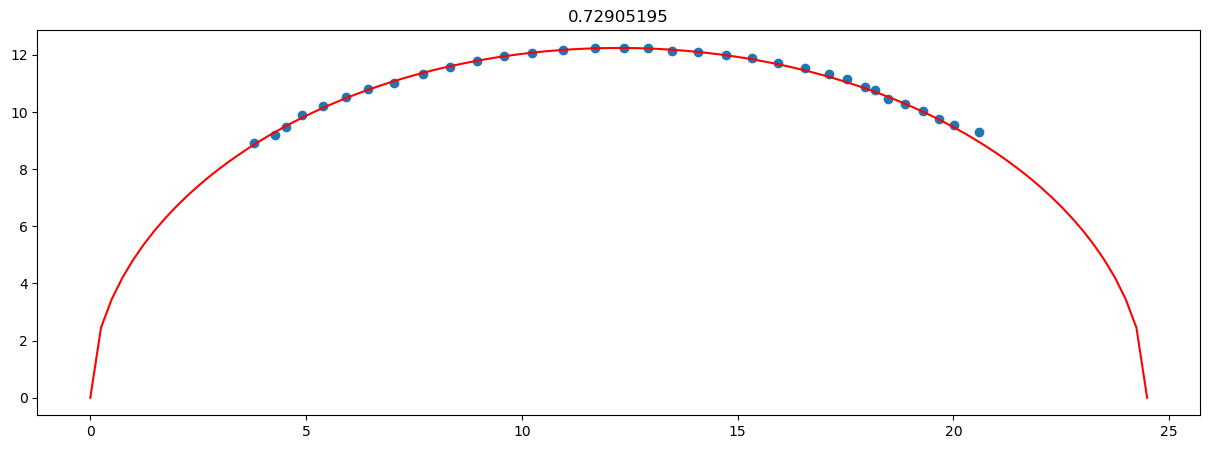

tensor(19.3068, dtype=torch.float64, grad_fn=<AddBackward0>)


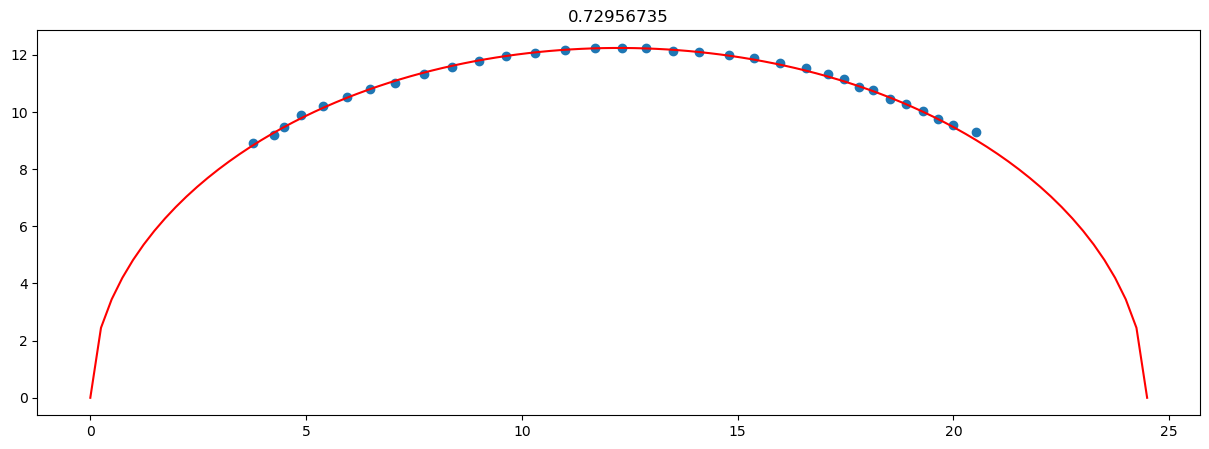

tensor(19.2750, dtype=torch.float64, grad_fn=<AddBackward0>)


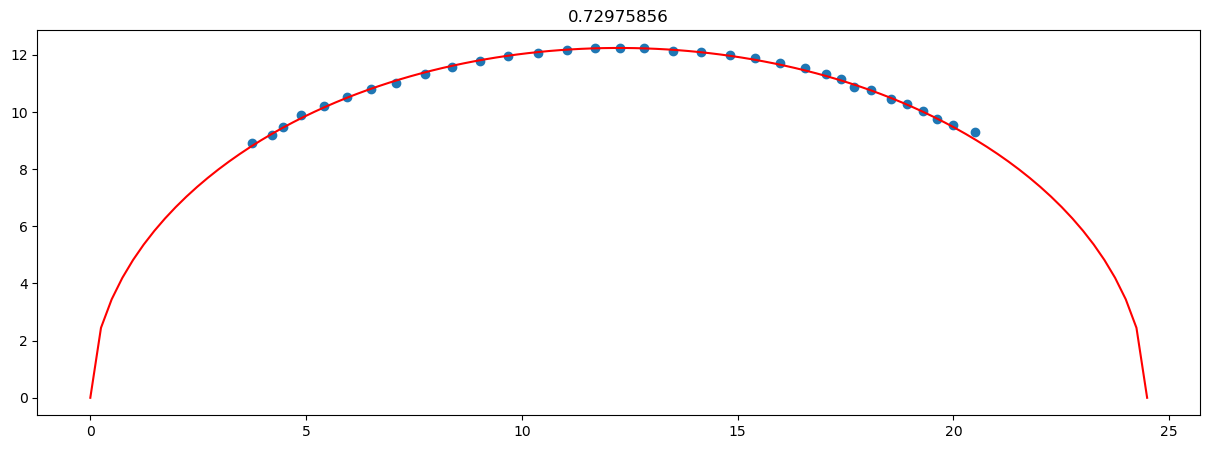

tensor(19.2586, dtype=torch.float64, grad_fn=<AddBackward0>)


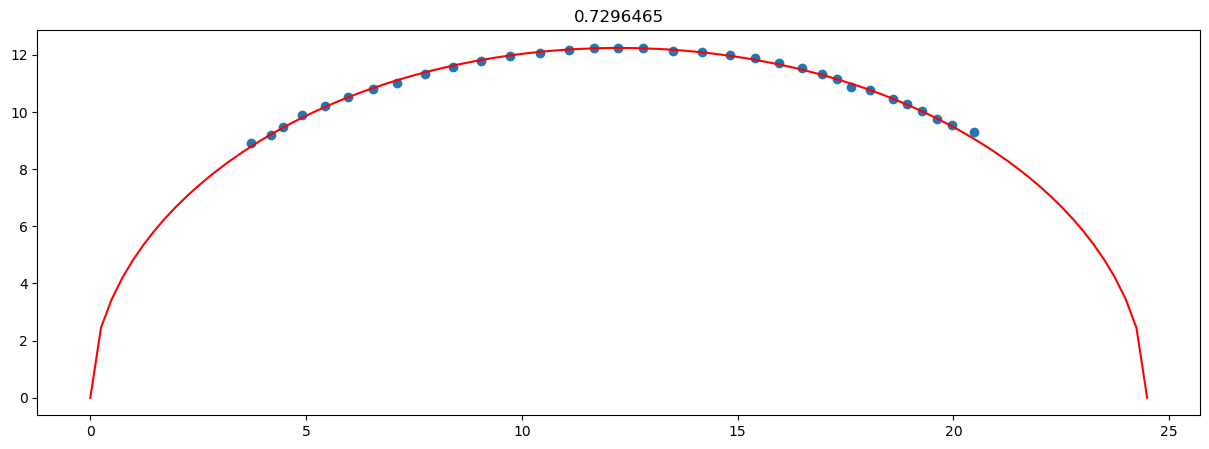

tensor(19.2421, dtype=torch.float64, grad_fn=<AddBackward0>)


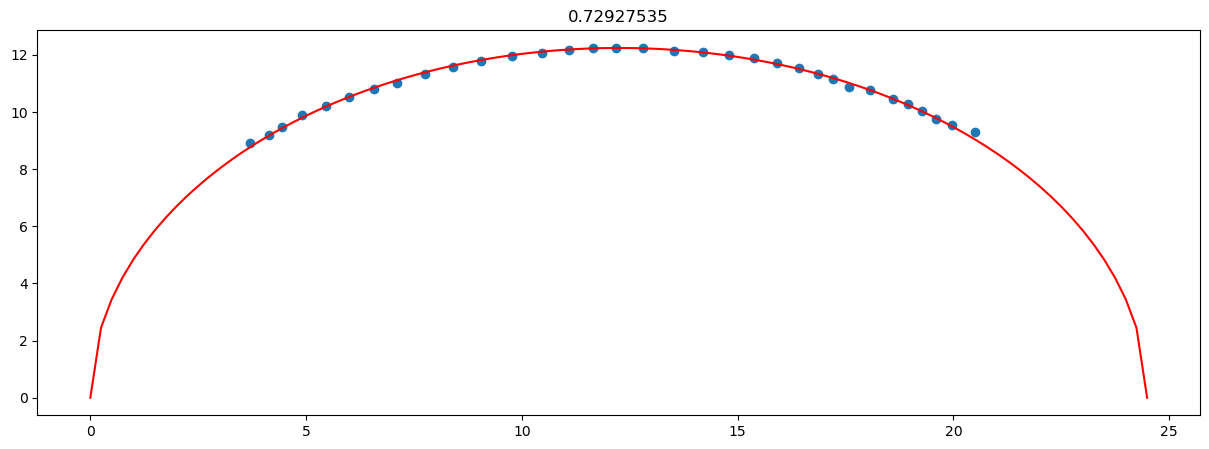

tensor(19.2174, dtype=torch.float64, grad_fn=<AddBackward0>)


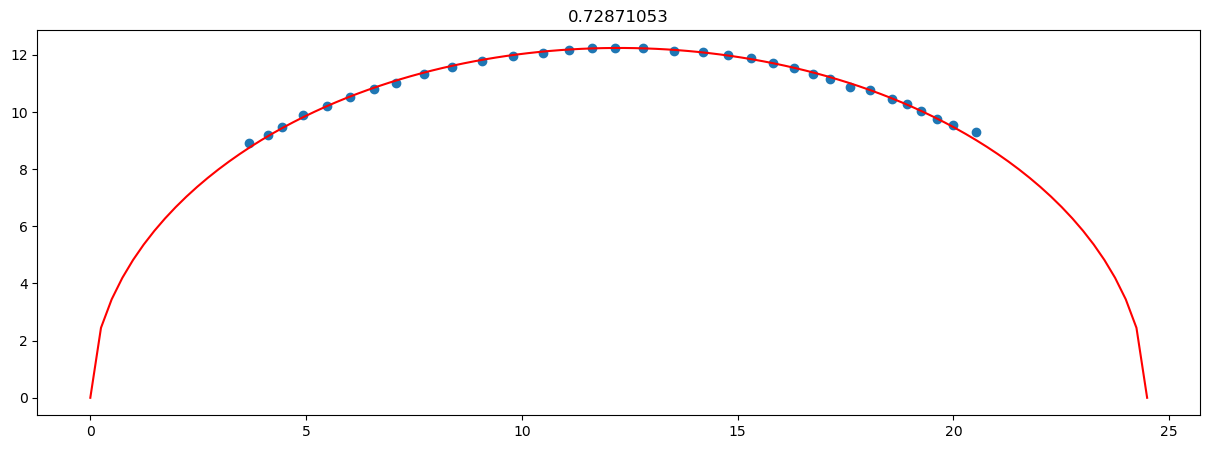

tensor(19.1915, dtype=torch.float64, grad_fn=<AddBackward0>)


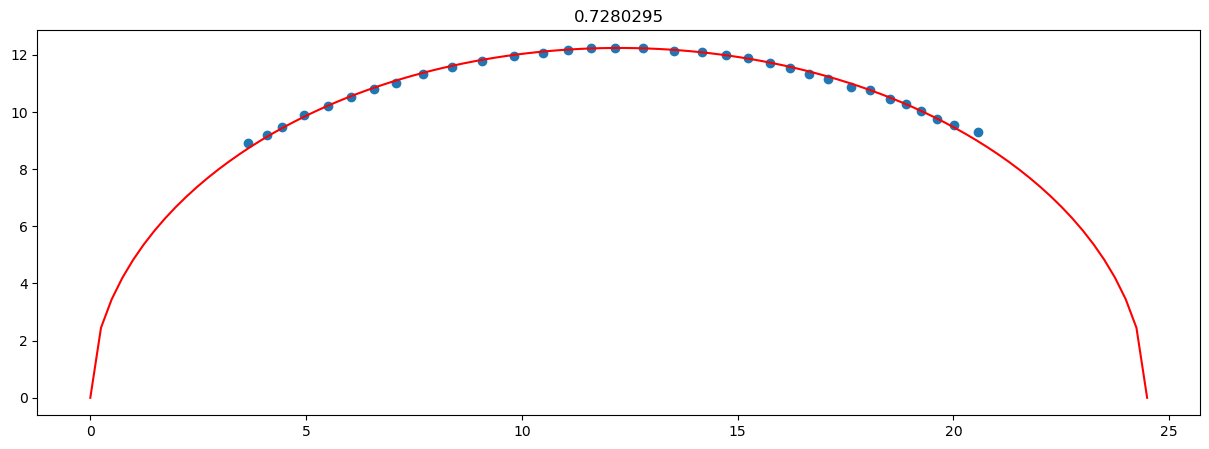

tensor(19.1759, dtype=torch.float64, grad_fn=<AddBackward0>)


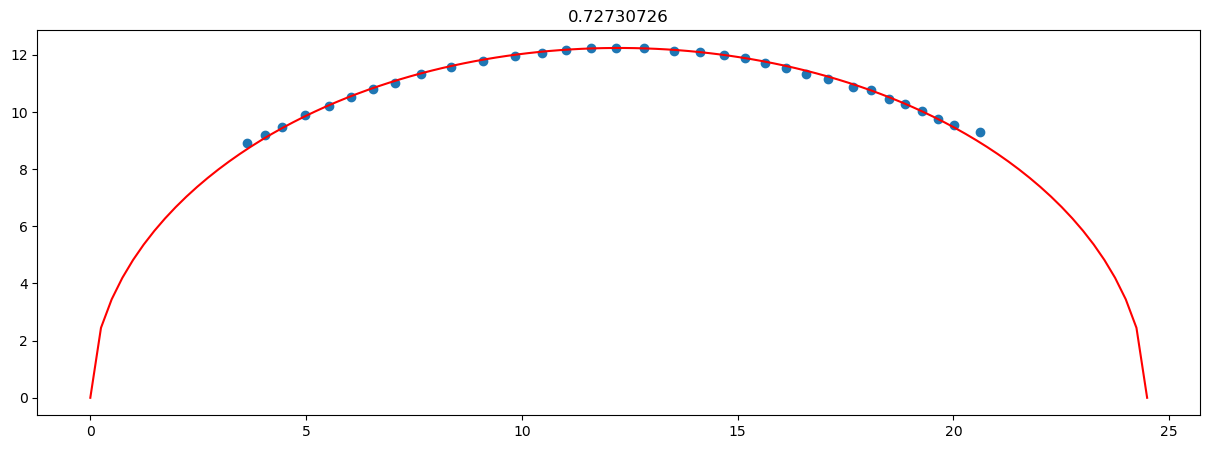

tensor(19.1730, dtype=torch.float64, grad_fn=<AddBackward0>)


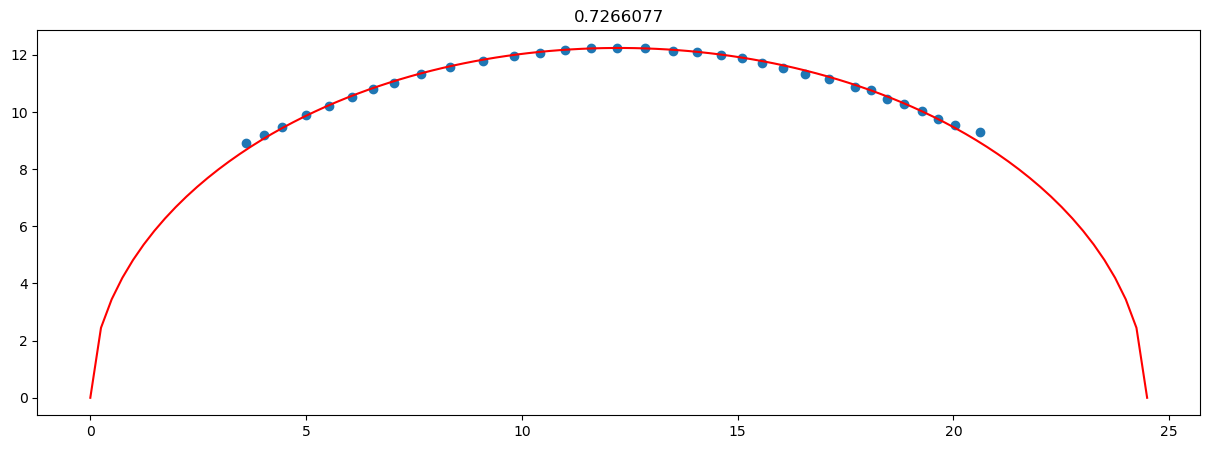

tensor(19.1735, dtype=torch.float64, grad_fn=<AddBackward0>)


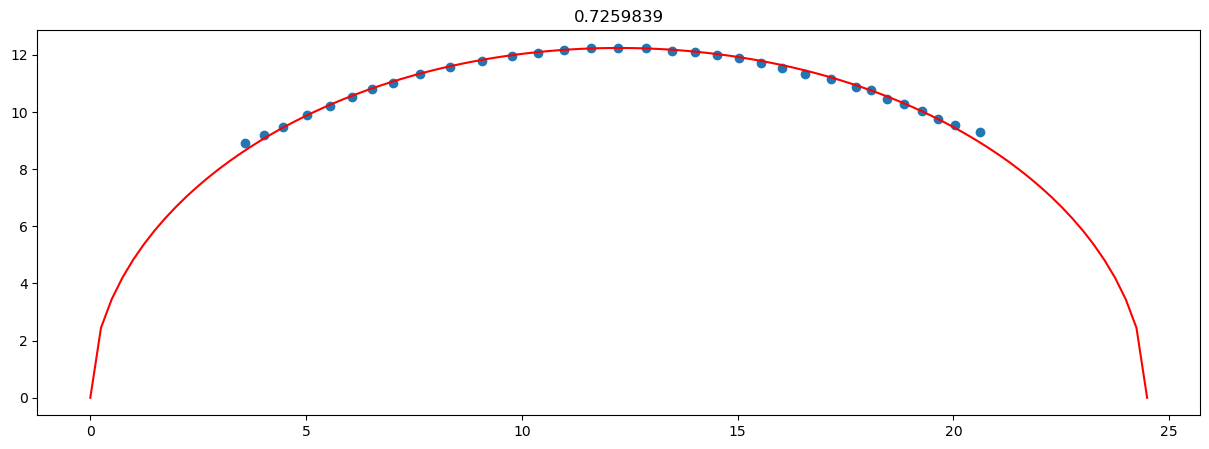

tensor(19.1673, dtype=torch.float64, grad_fn=<AddBackward0>)


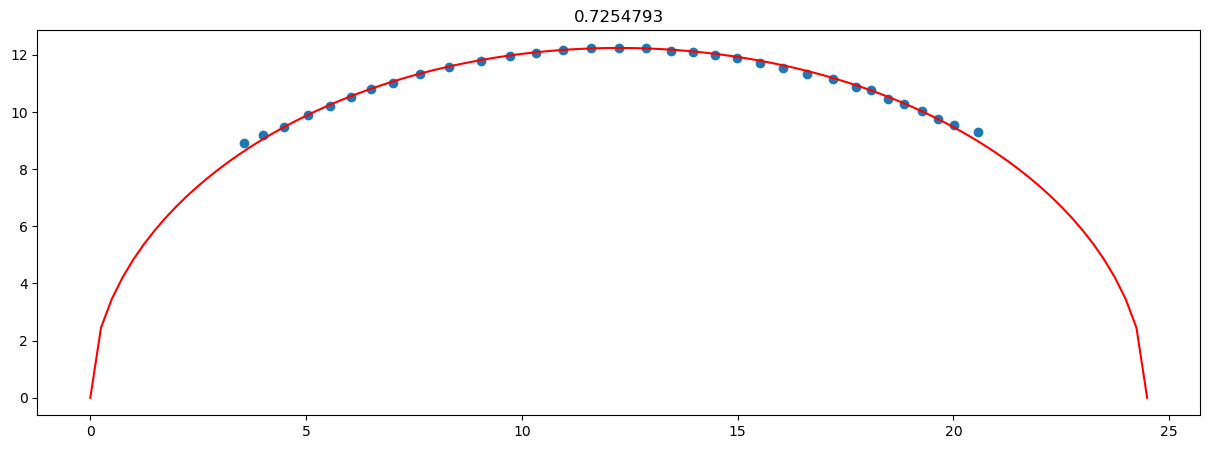

tensor(19.1551, dtype=torch.float64, grad_fn=<AddBackward0>)


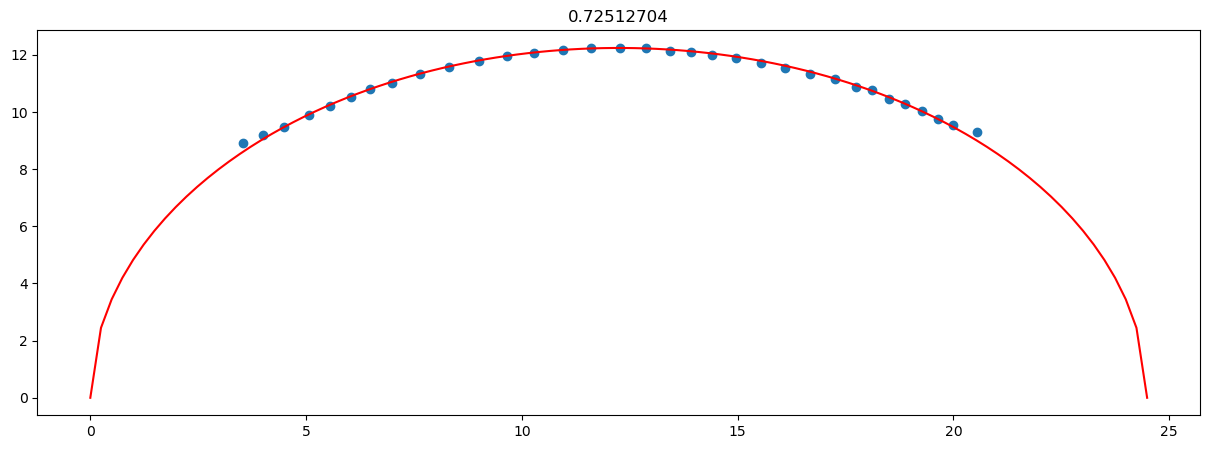

tensor(19.1445, dtype=torch.float64, grad_fn=<AddBackward0>)


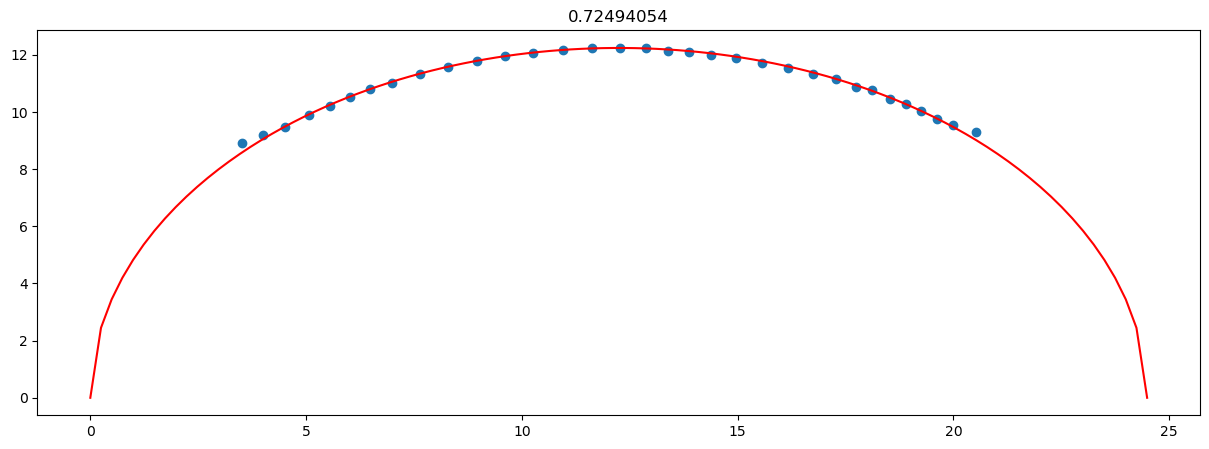

tensor(19.1404, dtype=torch.float64, grad_fn=<AddBackward0>)


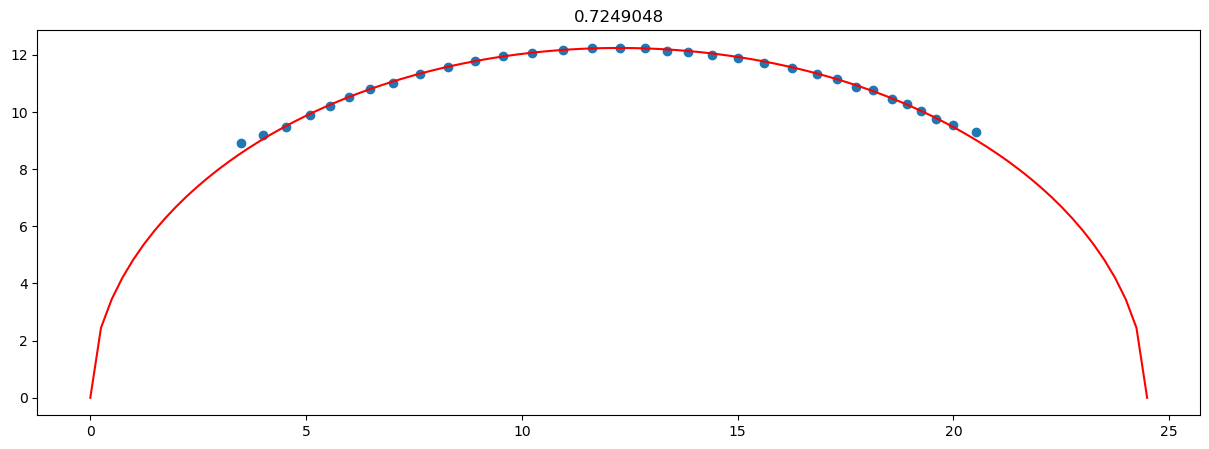

tensor(19.1416, dtype=torch.float64, grad_fn=<AddBackward0>)


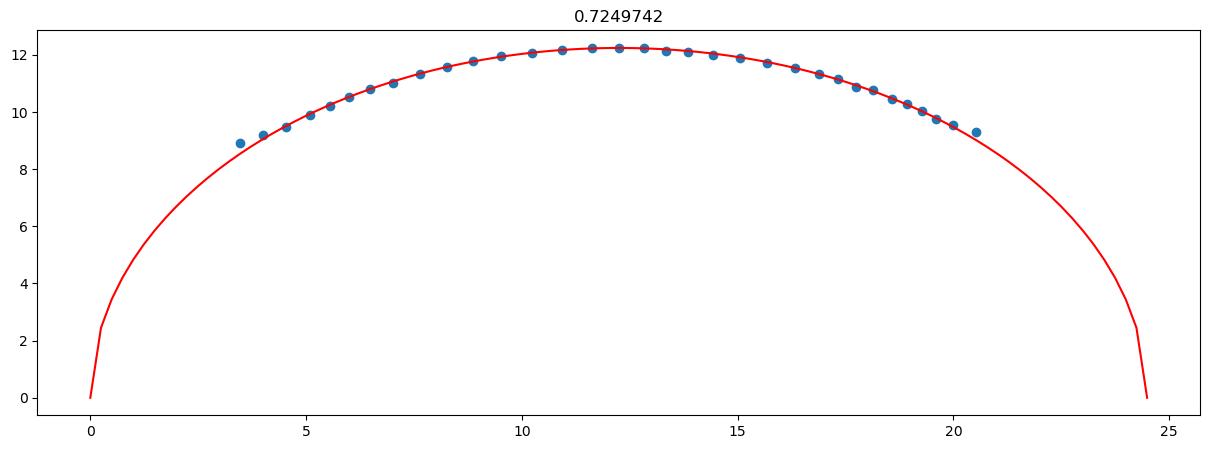

tensor(19.1430, dtype=torch.float64, grad_fn=<AddBackward0>)


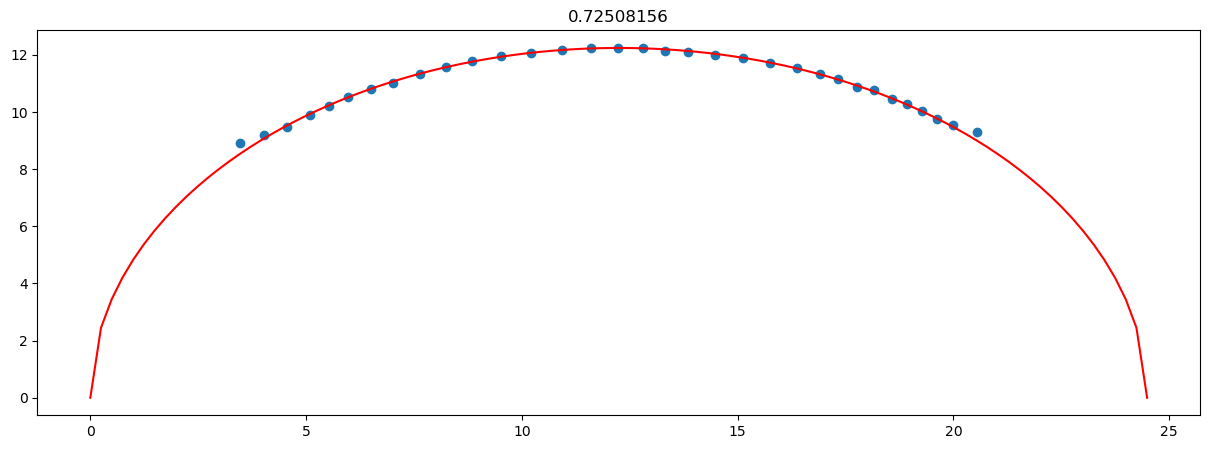

tensor(19.1414, dtype=torch.float64, grad_fn=<AddBackward0>)


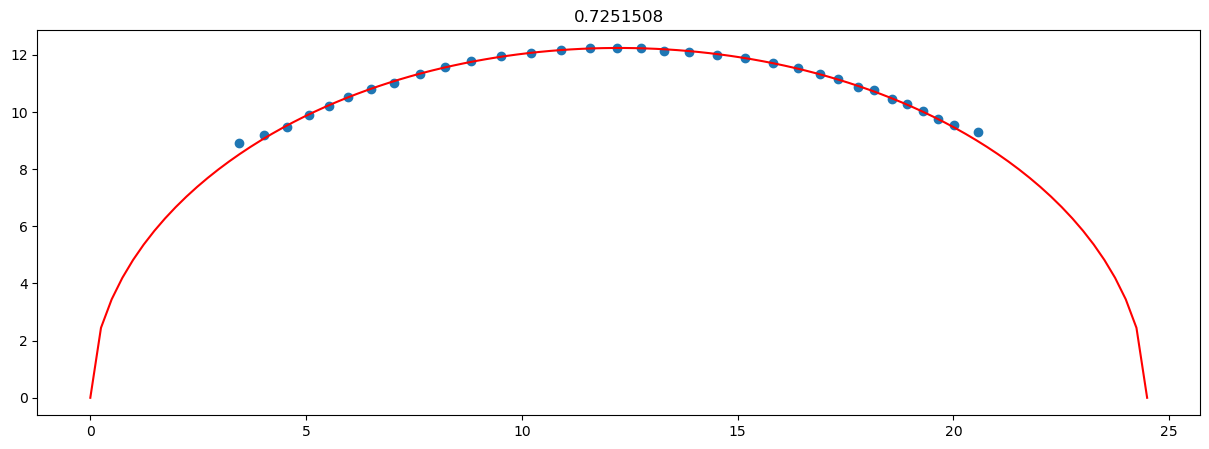

tensor(19.1377, dtype=torch.float64, grad_fn=<AddBackward0>)


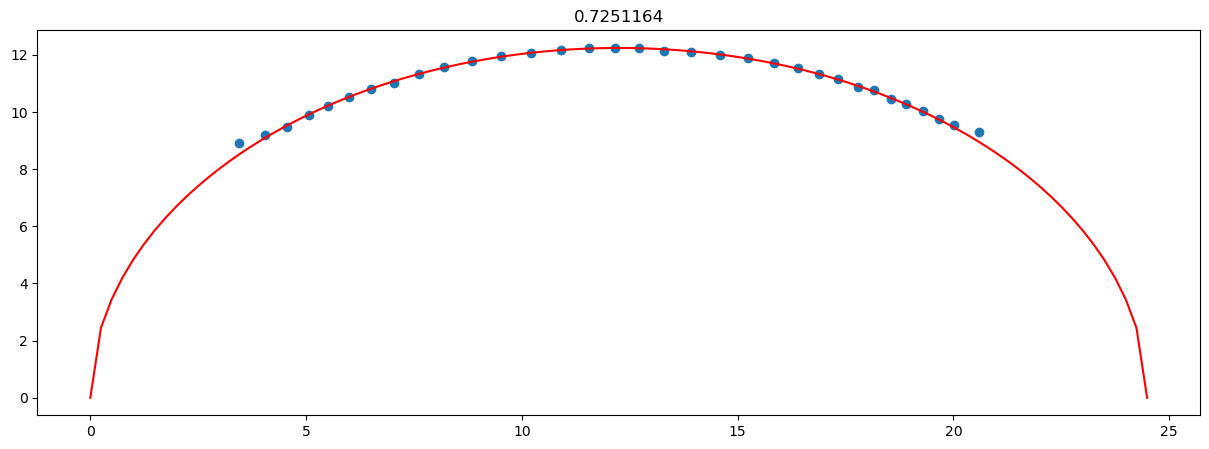

tensor(19.1338, dtype=torch.float64, grad_fn=<AddBackward0>)


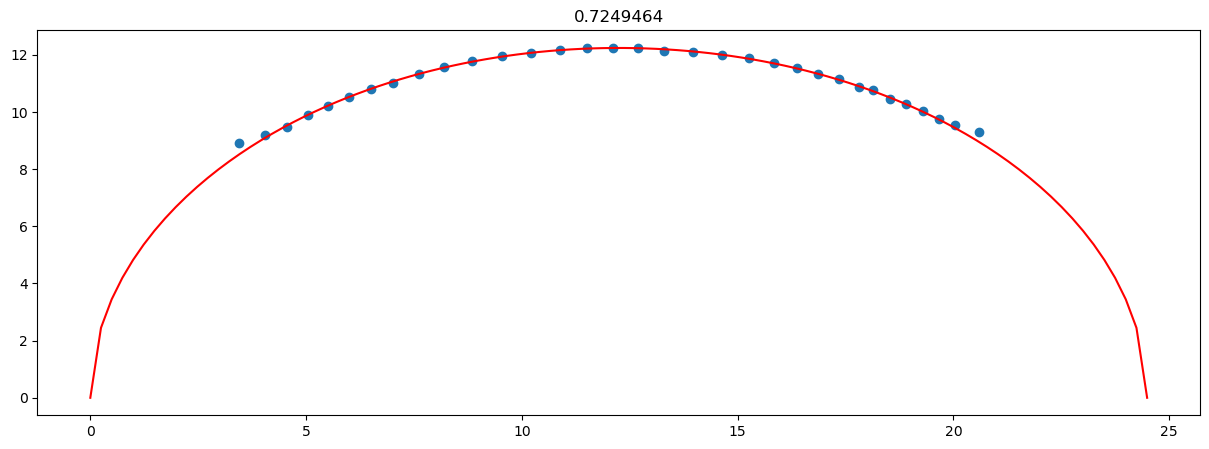

tensor(19.1297, dtype=torch.float64, grad_fn=<AddBackward0>)


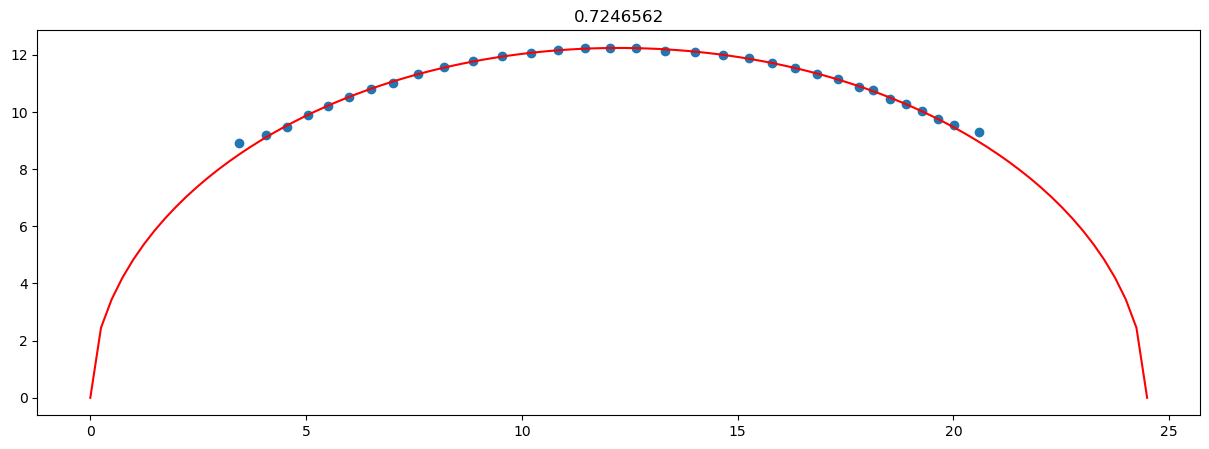

tensor(19.1252, dtype=torch.float64, grad_fn=<AddBackward0>)


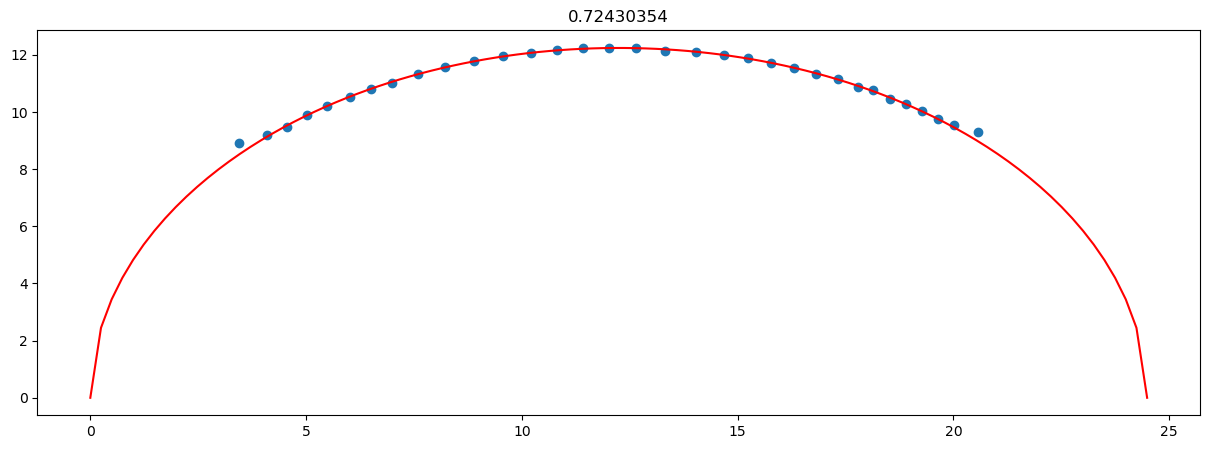

tensor(19.1220, dtype=torch.float64, grad_fn=<AddBackward0>)


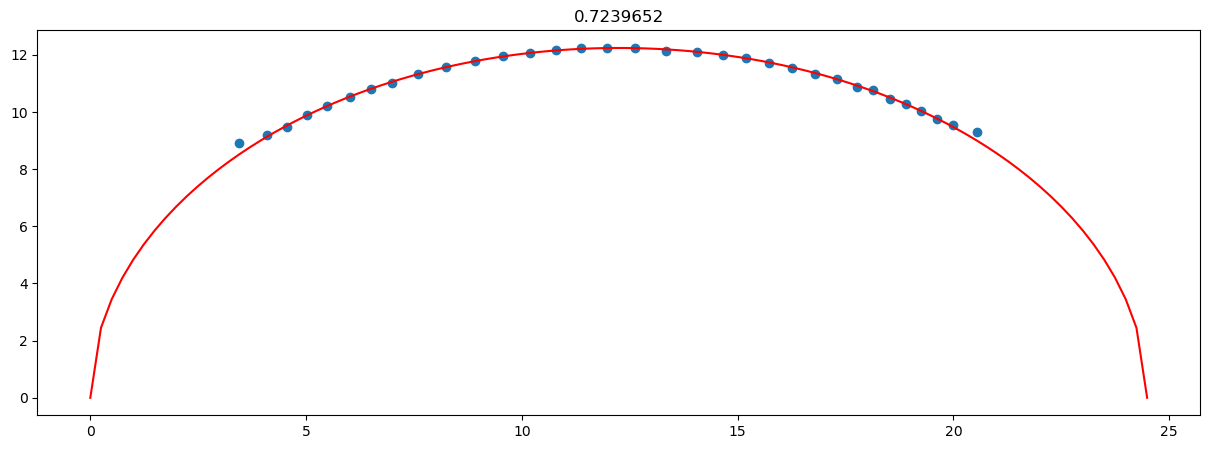

tensor(19.1206, dtype=torch.float64, grad_fn=<AddBackward0>)


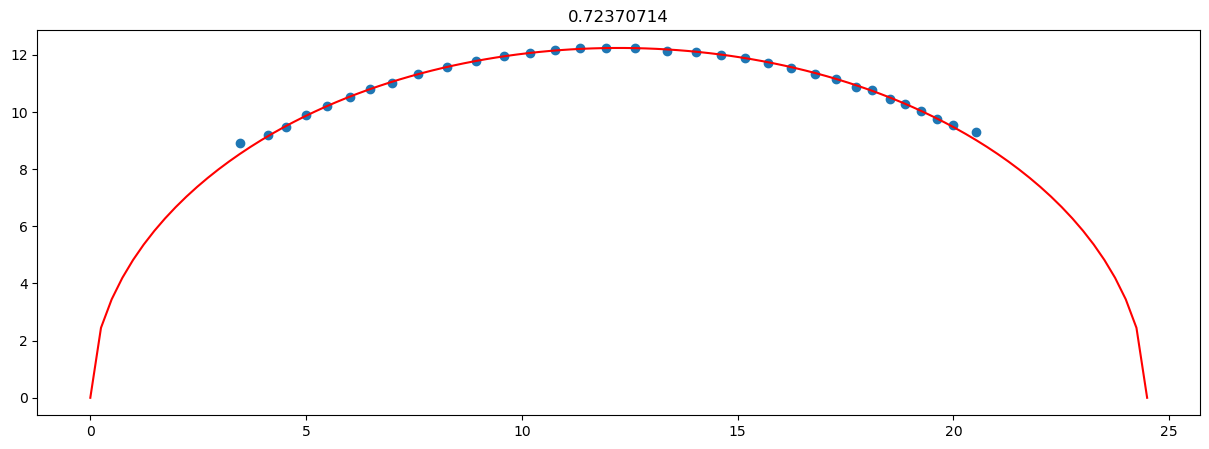

tensor(19.1197, dtype=torch.float64, grad_fn=<AddBackward0>)


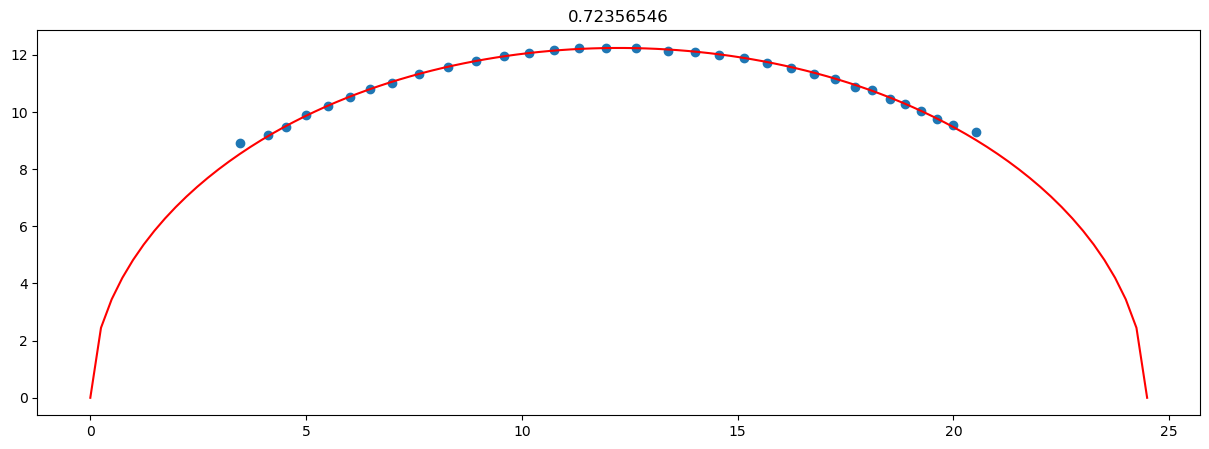

tensor(19.1176, dtype=torch.float64, grad_fn=<AddBackward0>)


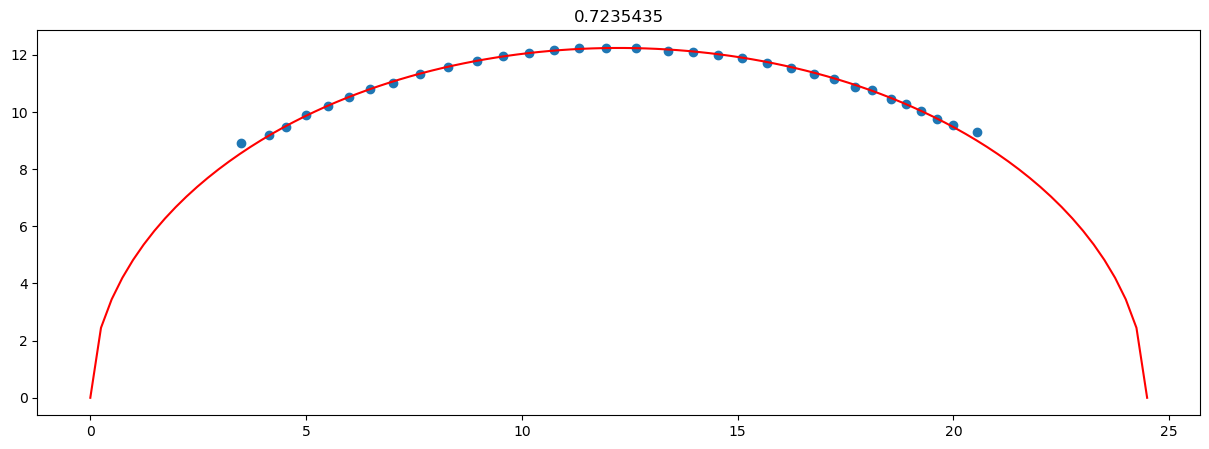

tensor(19.1147, dtype=torch.float64, grad_fn=<AddBackward0>)


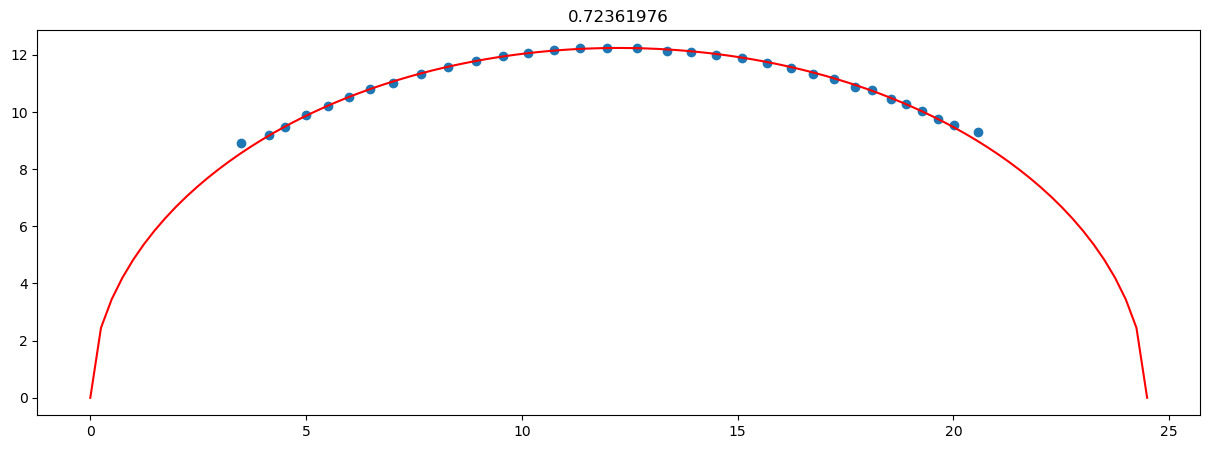

tensor(19.1120, dtype=torch.float64, grad_fn=<AddBackward0>)


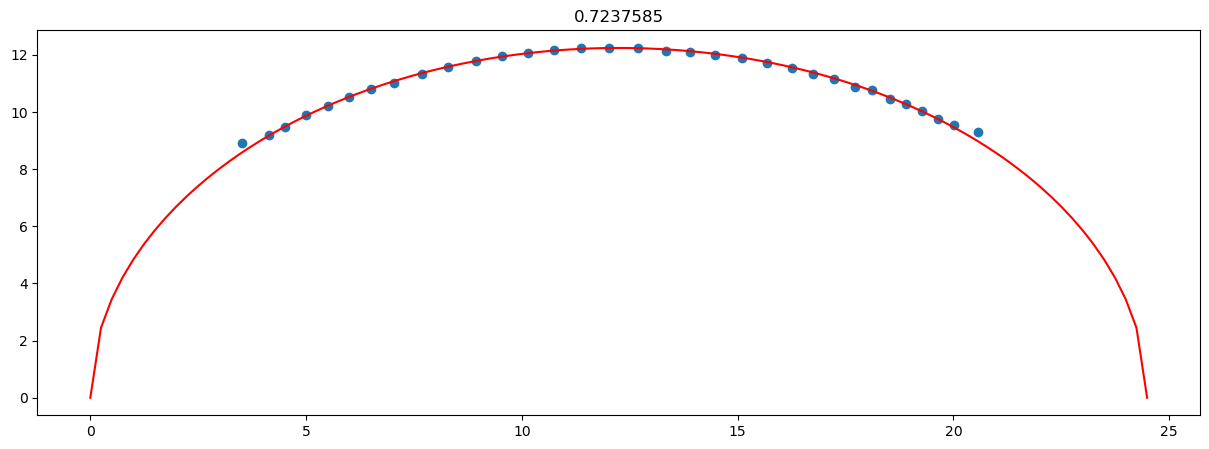

tensor(19.1094, dtype=torch.float64, grad_fn=<AddBackward0>)


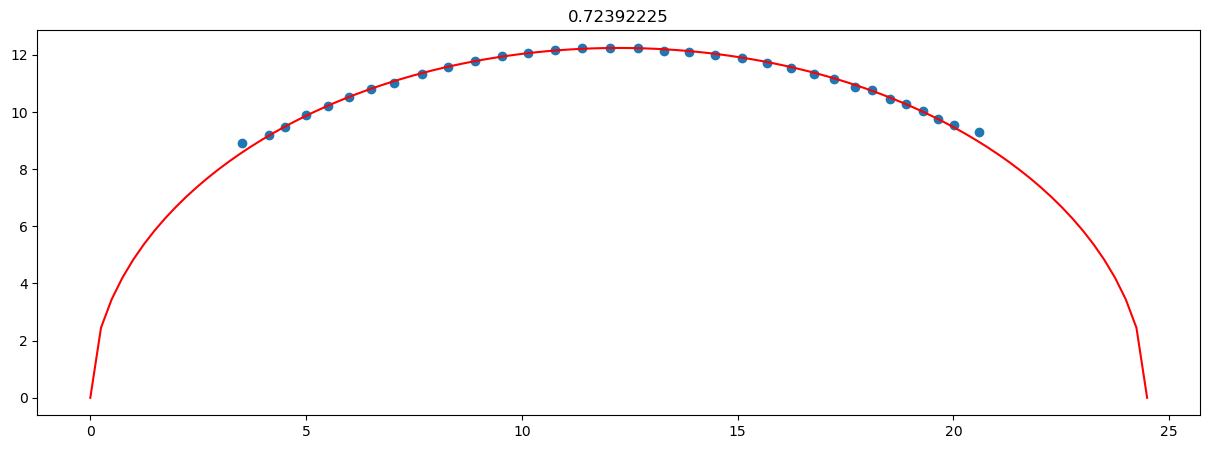

tensor(19.1067, dtype=torch.float64, grad_fn=<AddBackward0>)


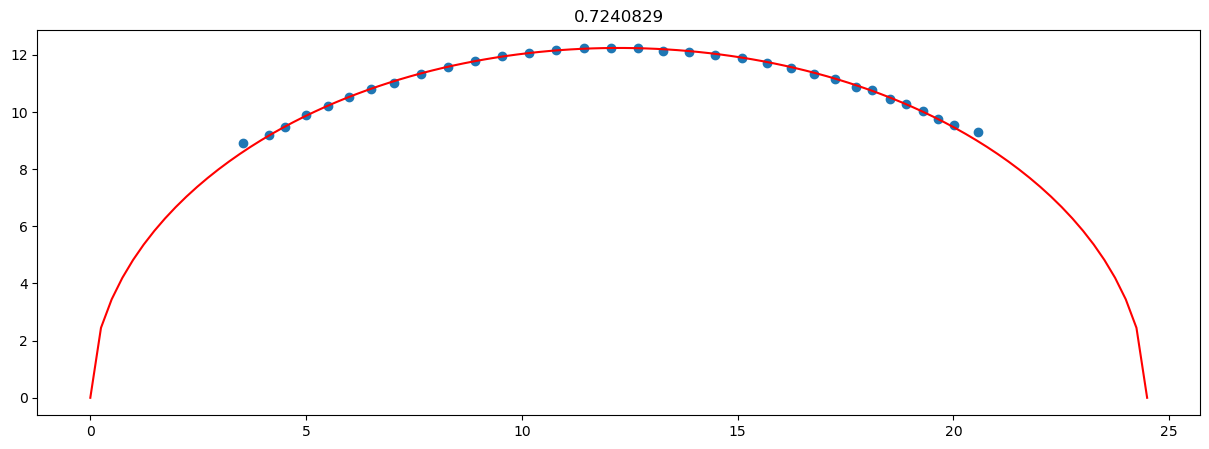

tensor(19.1041, dtype=torch.float64, grad_fn=<AddBackward0>)


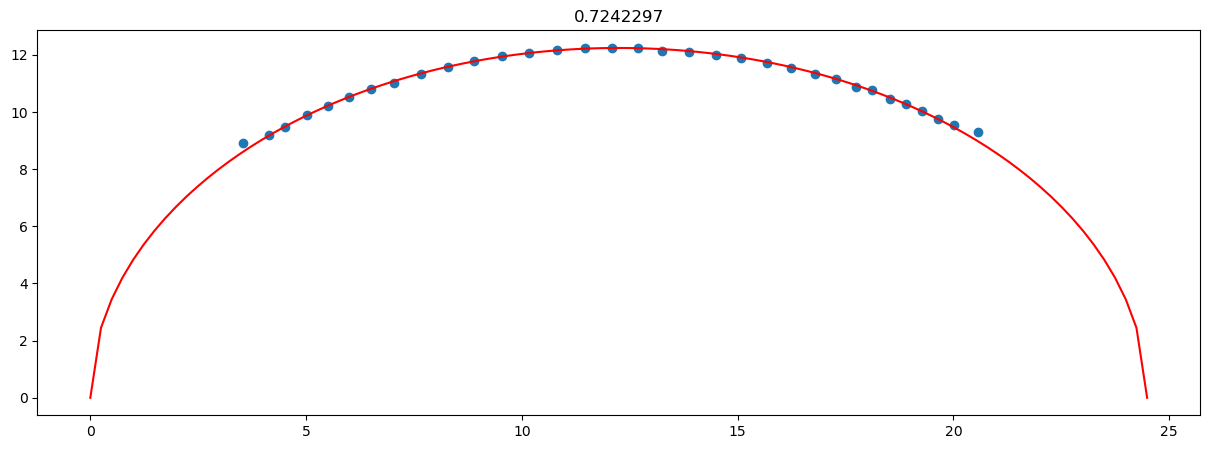

tensor(19.1022, dtype=torch.float64, grad_fn=<AddBackward0>)


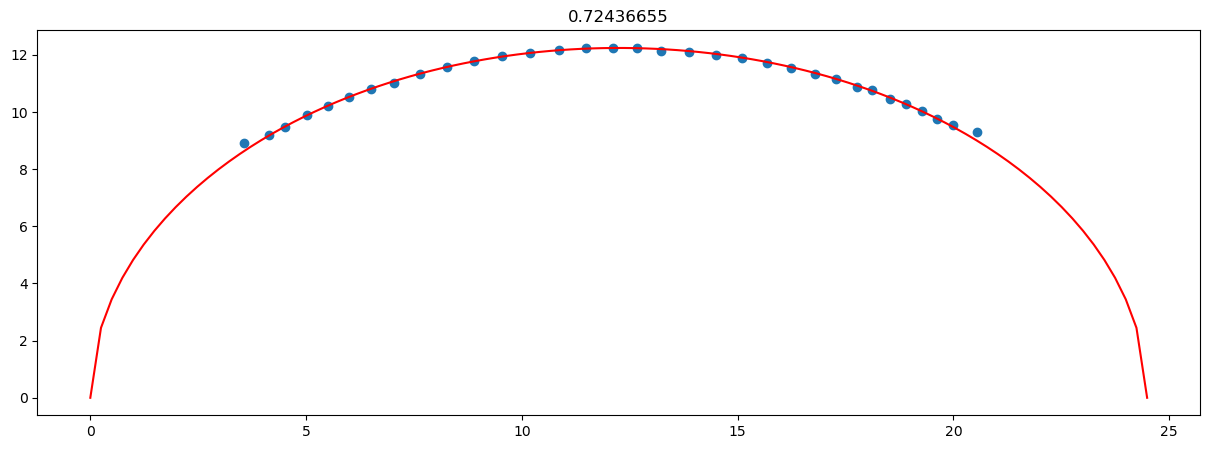

tensor(19.1014, dtype=torch.float64, grad_fn=<AddBackward0>)


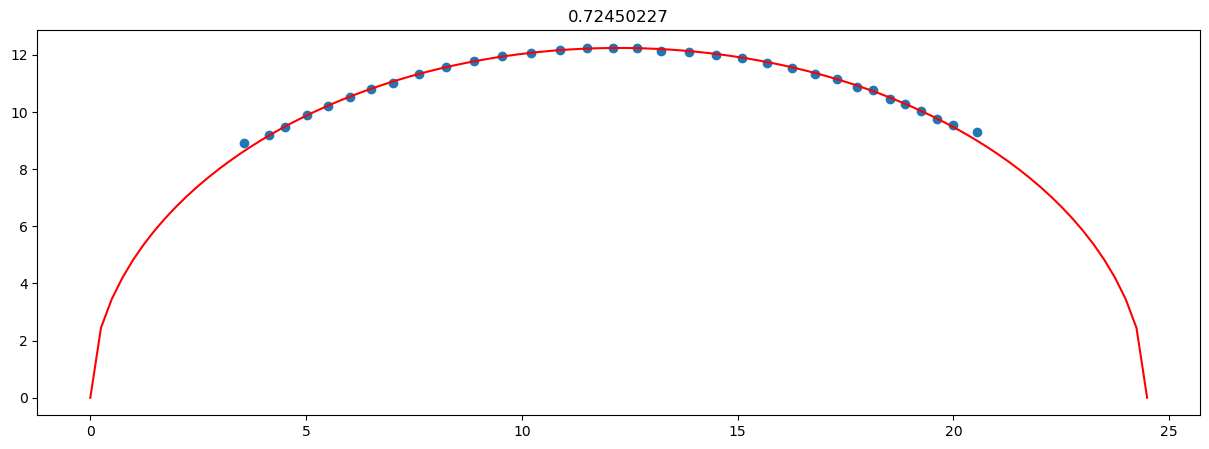

tensor(19.1016, dtype=torch.float64, grad_fn=<AddBackward0>)


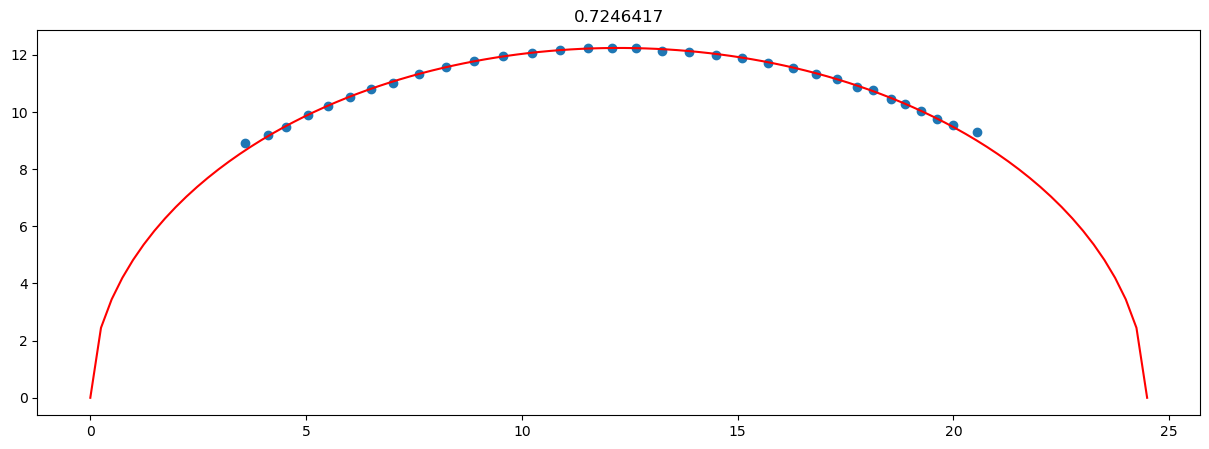

tensor(19.1020, dtype=torch.float64, grad_fn=<AddBackward0>)


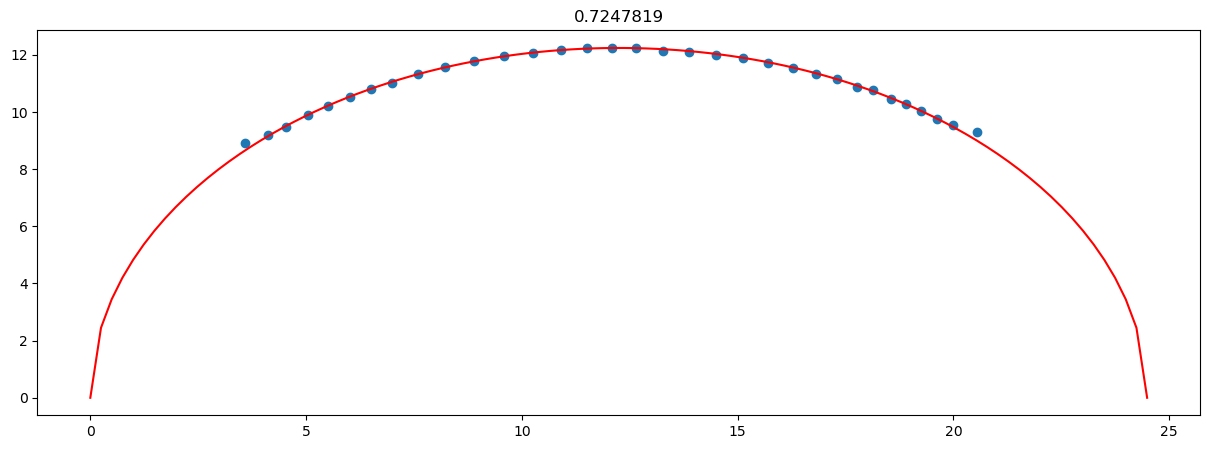

tensor(19.1021, dtype=torch.float64, grad_fn=<AddBackward0>)


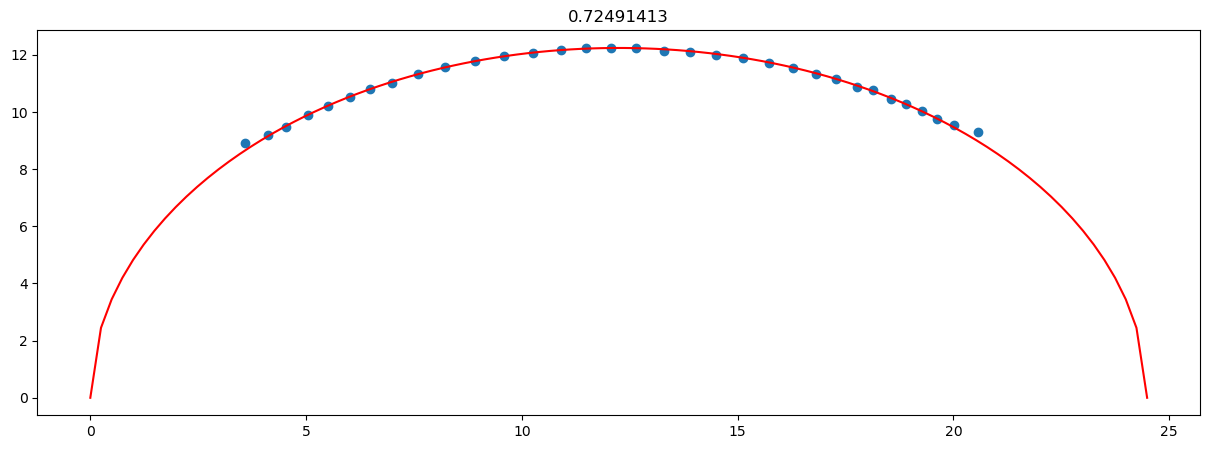

tensor(19.1019, dtype=torch.float64, grad_fn=<AddBackward0>)


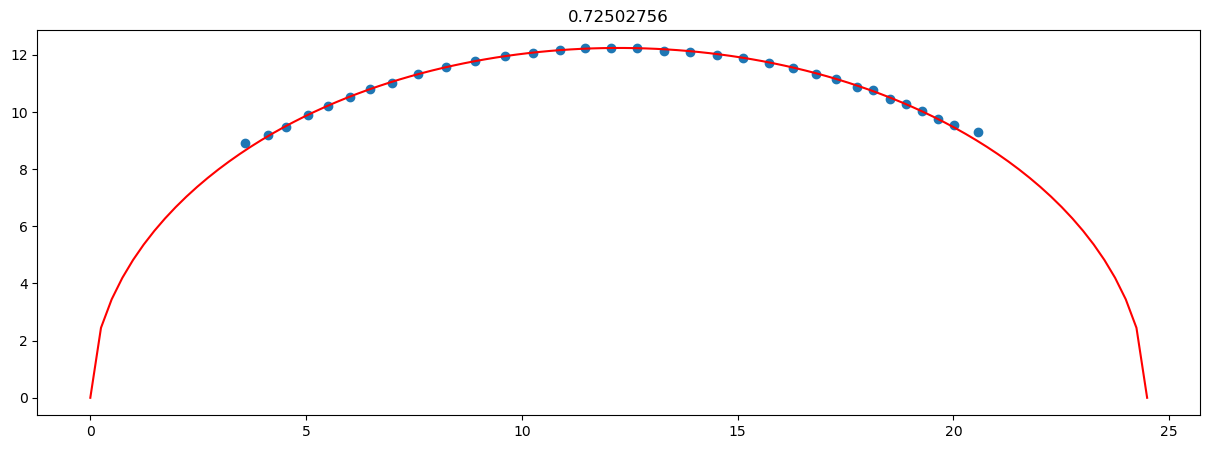

tensor(19.1017, dtype=torch.float64, grad_fn=<AddBackward0>)


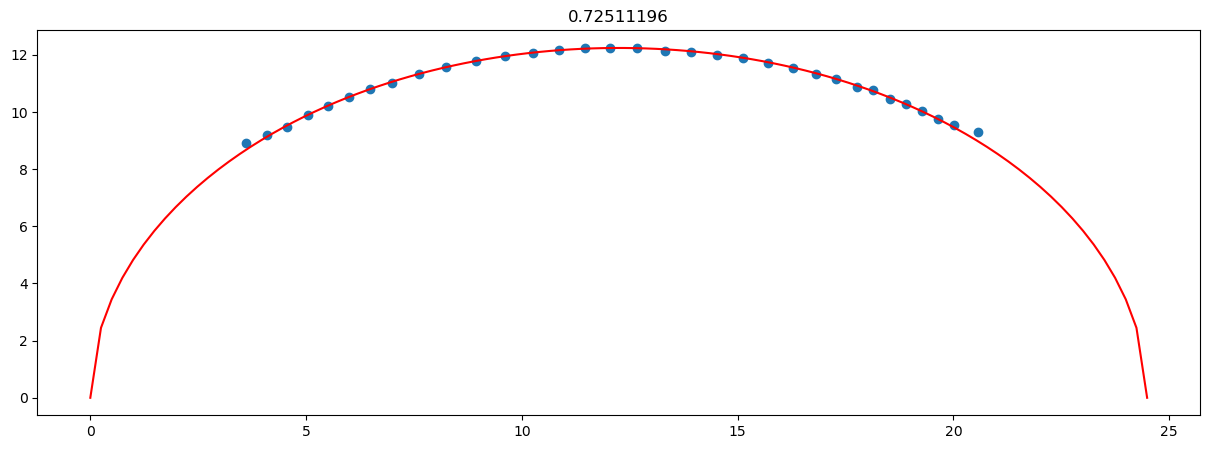

tensor(19.1014, dtype=torch.float64, grad_fn=<AddBackward0>)


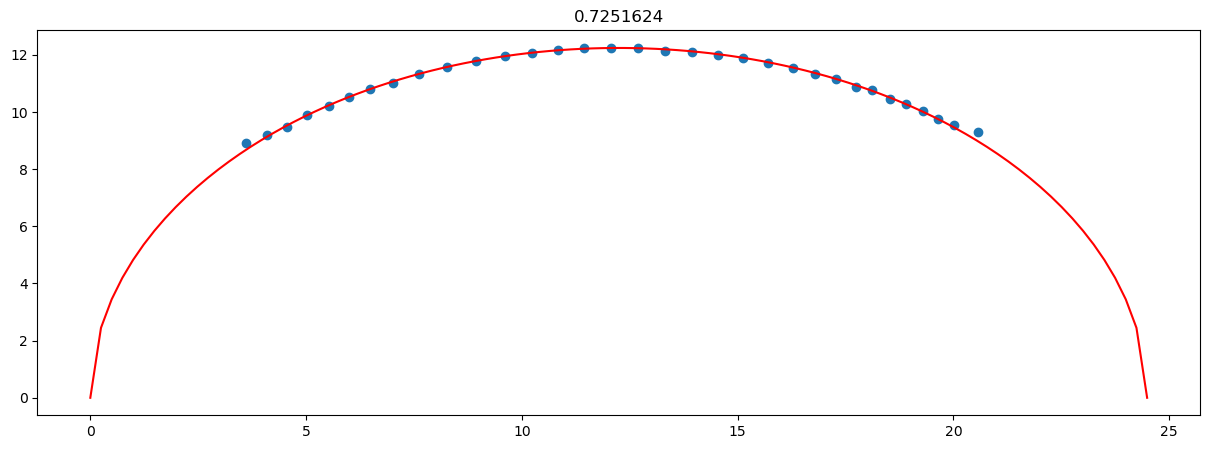

tensor(19.1011, dtype=torch.float64, grad_fn=<AddBackward0>)


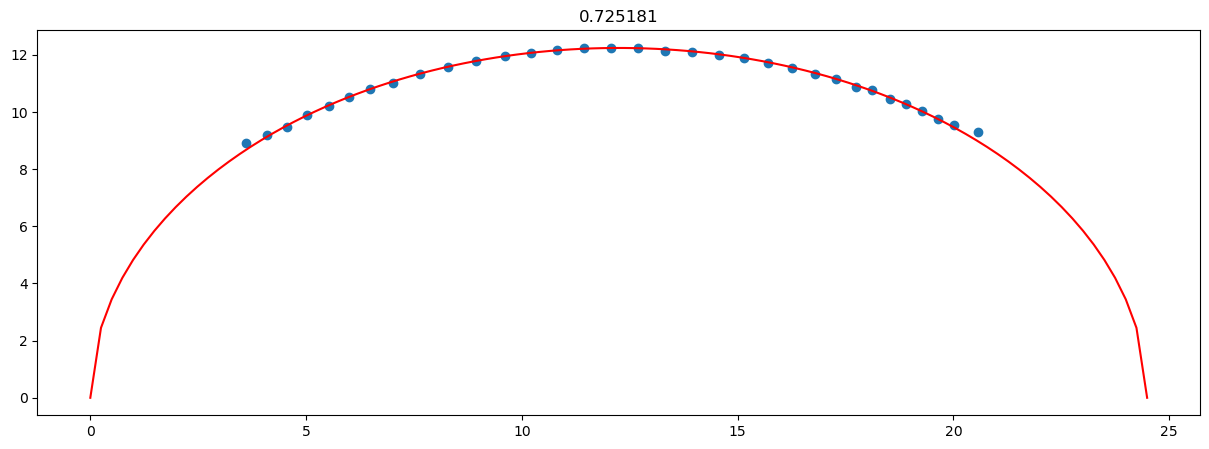

tensor(19.1008, dtype=torch.float64, grad_fn=<AddBackward0>)


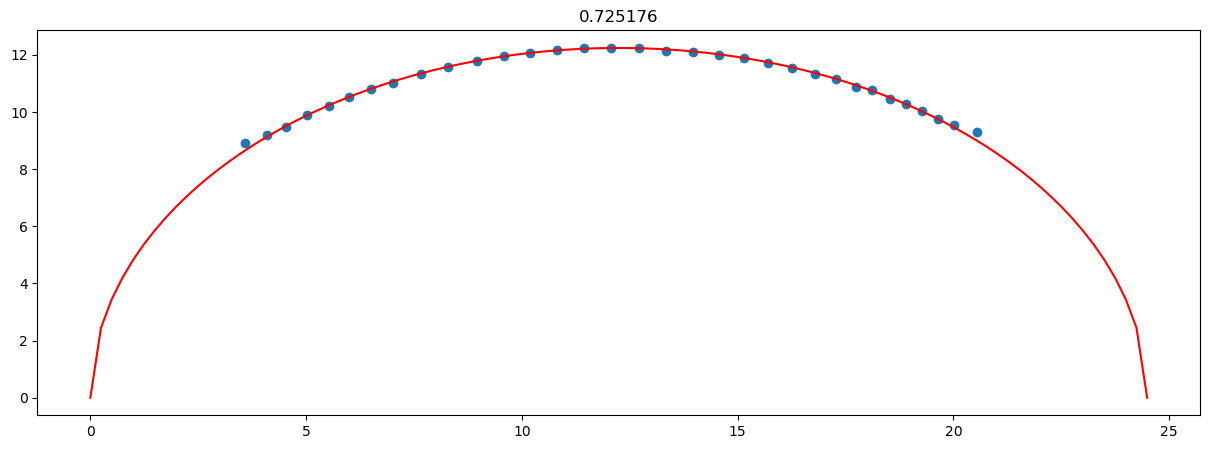

tensor(19.1005, dtype=torch.float64, grad_fn=<AddBackward0>)


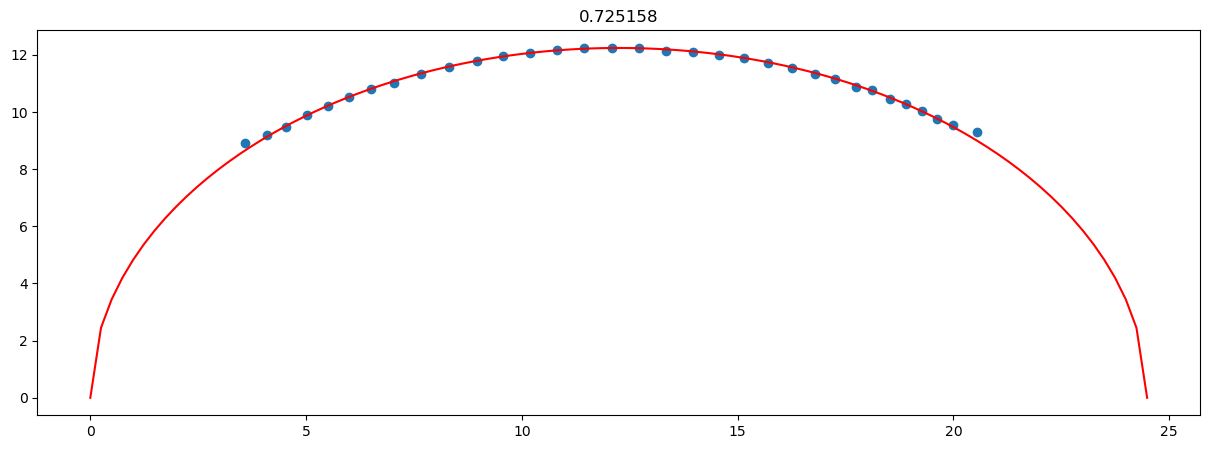

tensor(19.1002, dtype=torch.float64, grad_fn=<AddBackward0>)


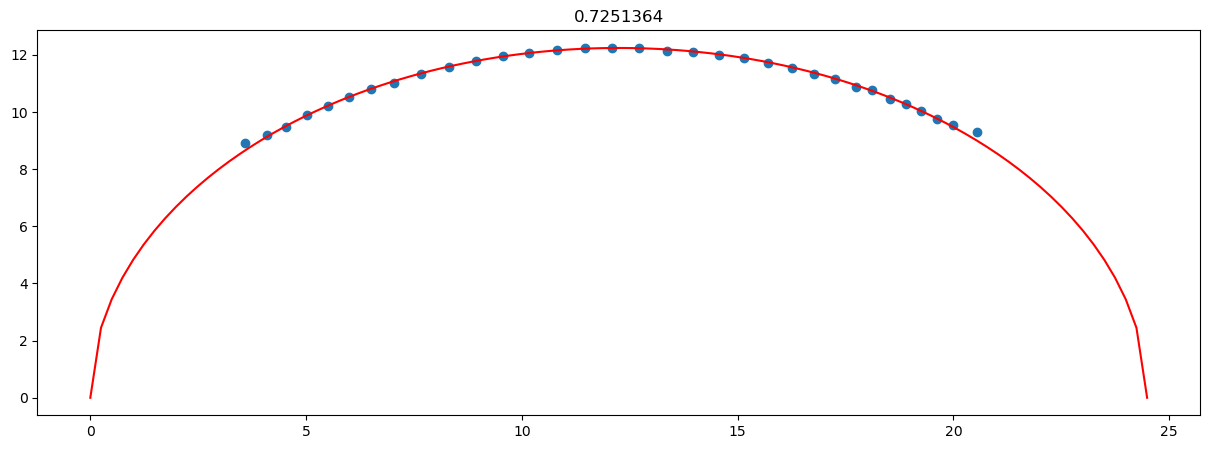

tensor(19.0996, dtype=torch.float64, grad_fn=<AddBackward0>)


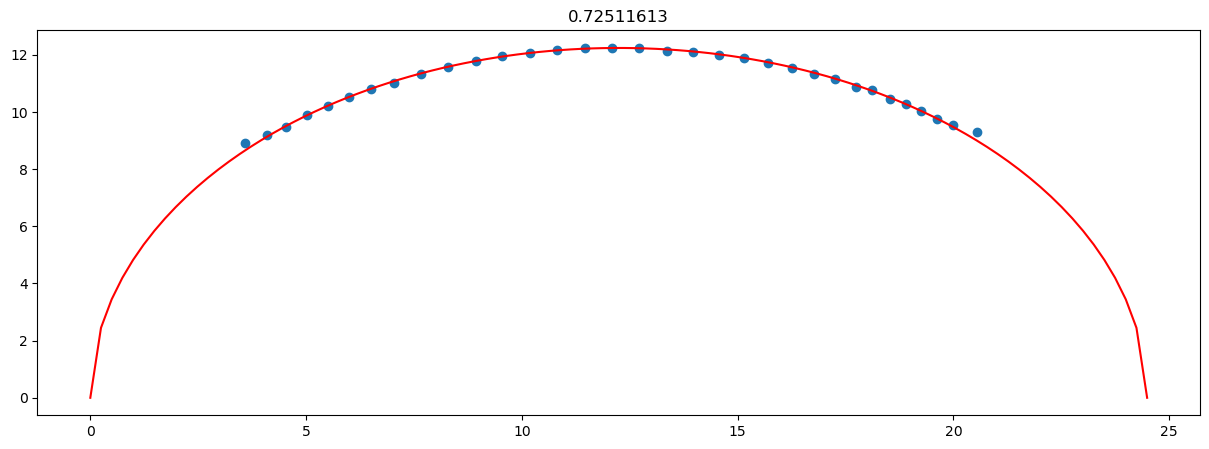

tensor(19.0985, dtype=torch.float64, grad_fn=<AddBackward0>)


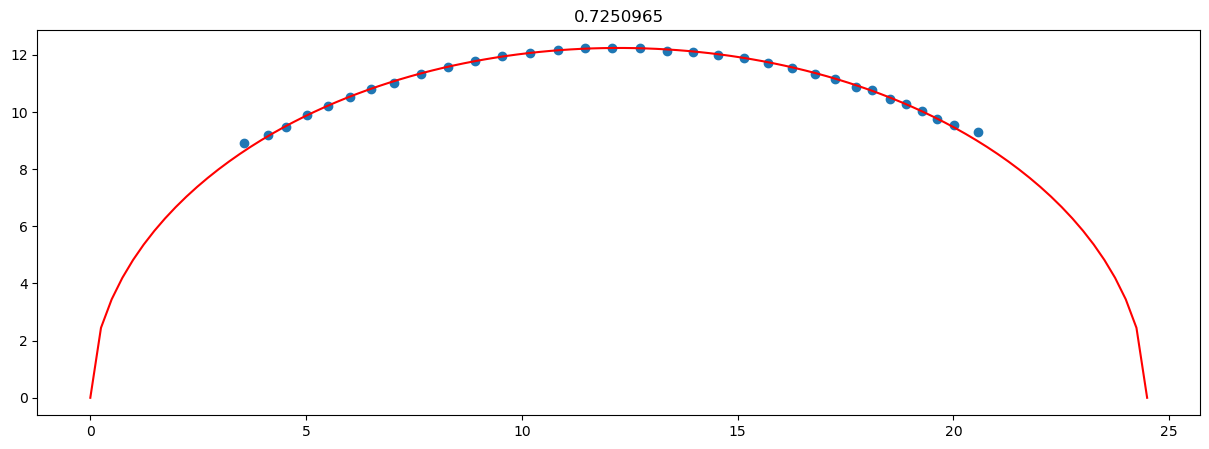

tensor(19.0974, dtype=torch.float64, grad_fn=<AddBackward0>)


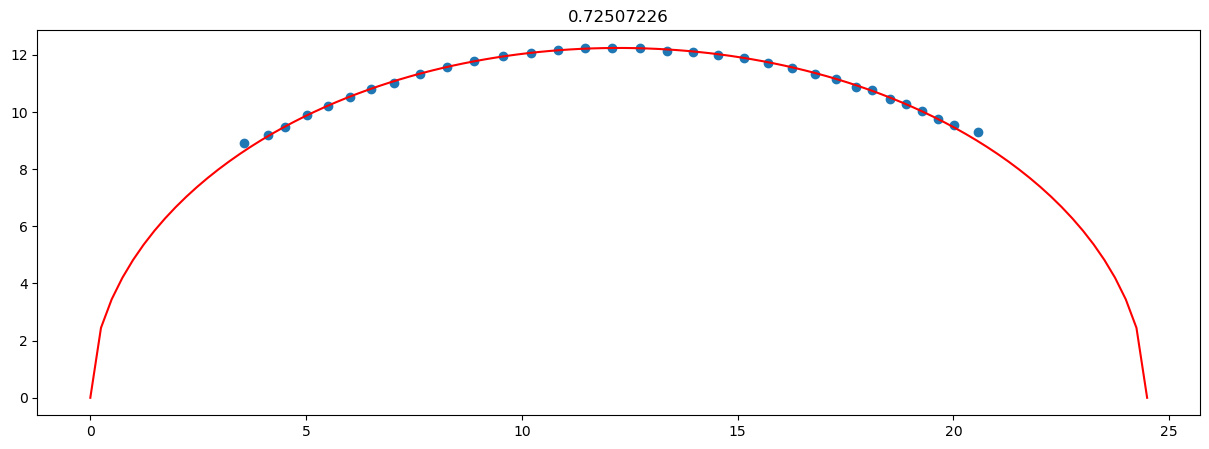

tensor(19.0968, dtype=torch.float64, grad_fn=<AddBackward0>)


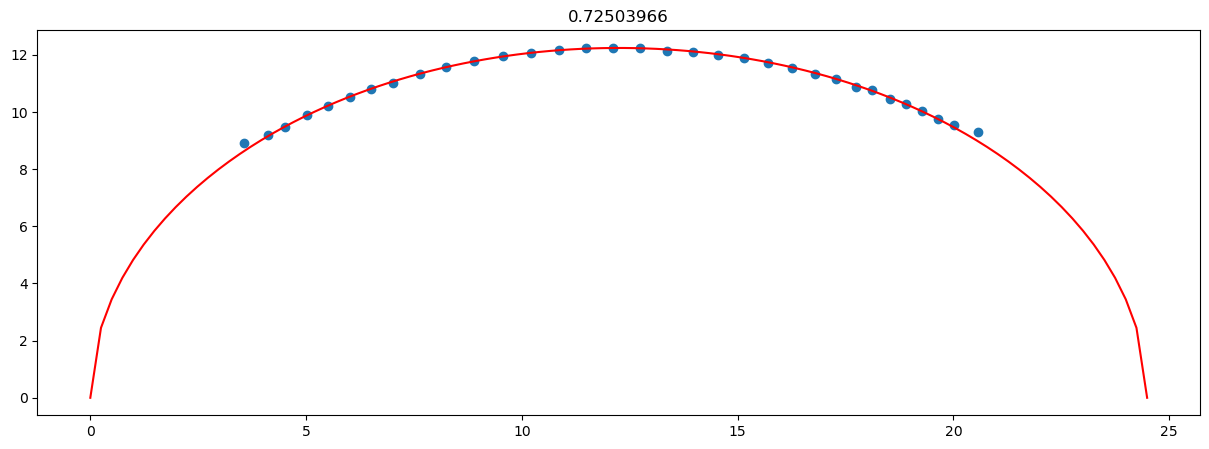

tensor(19.0967, dtype=torch.float64, grad_fn=<AddBackward0>)


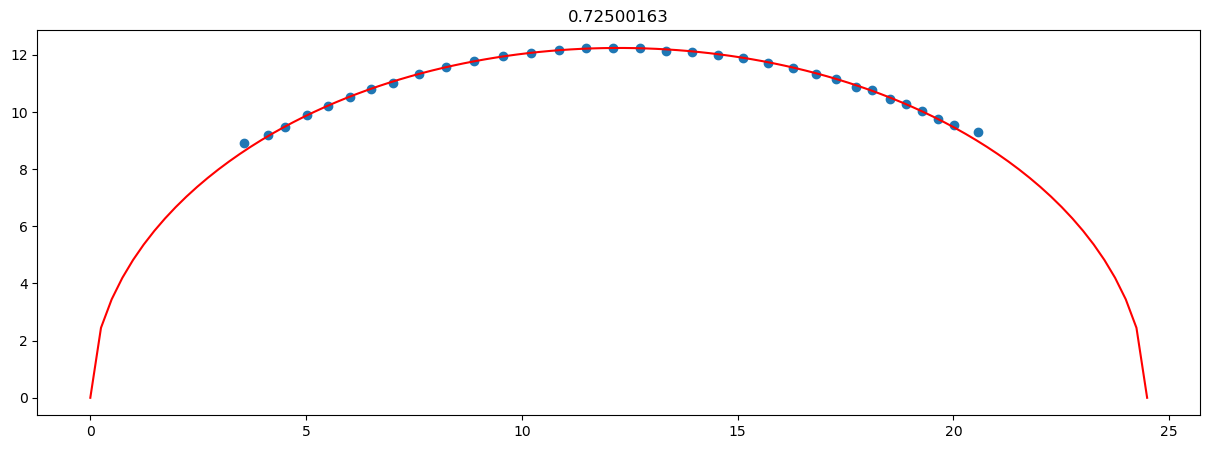

tensor(19.0968, dtype=torch.float64, grad_fn=<AddBackward0>)


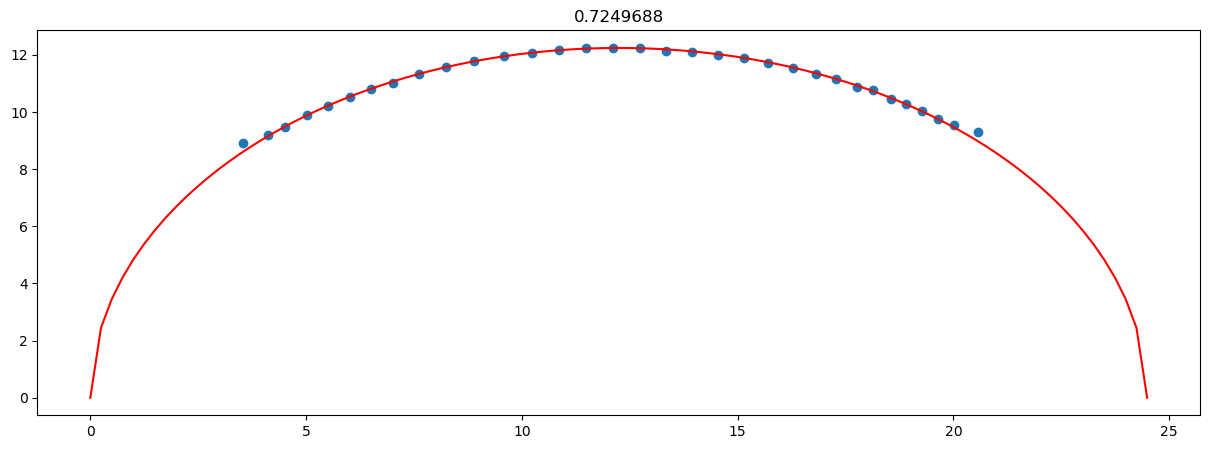

tensor(19.0968, dtype=torch.float64, grad_fn=<AddBackward0>)


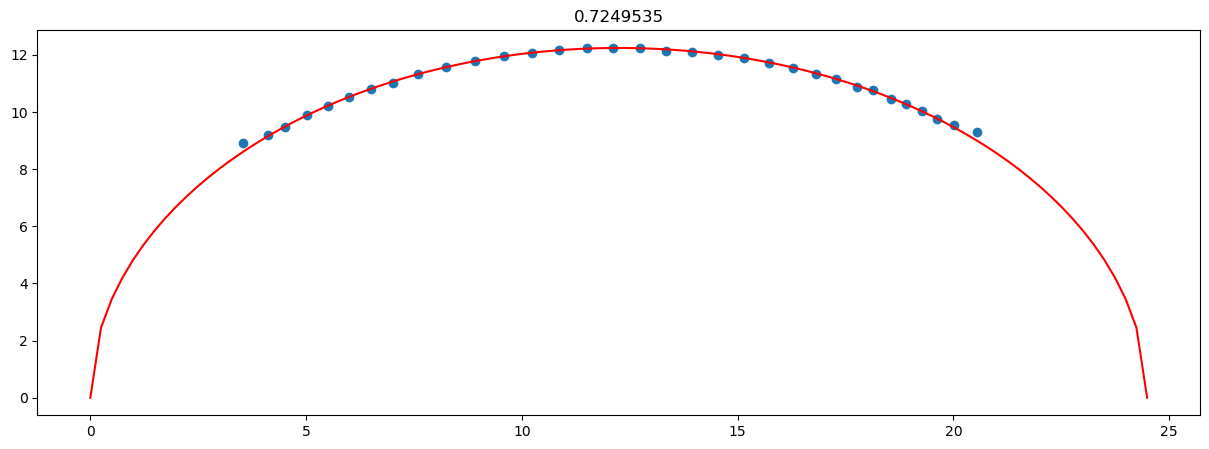

tensor(19.0969, dtype=torch.float64, grad_fn=<AddBackward0>)


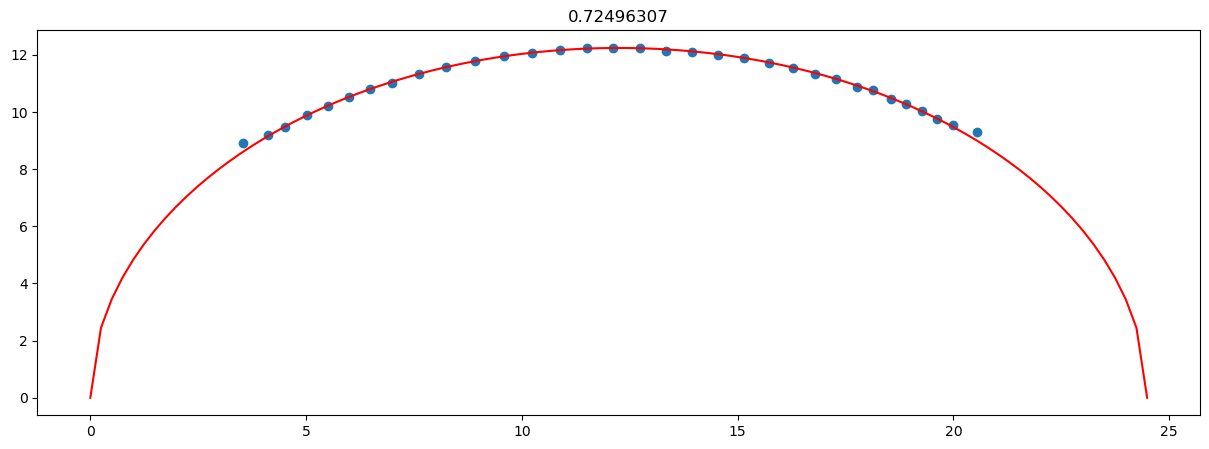

tensor(19.0968, dtype=torch.float64, grad_fn=<AddBackward0>)


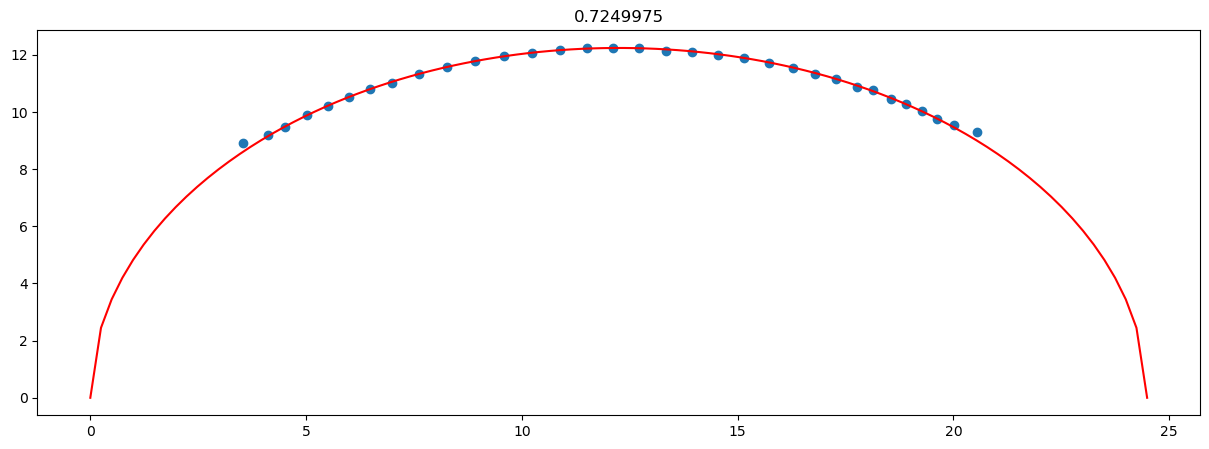

tensor(19.0968, dtype=torch.float64, grad_fn=<AddBackward0>)


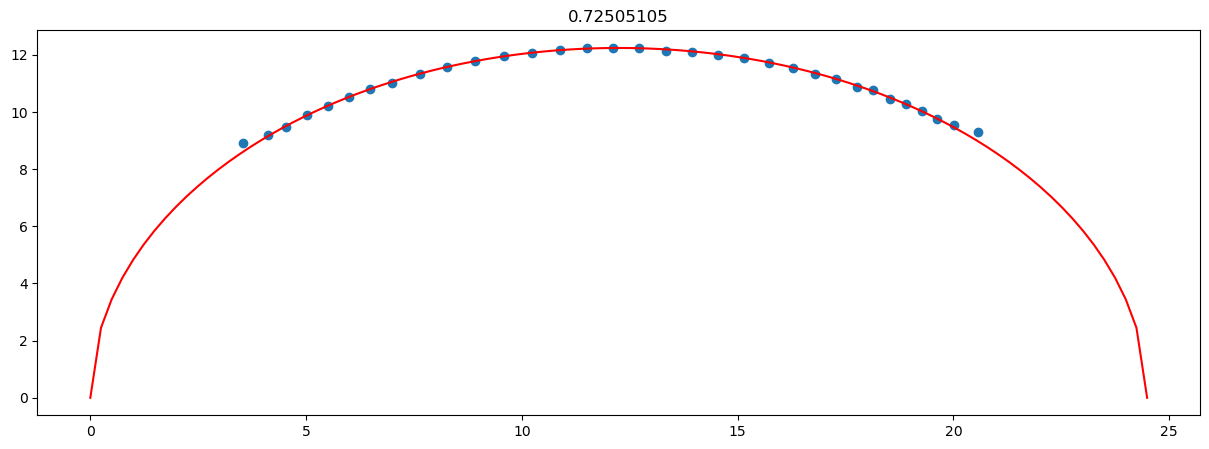

tensor(19.0966, dtype=torch.float64, grad_fn=<AddBackward0>)


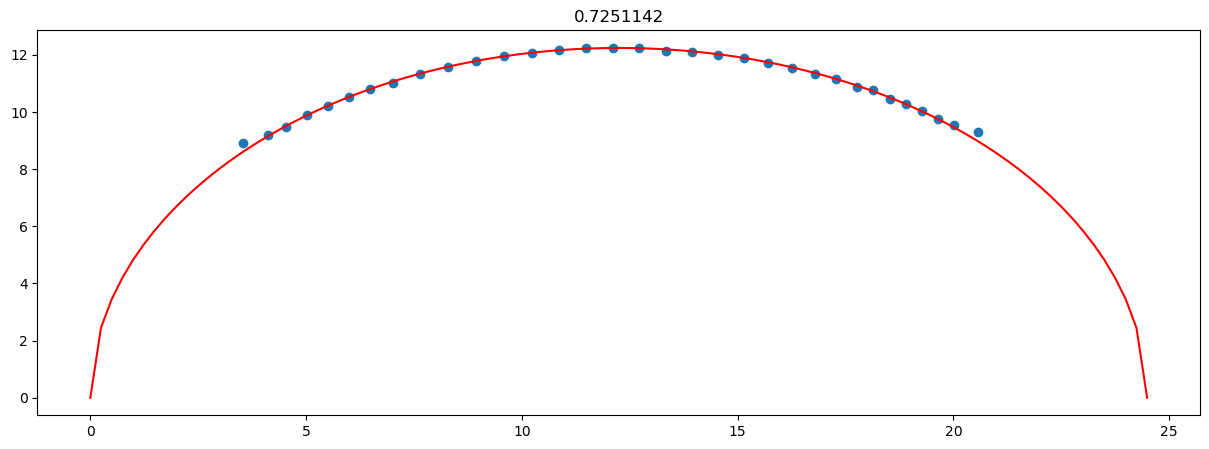

tensor(19.0965, dtype=torch.float64, grad_fn=<AddBackward0>)


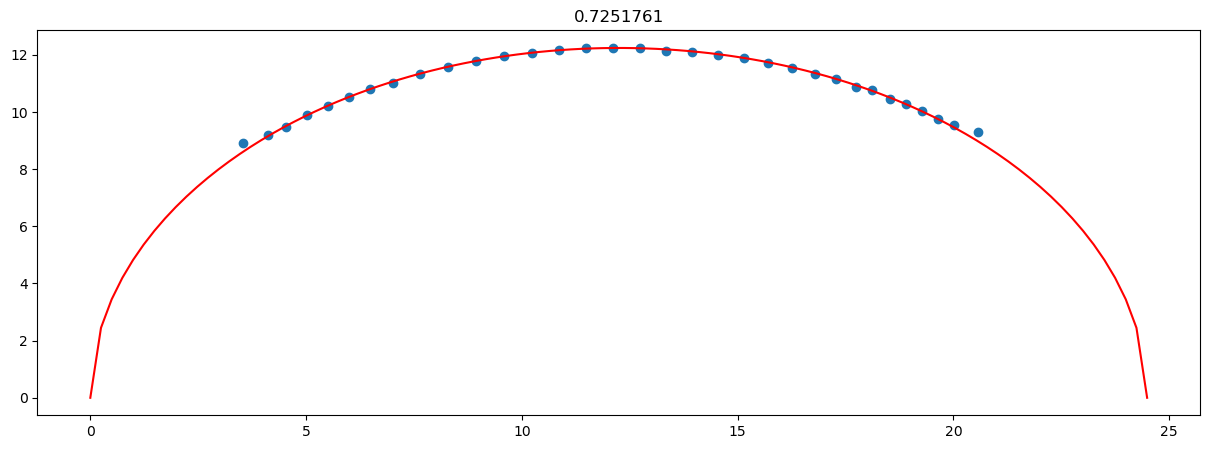

tensor(19.0964, dtype=torch.float64, grad_fn=<AddBackward0>)


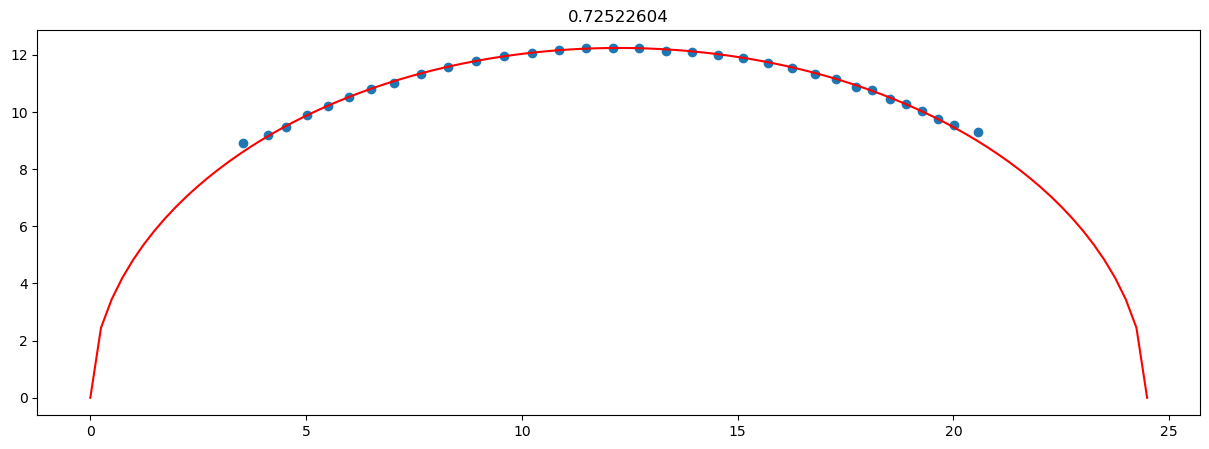

tensor(19.0965, dtype=torch.float64, grad_fn=<AddBackward0>)


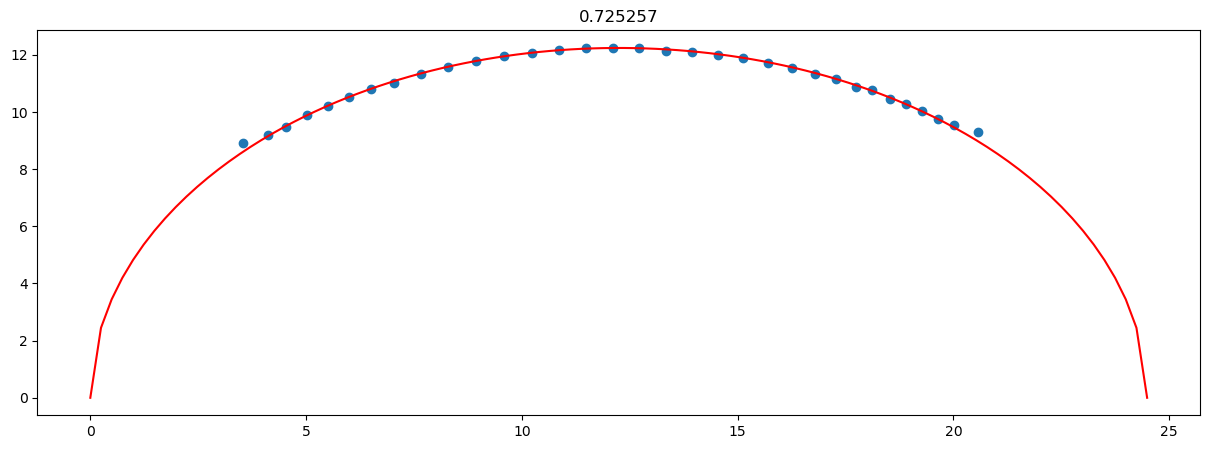

tensor(19.0966, dtype=torch.float64, grad_fn=<AddBackward0>)


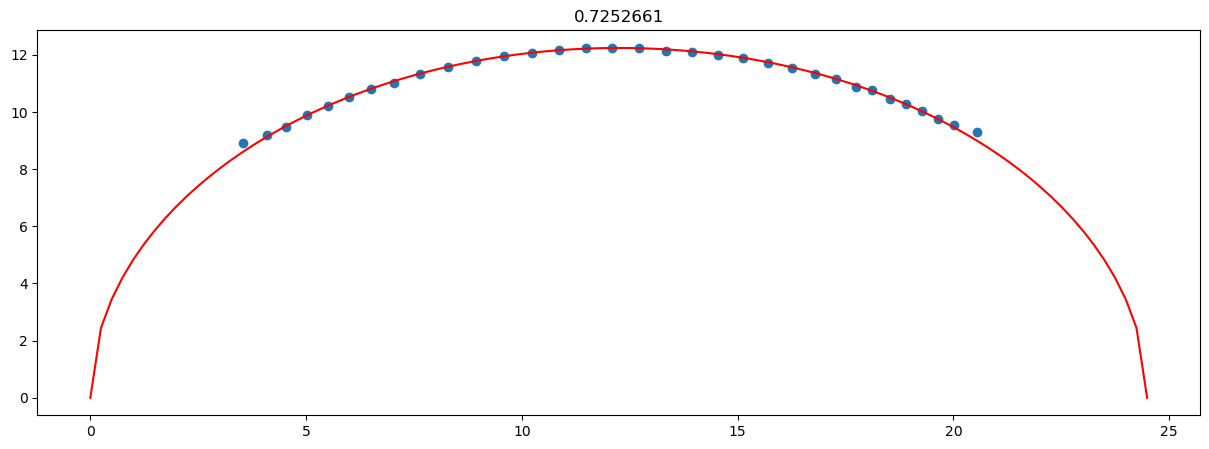

tensor(19.0966, dtype=torch.float64, grad_fn=<AddBackward0>)


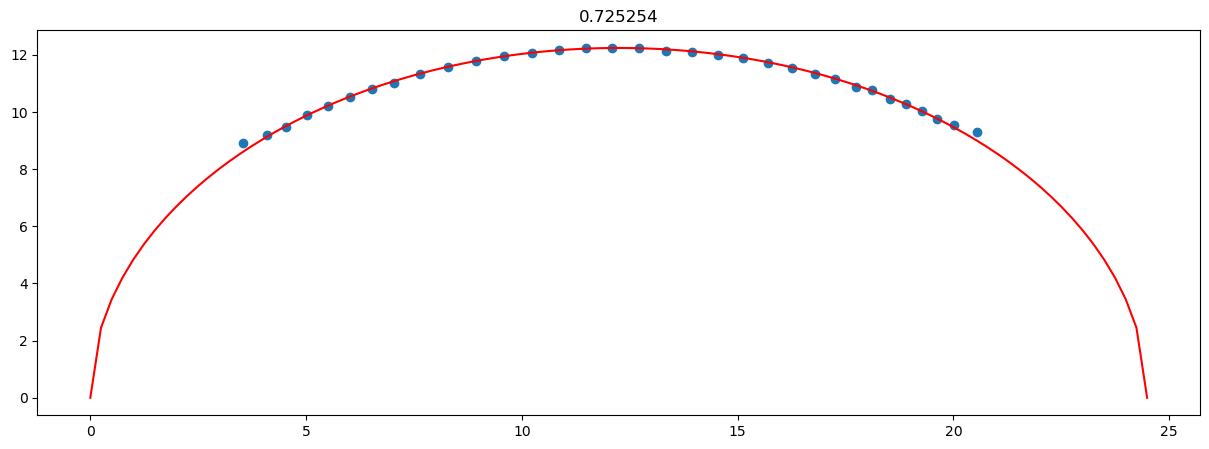

tensor(19.0964, dtype=torch.float64, grad_fn=<AddBackward0>)


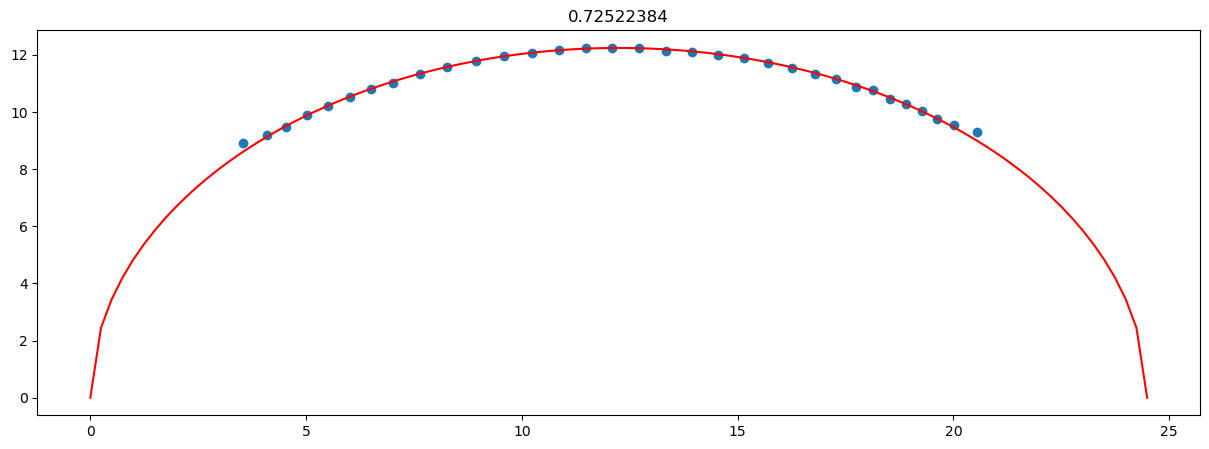

tensor(19.0962, dtype=torch.float64, grad_fn=<AddBackward0>)


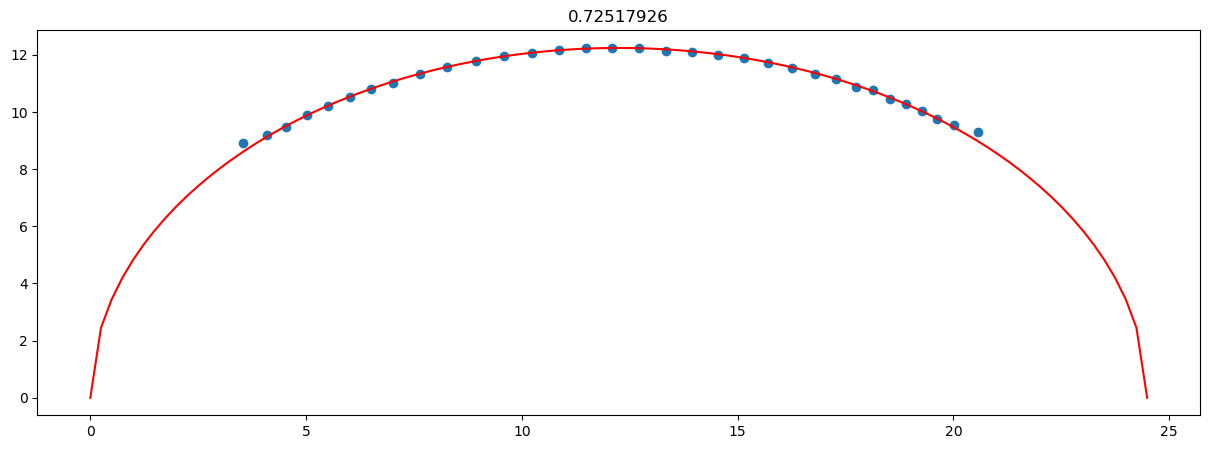

tensor(19.0959, dtype=torch.float64, grad_fn=<AddBackward0>)


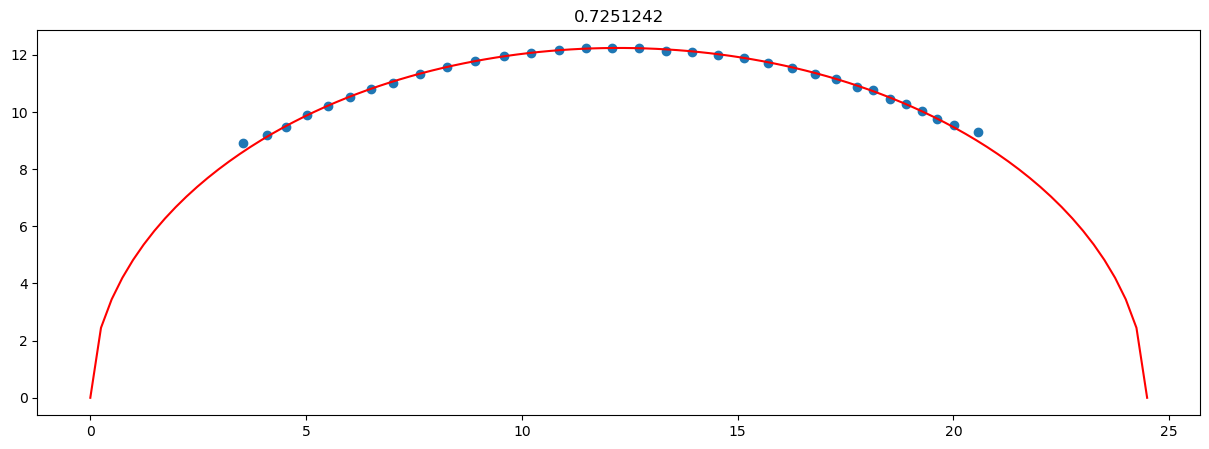

tensor(19.0958, dtype=torch.float64, grad_fn=<AddBackward0>)


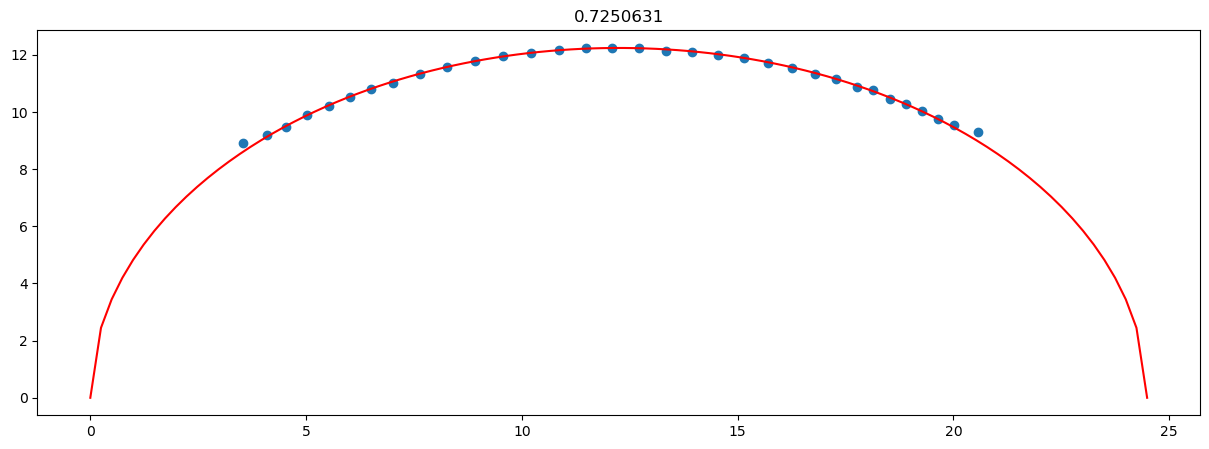

tensor(19.0958, dtype=torch.float64, grad_fn=<AddBackward0>)


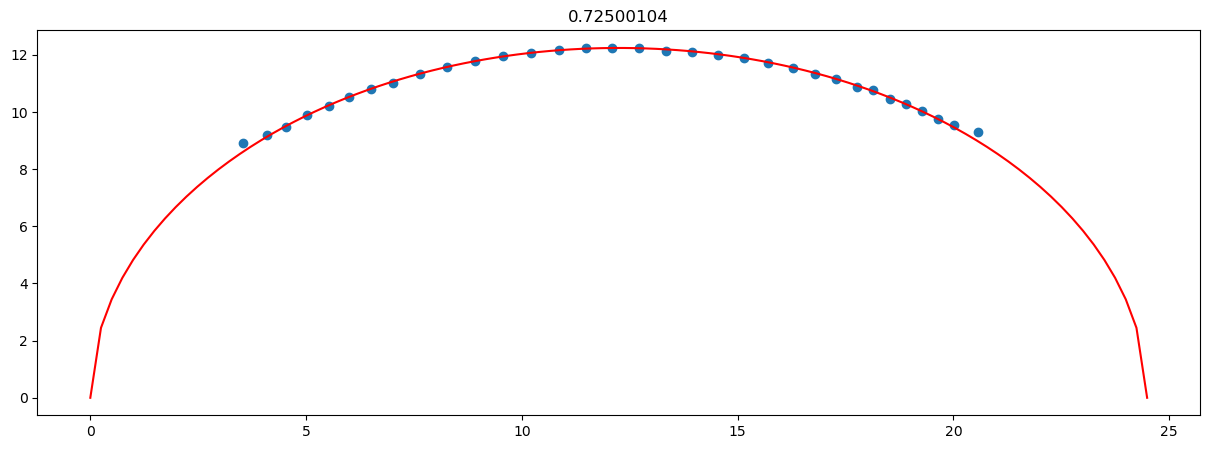

tensor(19.0959, dtype=torch.float64, grad_fn=<AddBackward0>)


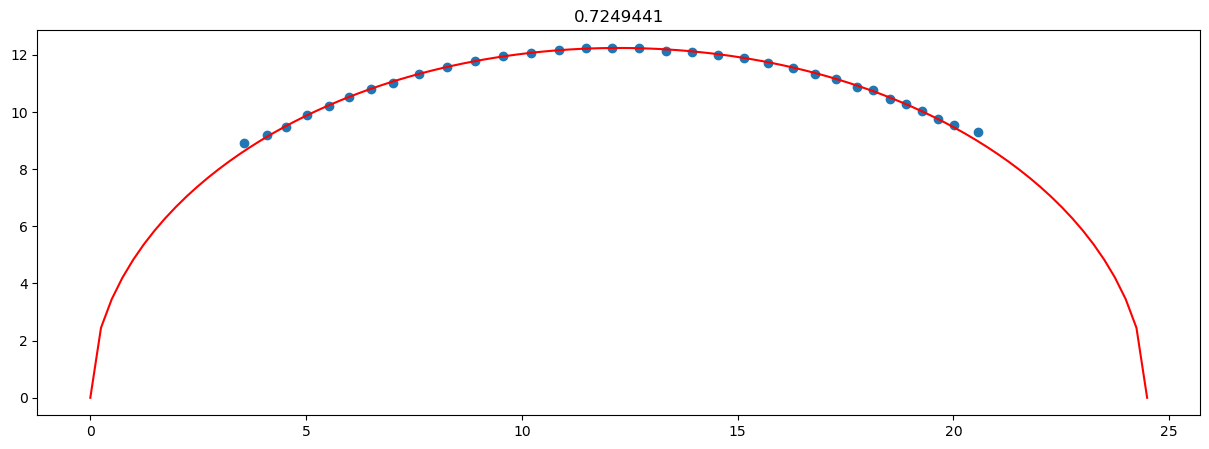

tensor(19.0958, dtype=torch.float64, grad_fn=<AddBackward0>)


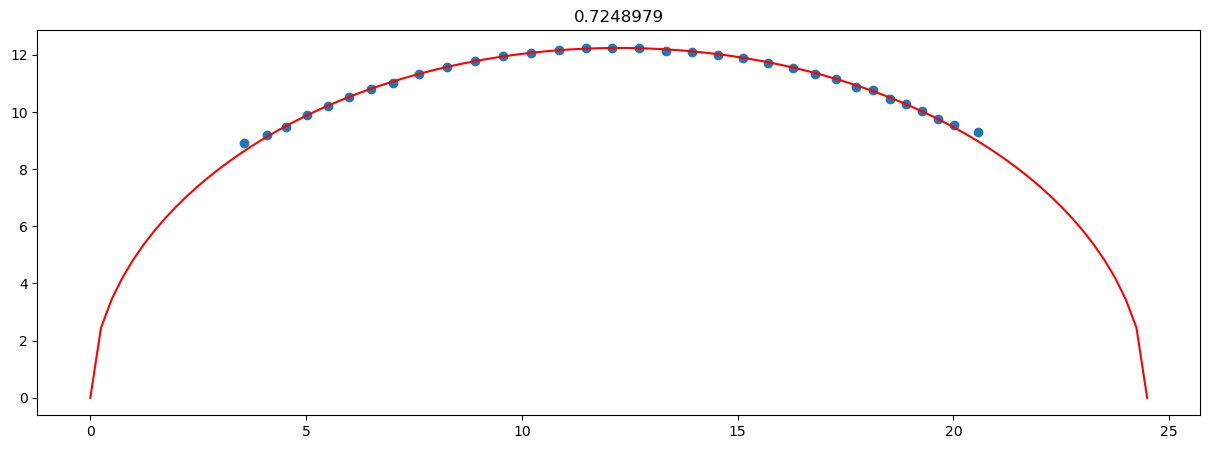

tensor(19.0958, dtype=torch.float64, grad_fn=<AddBackward0>)


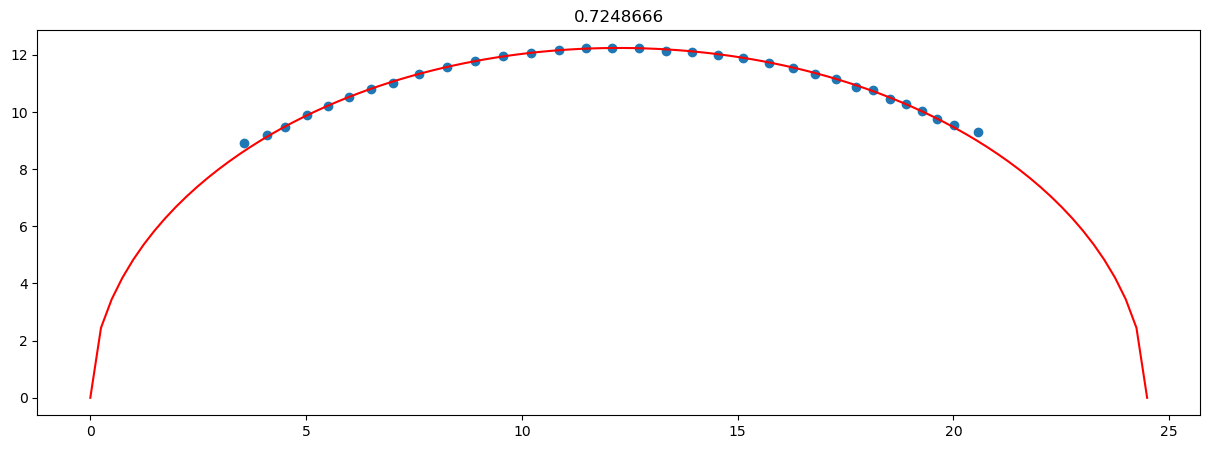

tensor(19.0957, dtype=torch.float64, grad_fn=<AddBackward0>)


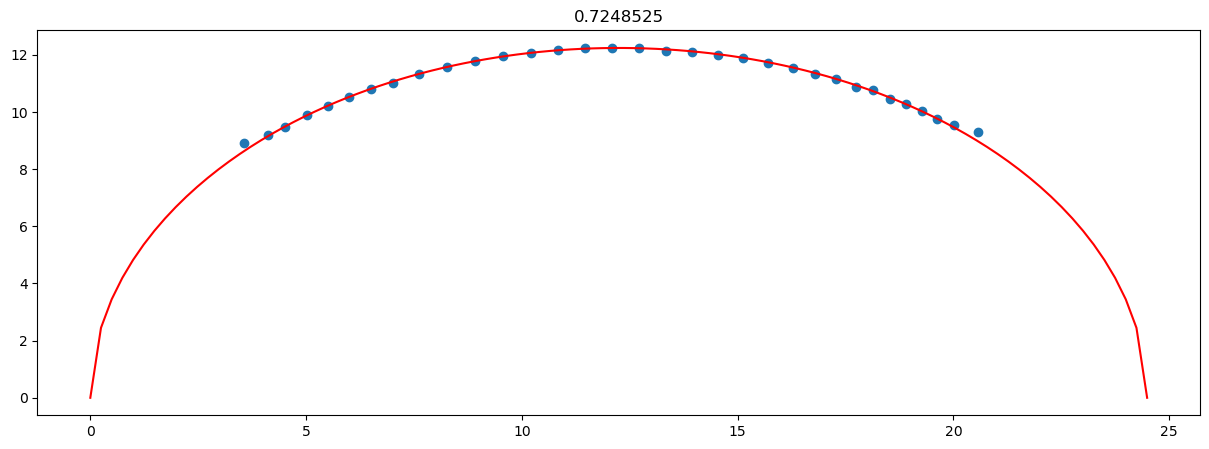

tensor(19.0957, dtype=torch.float64, grad_fn=<AddBackward0>)


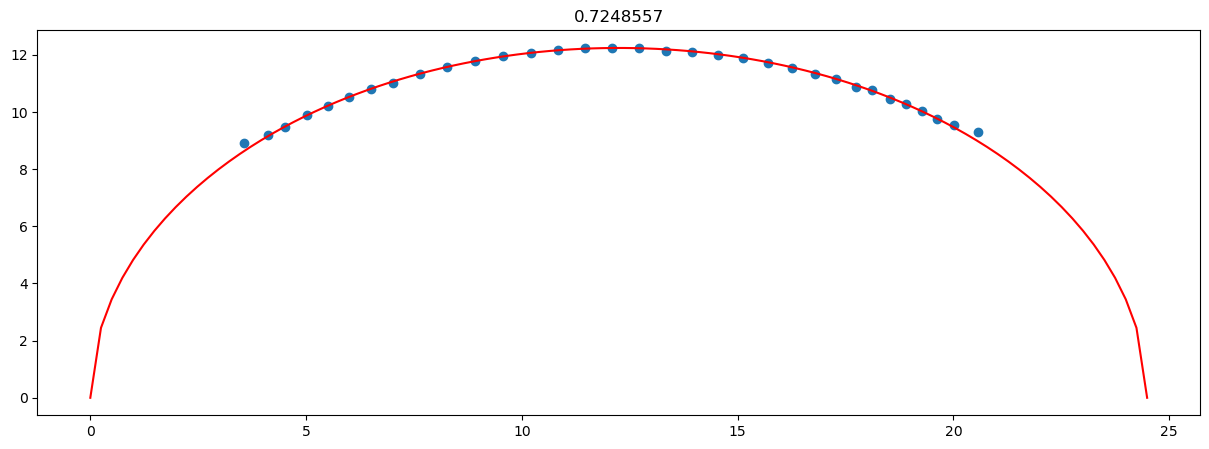

tensor(19.0957, dtype=torch.float64, grad_fn=<AddBackward0>)


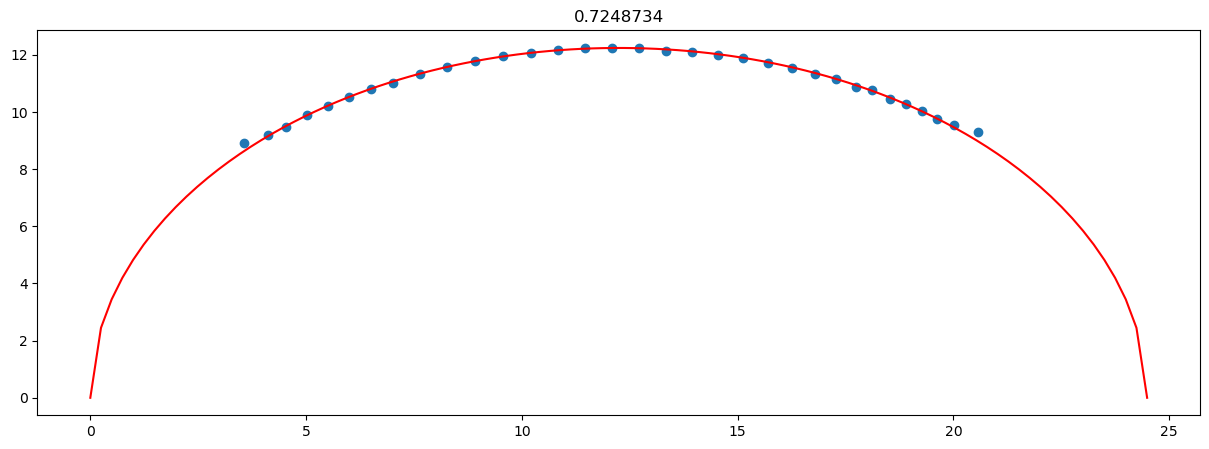

tensor(19.0957, dtype=torch.float64, grad_fn=<AddBackward0>)


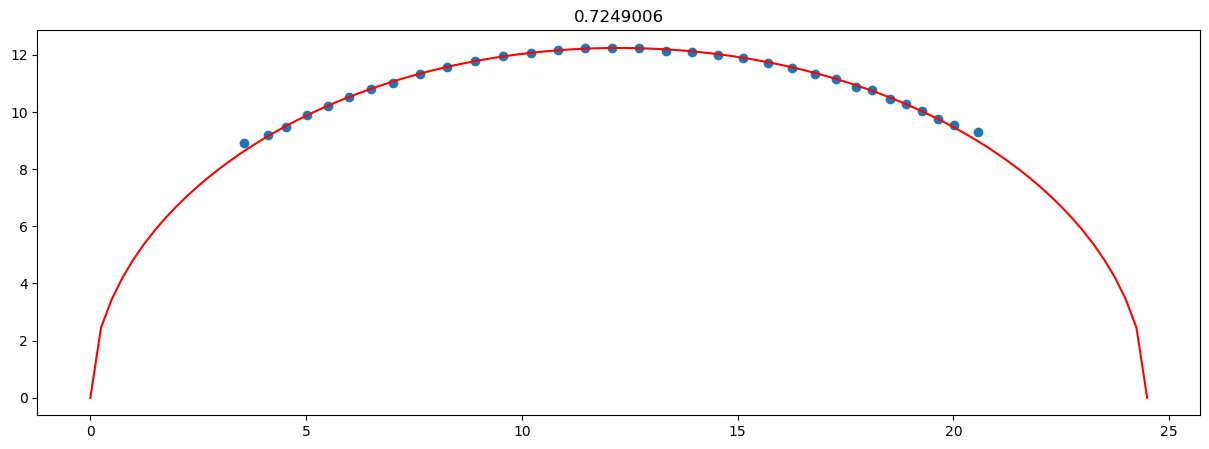

tensor(19.0958, dtype=torch.float64, grad_fn=<AddBackward0>)


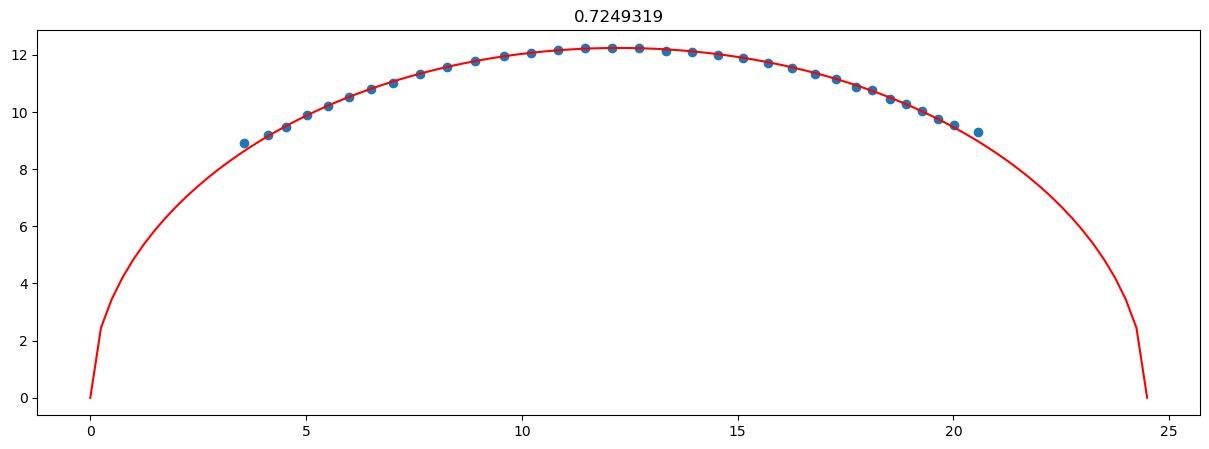

tensor(19.0958, dtype=torch.float64, grad_fn=<AddBackward0>)


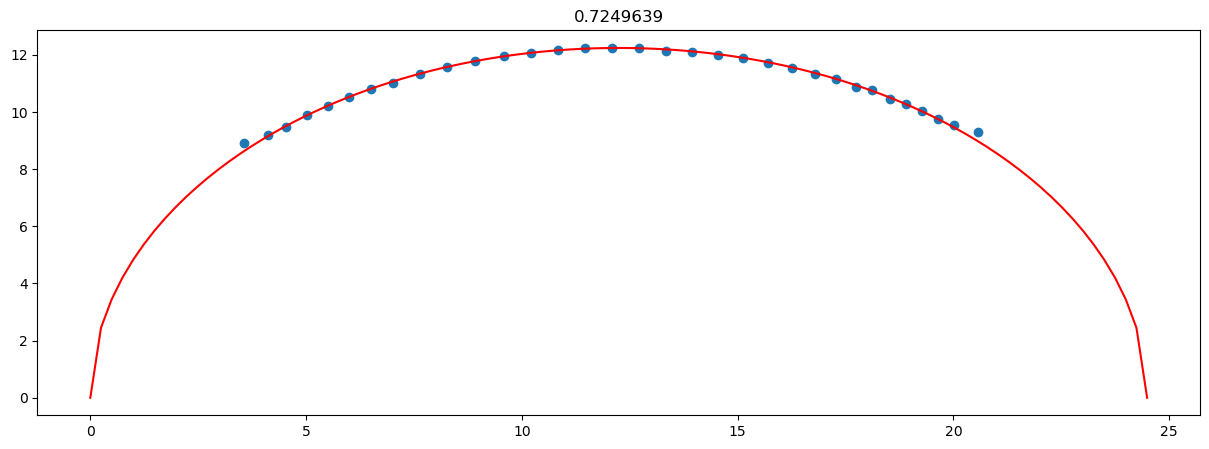

tensor(19.0957, dtype=torch.float64, grad_fn=<AddBackward0>)


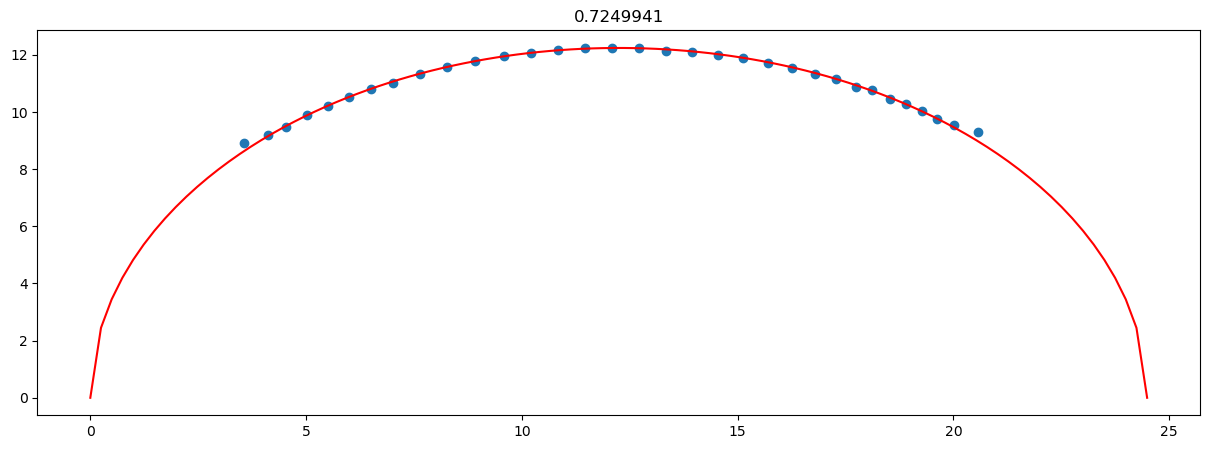

tensor(19.0957, dtype=torch.float64, grad_fn=<AddBackward0>)


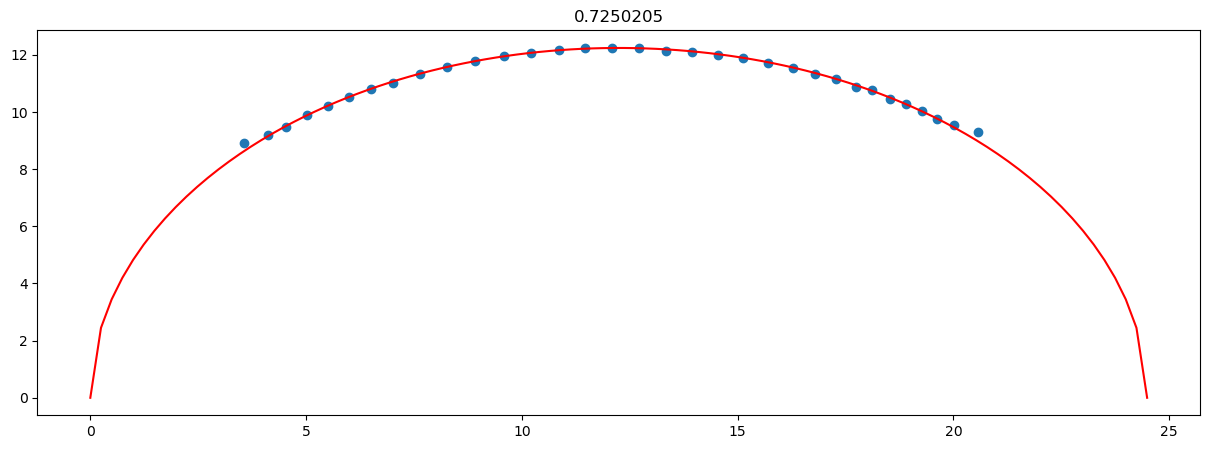

tensor(19.0957, dtype=torch.float64, grad_fn=<AddBackward0>)


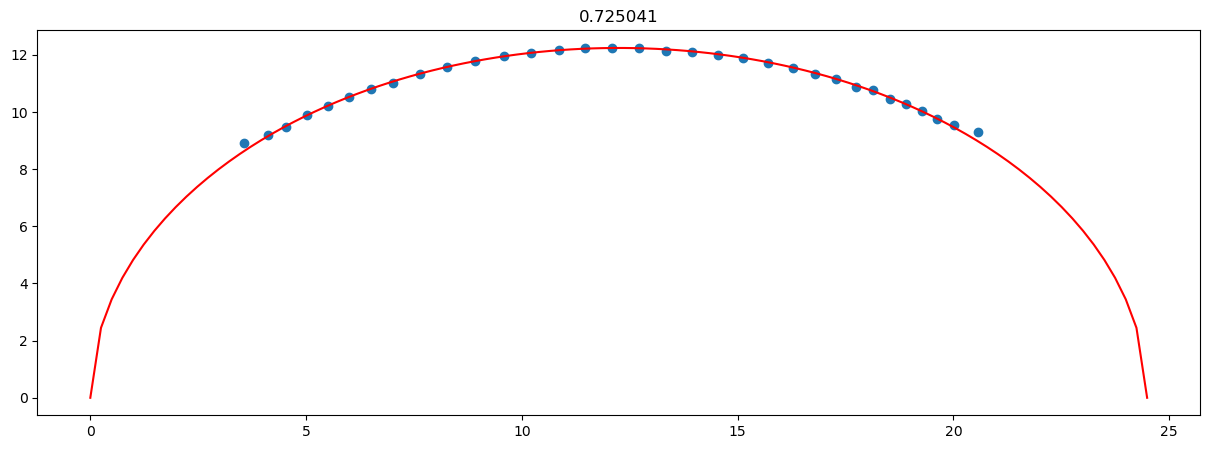

tensor(19.0957, dtype=torch.float64, grad_fn=<AddBackward0>)


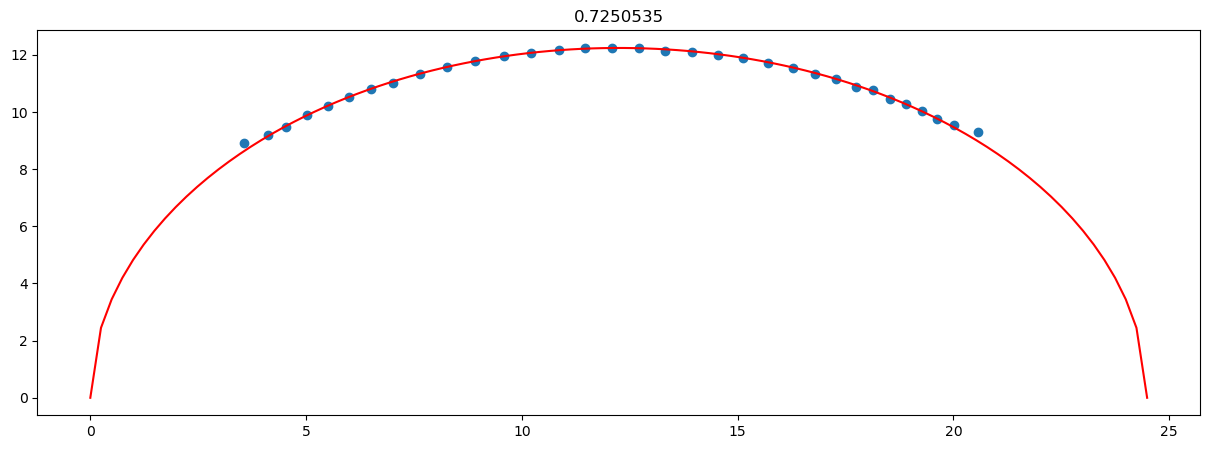

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


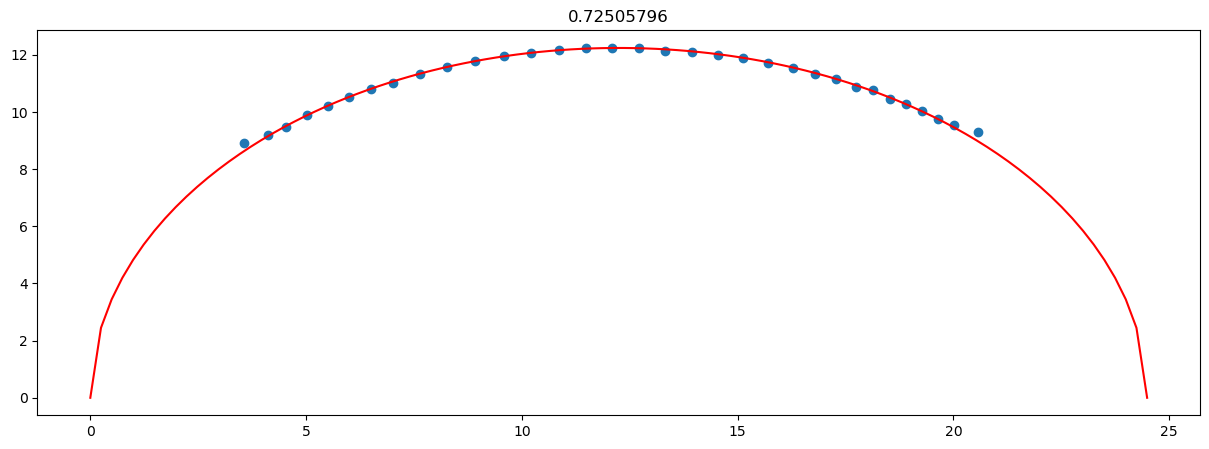

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


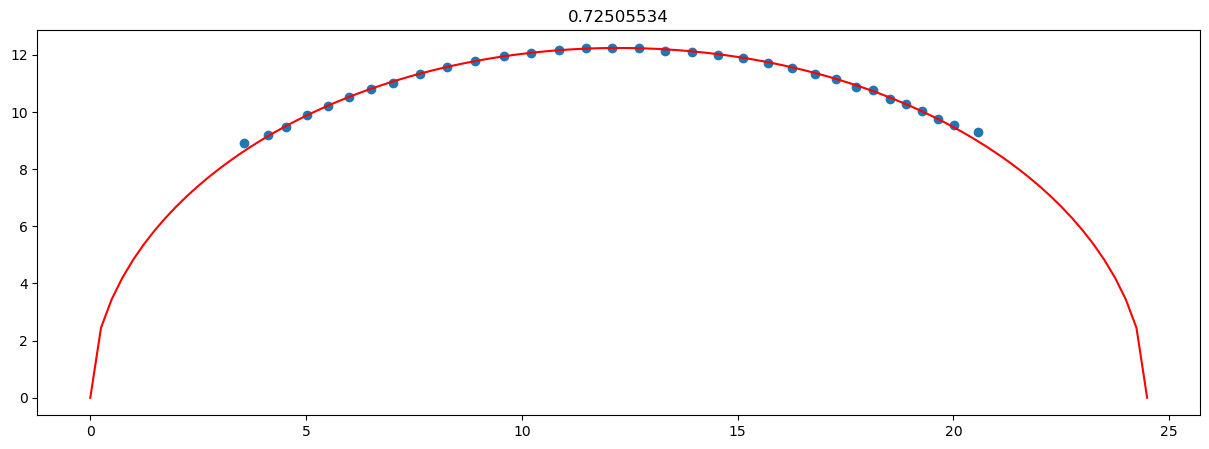

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


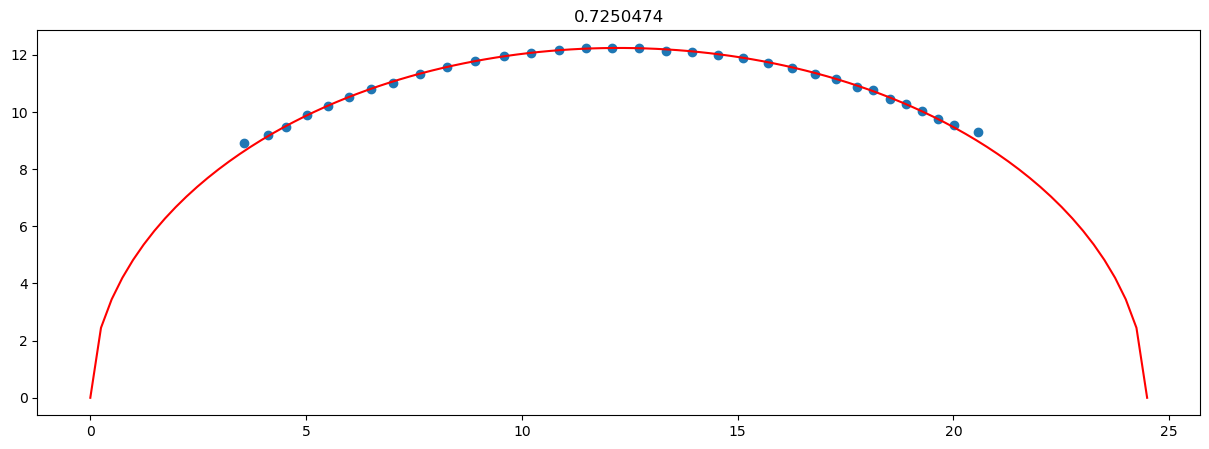

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


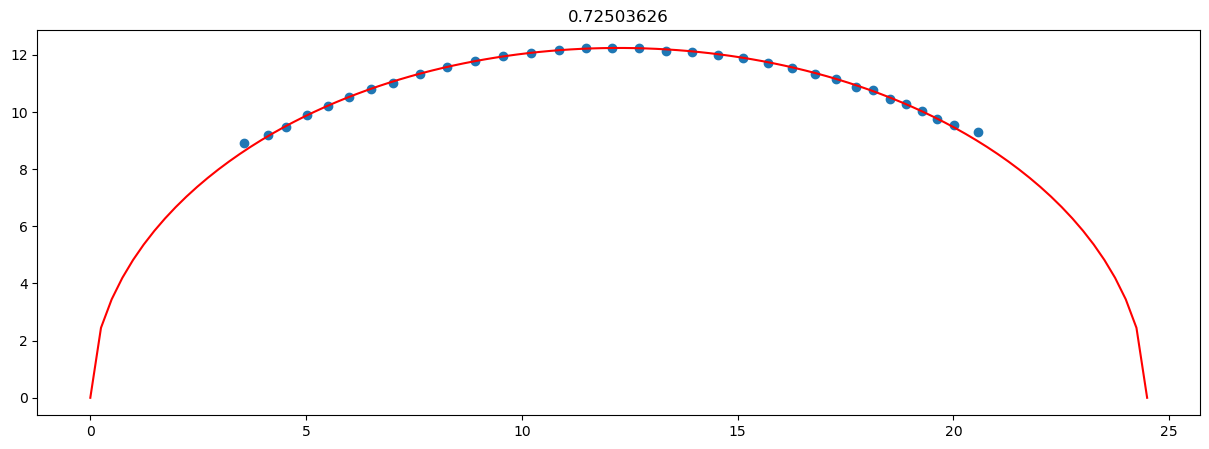

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


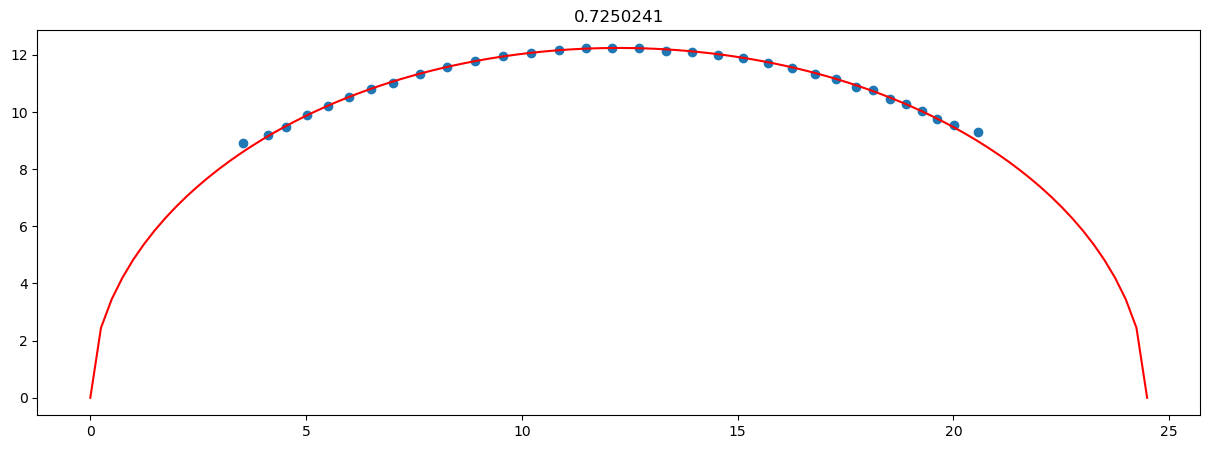

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


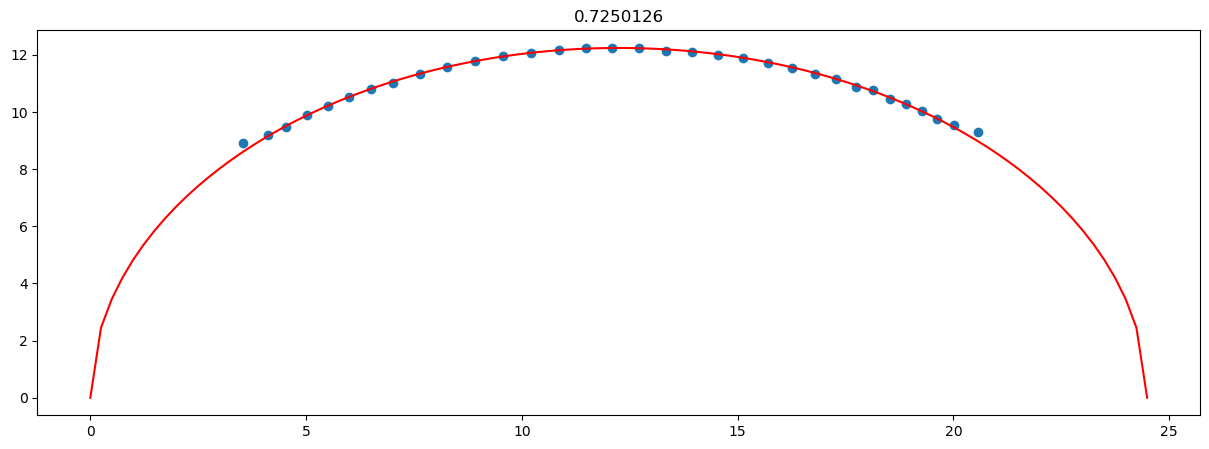

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


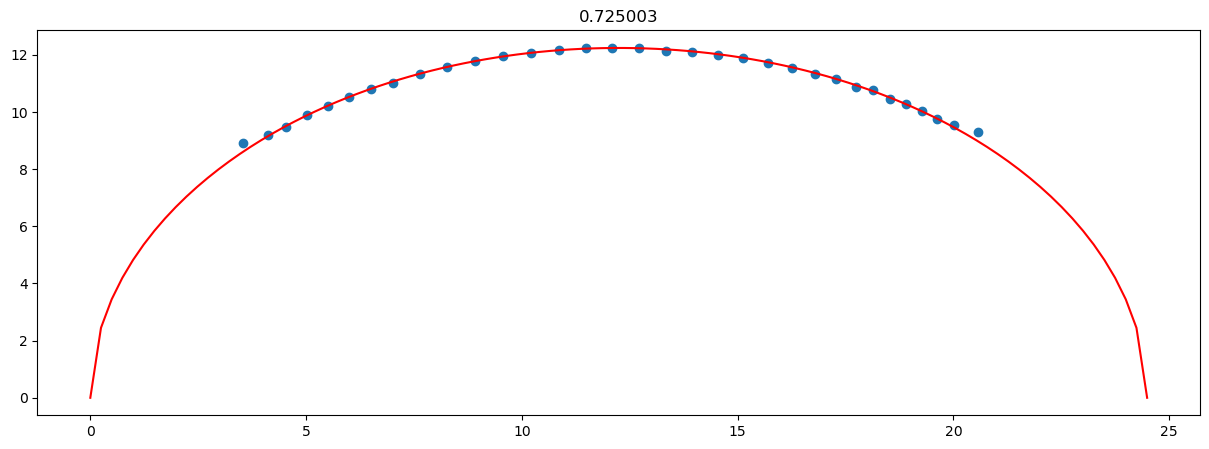

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


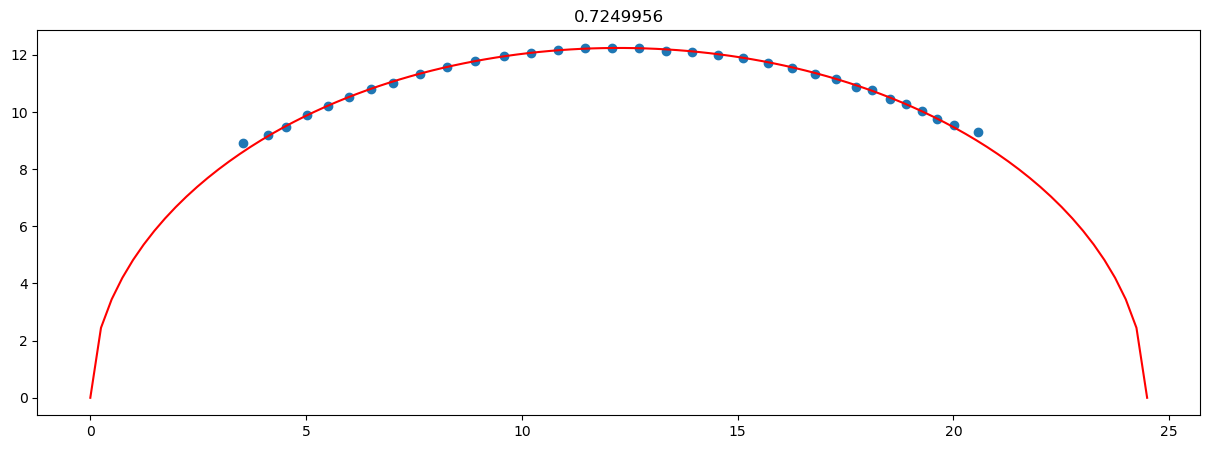

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


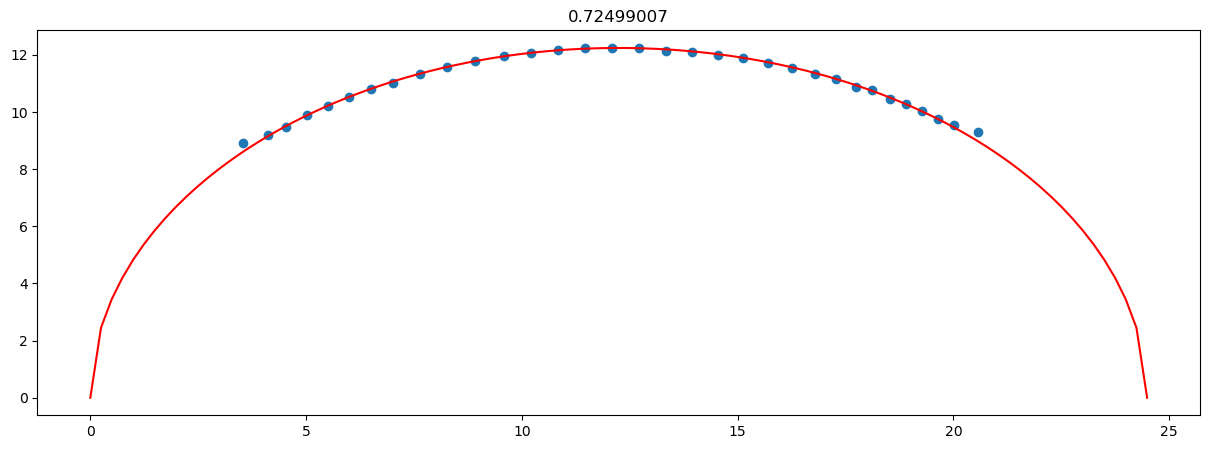

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


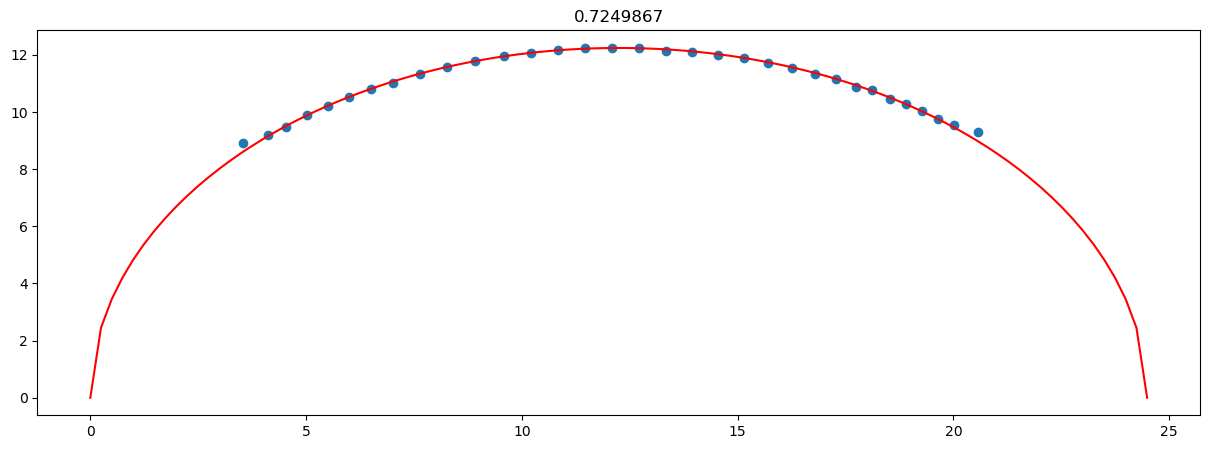

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


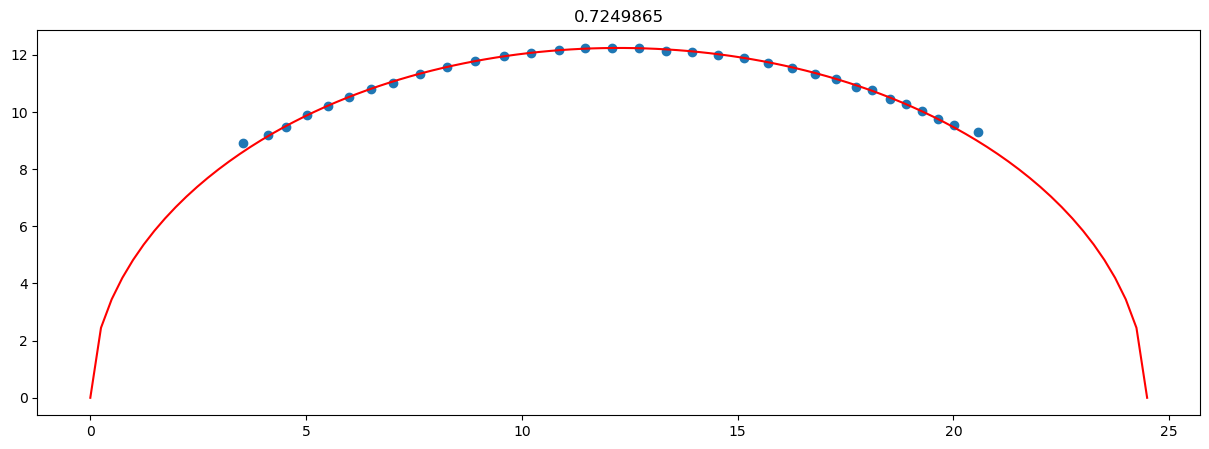

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


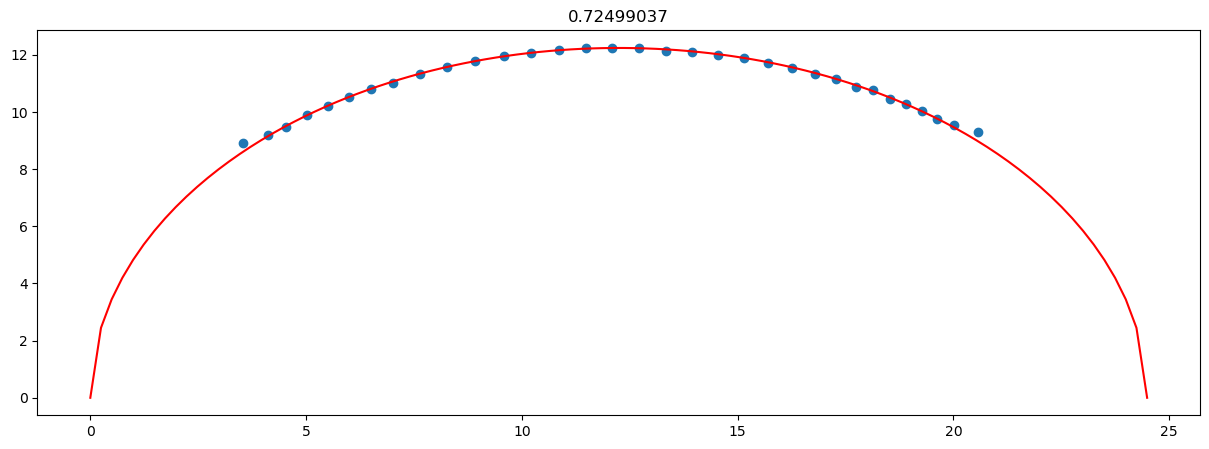

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


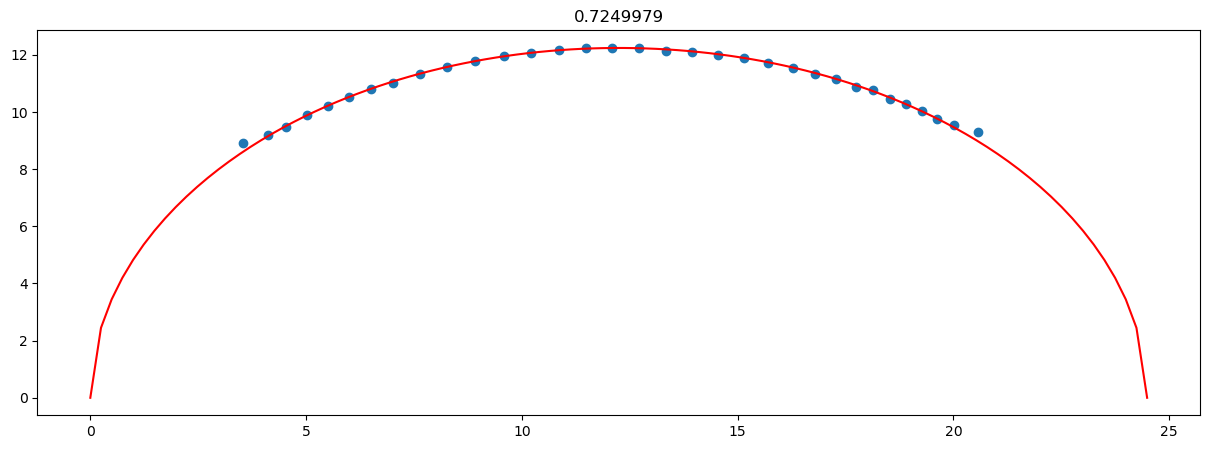

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


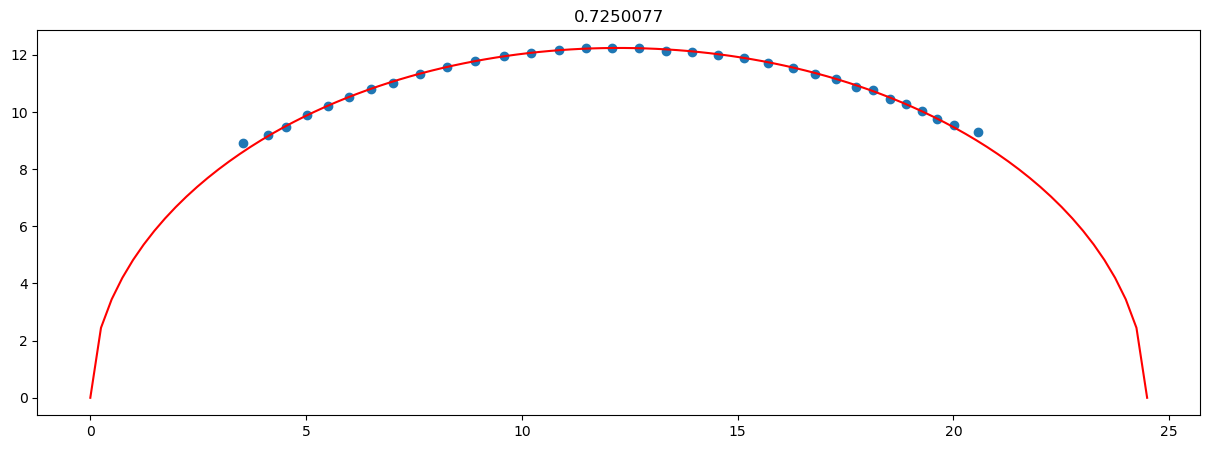

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


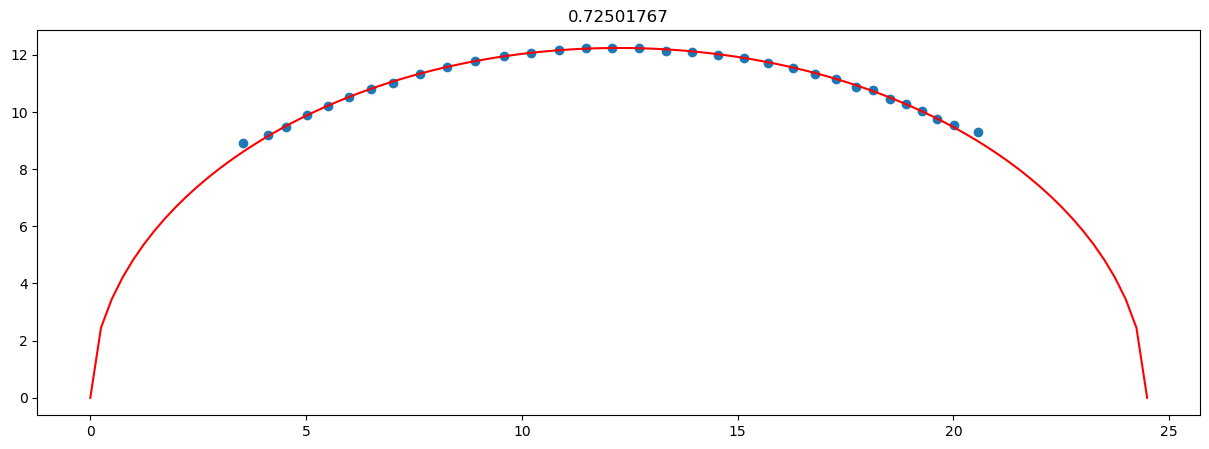

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


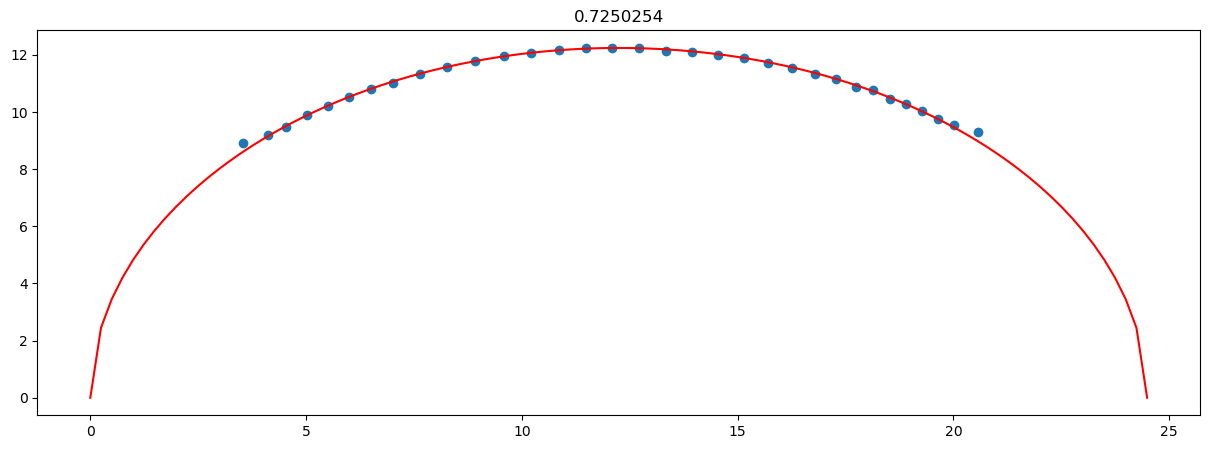

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


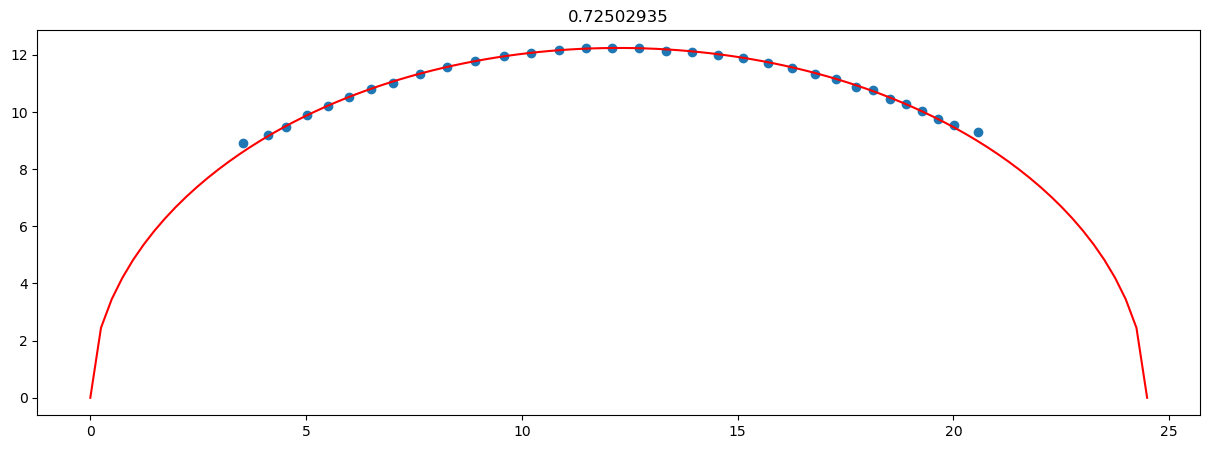

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


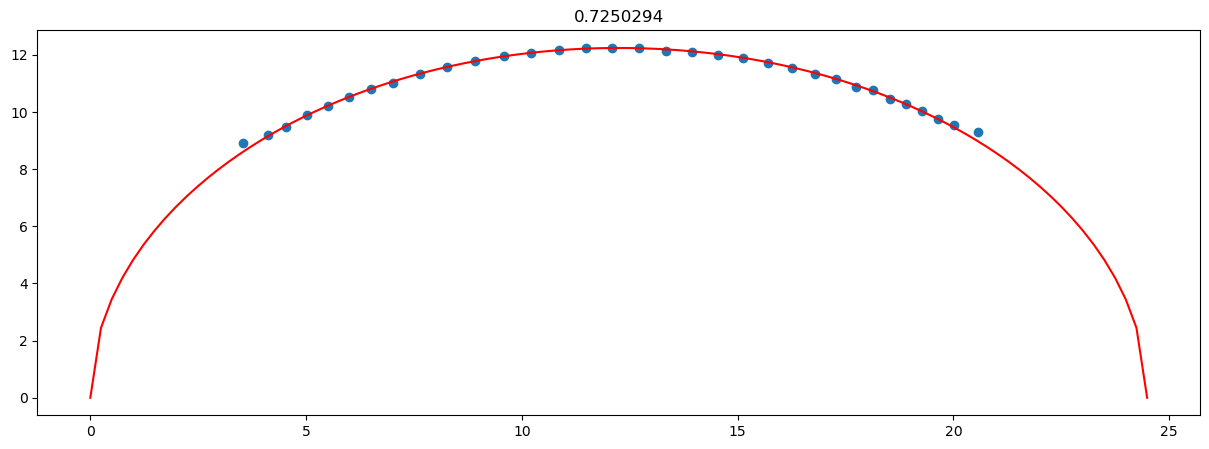

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


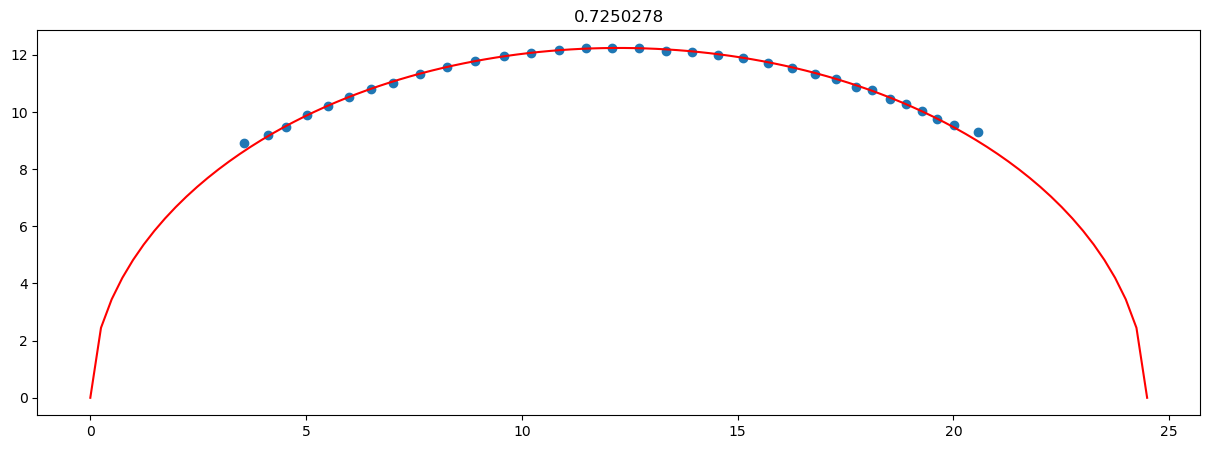

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


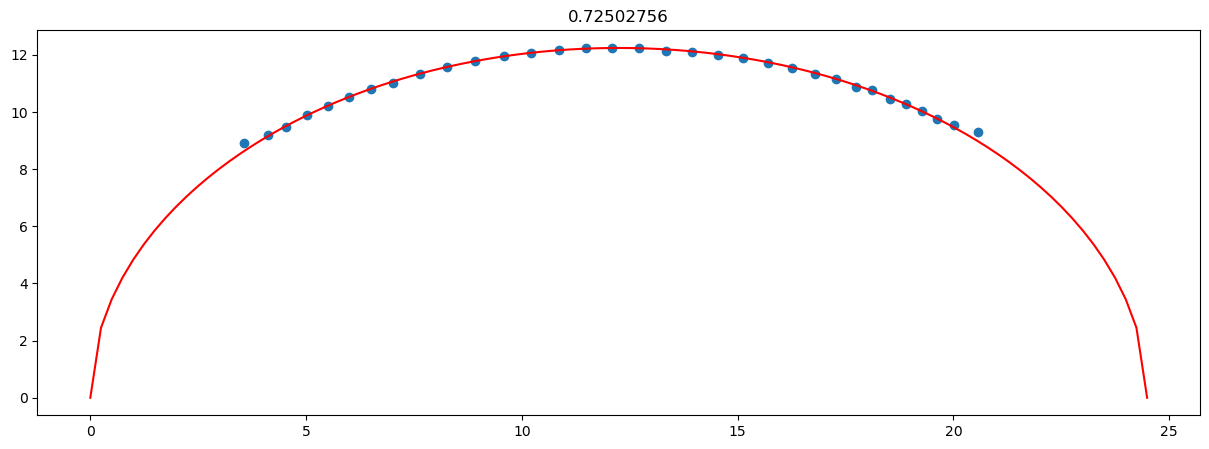

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


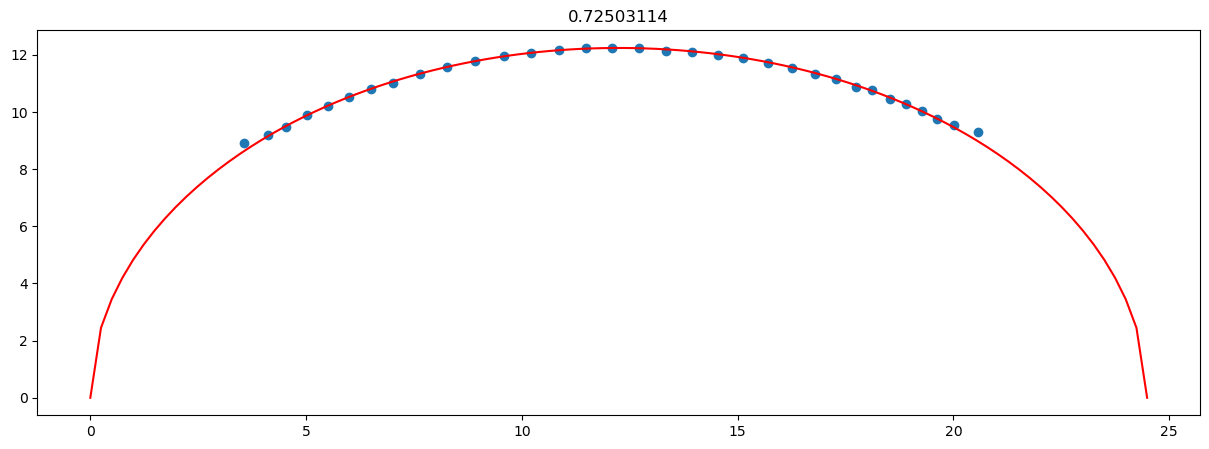

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


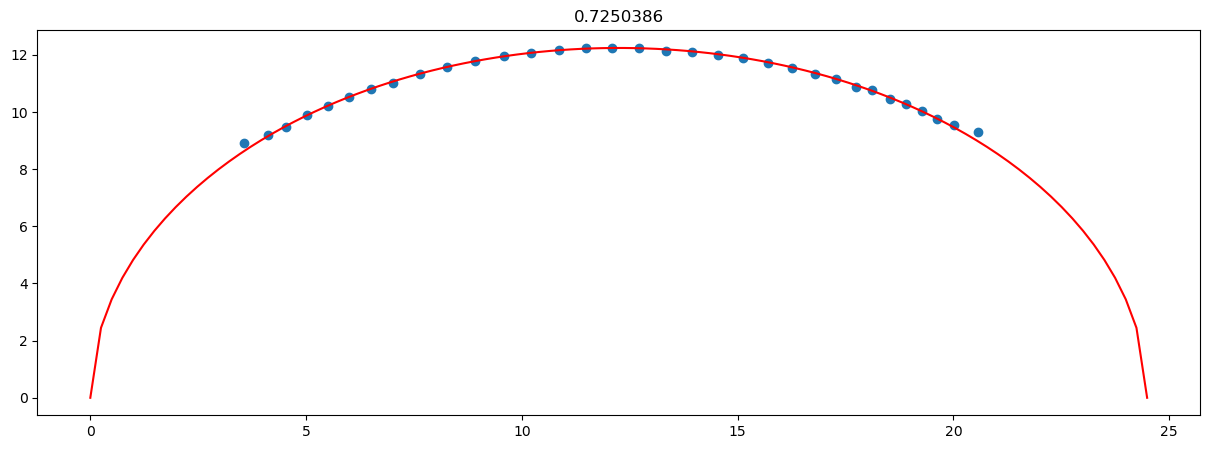

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


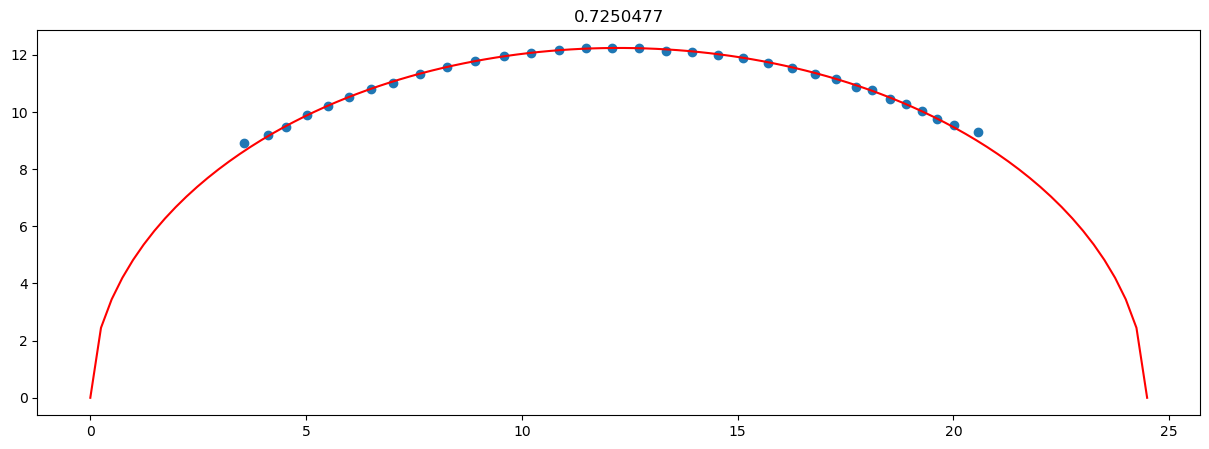

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


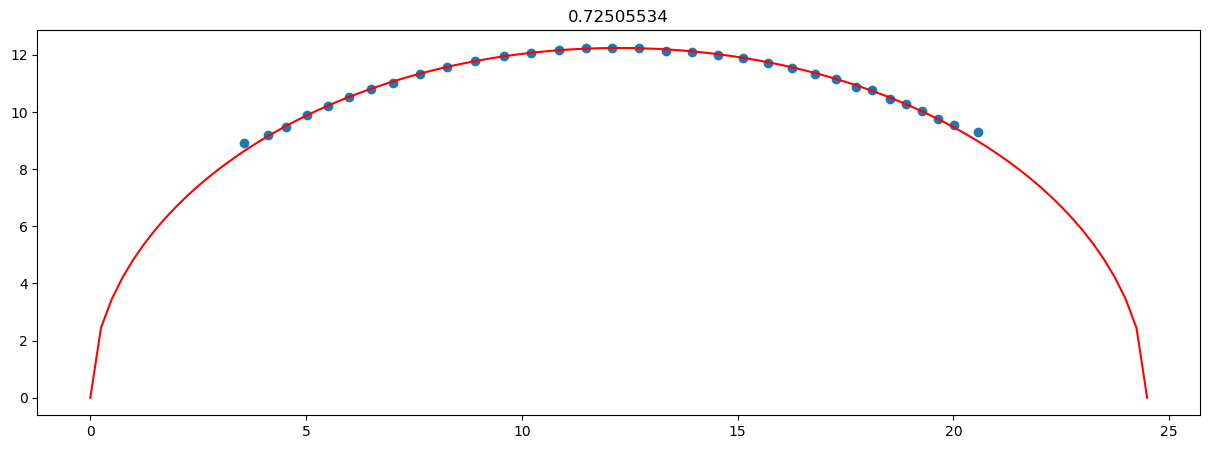

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


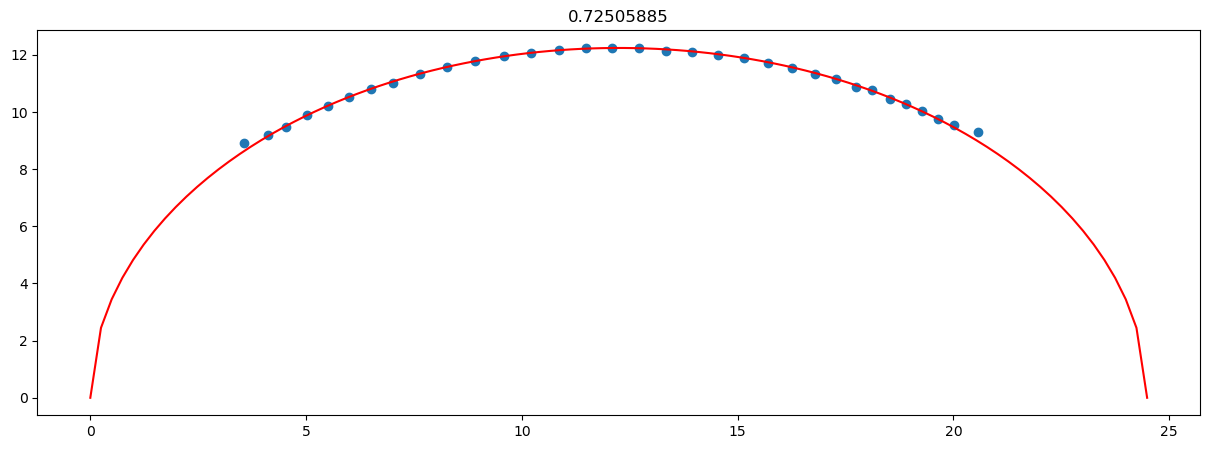

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


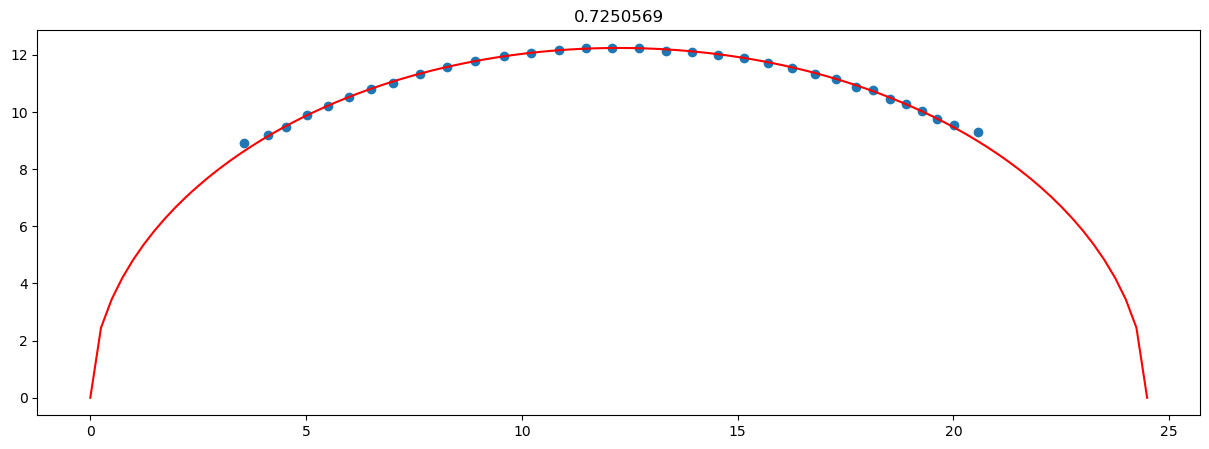

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


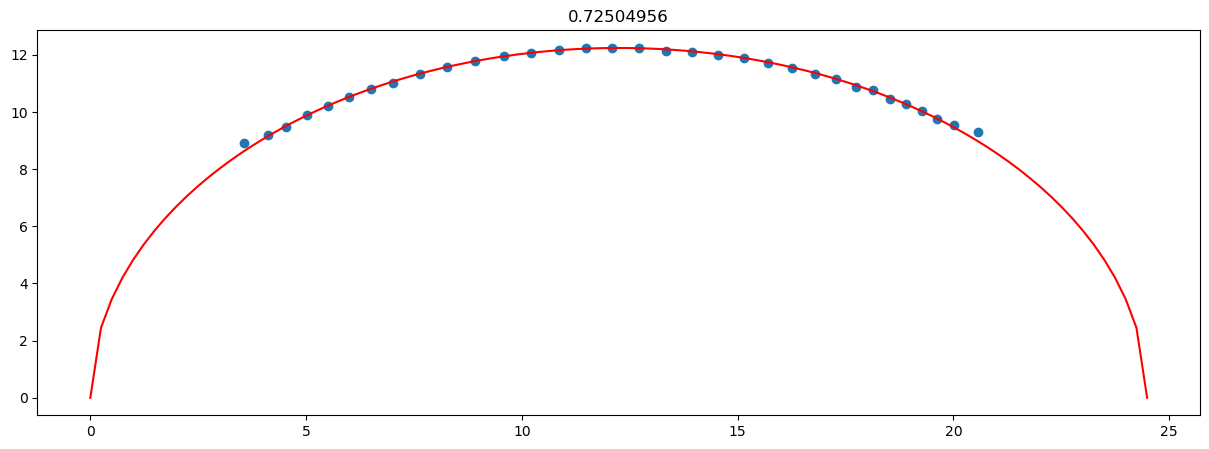

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


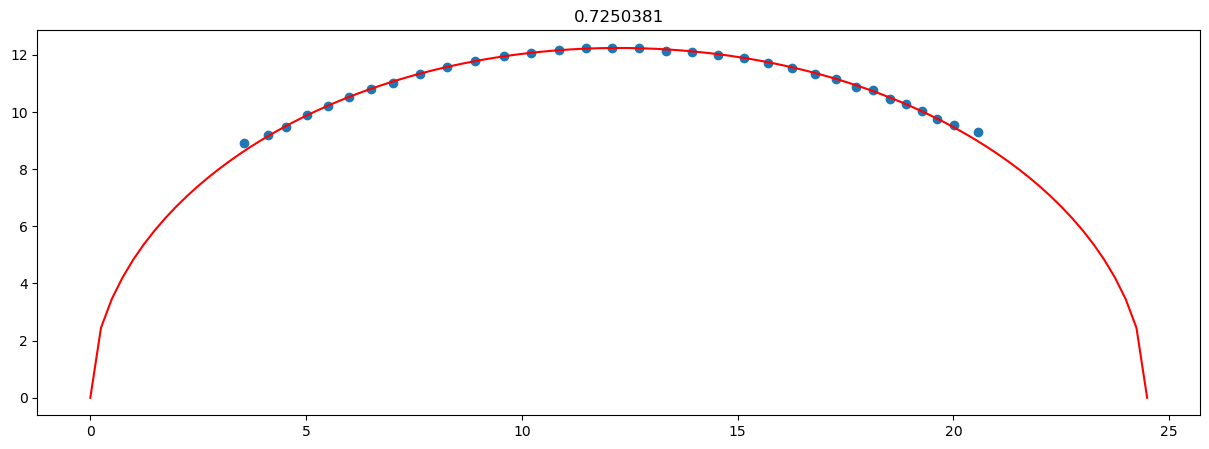

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


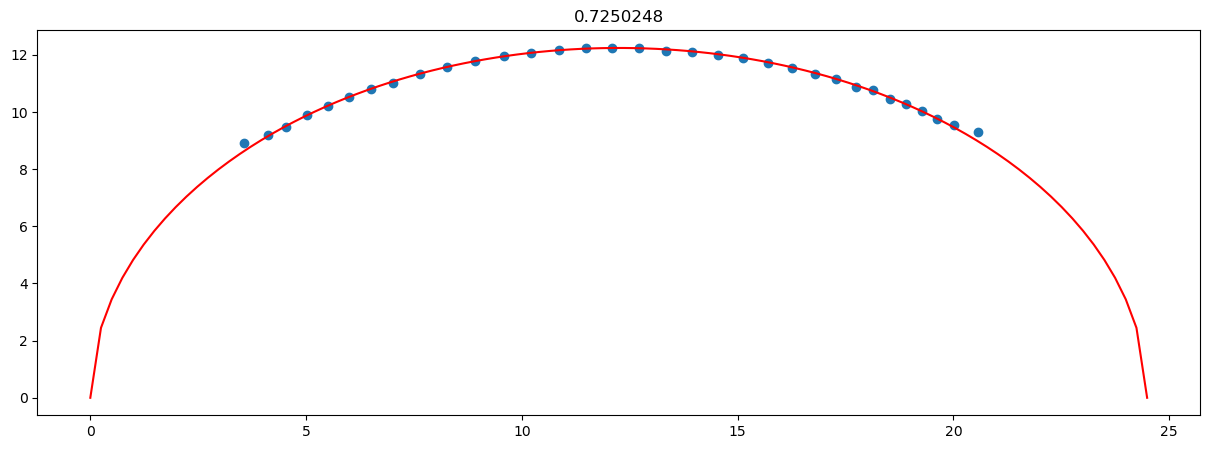

tensor(19.0956, dtype=torch.float64, grad_fn=<AddBackward0>)


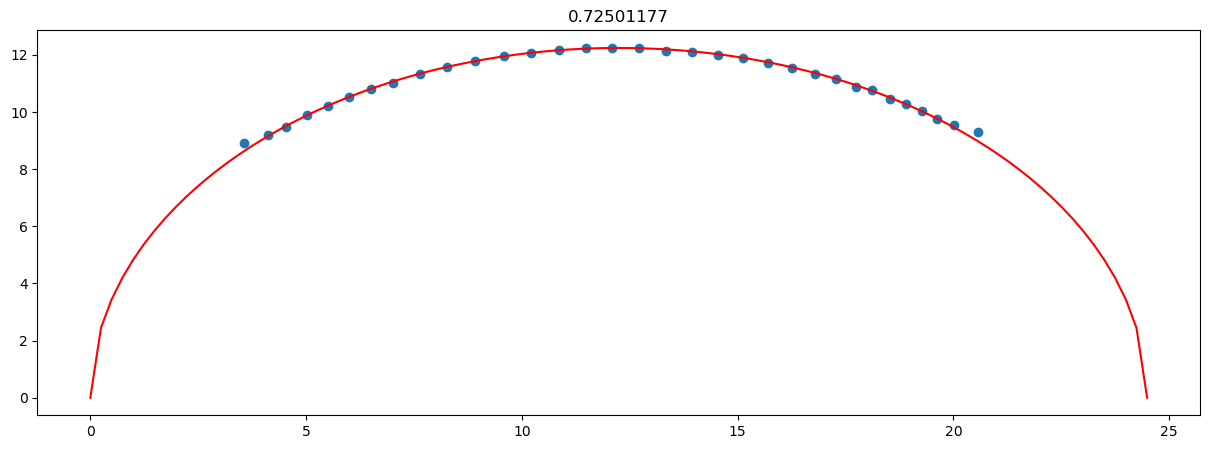

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


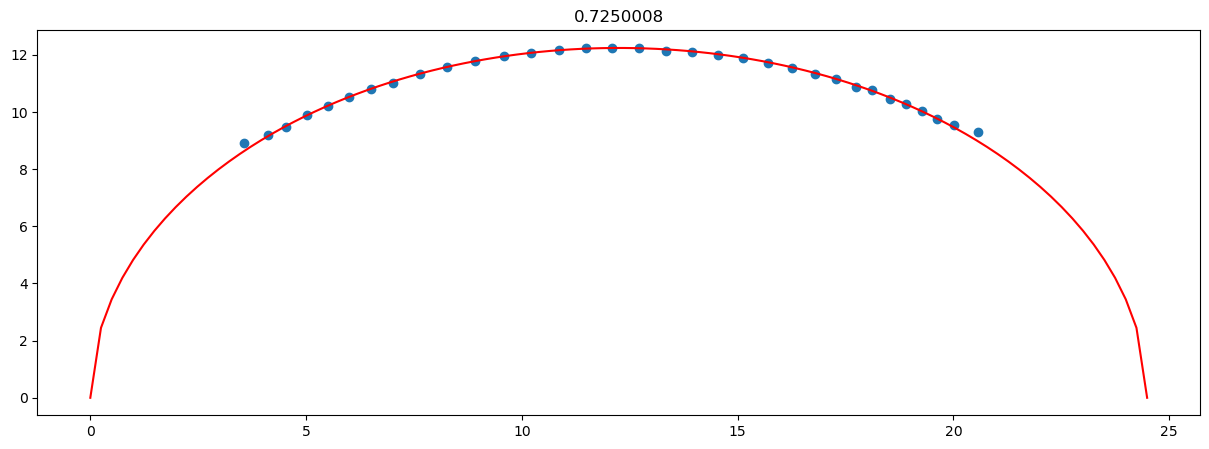

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


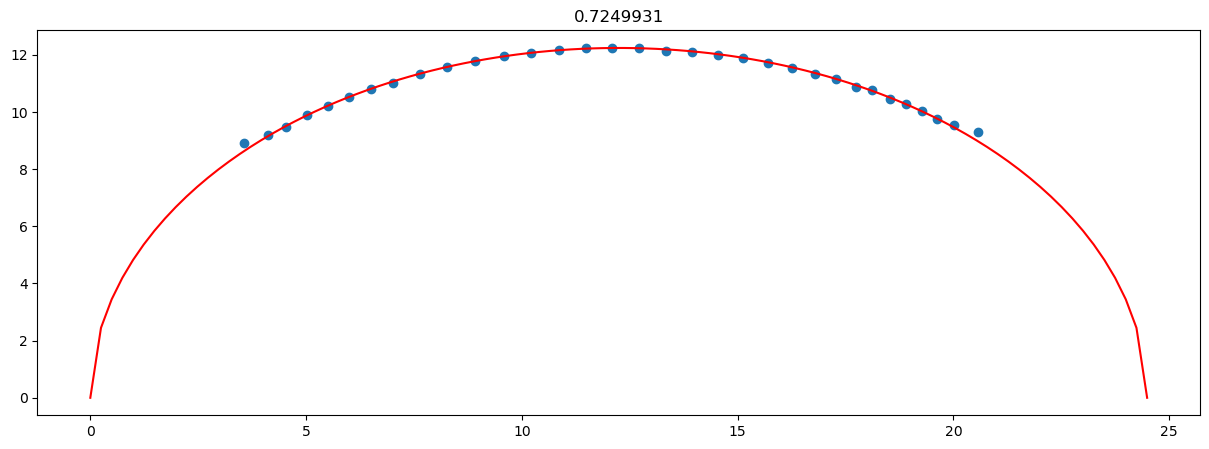

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


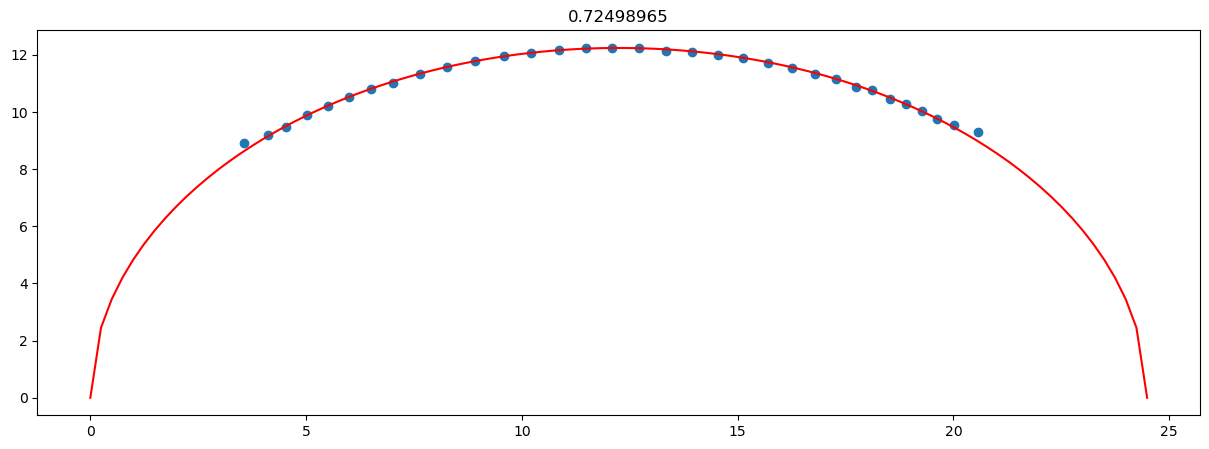

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


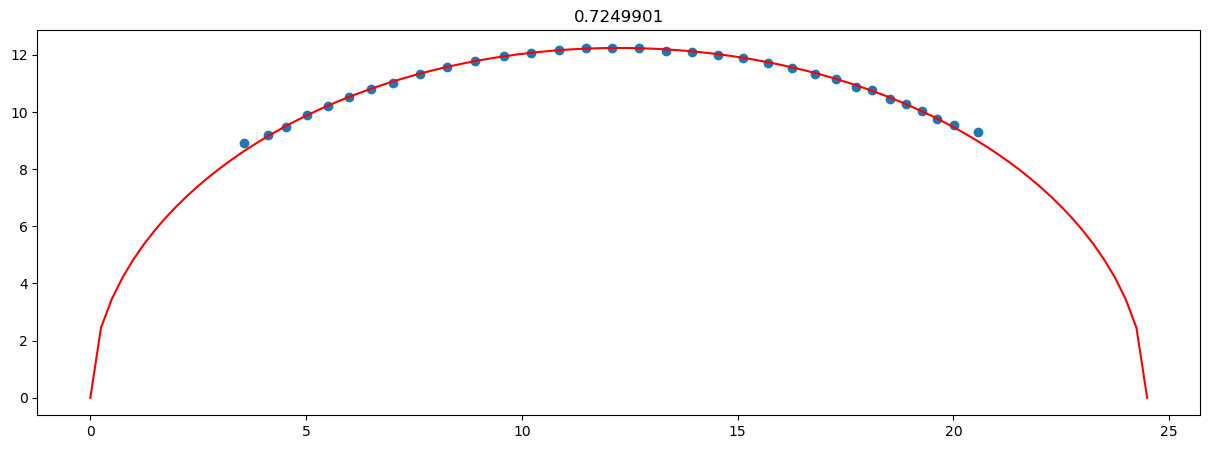

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


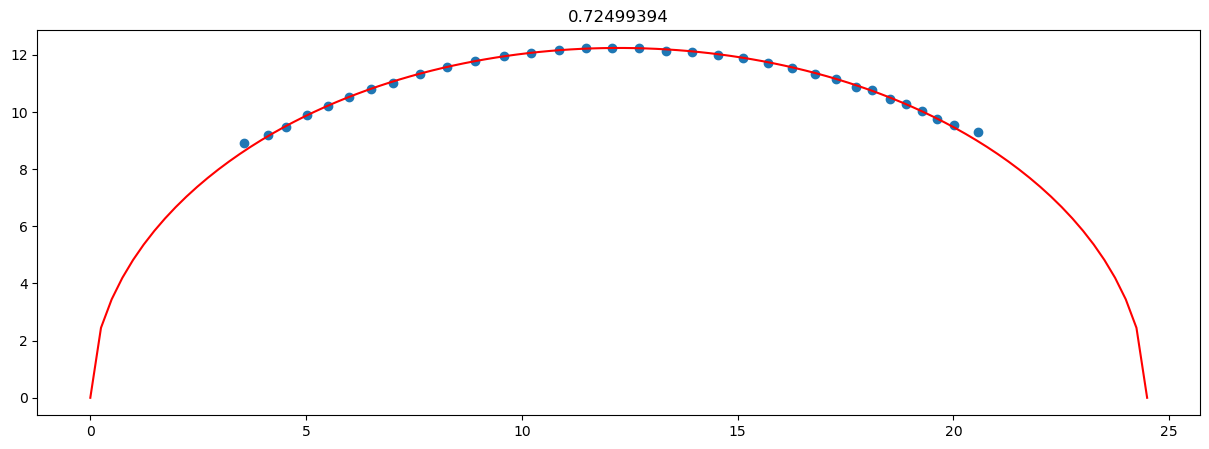

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


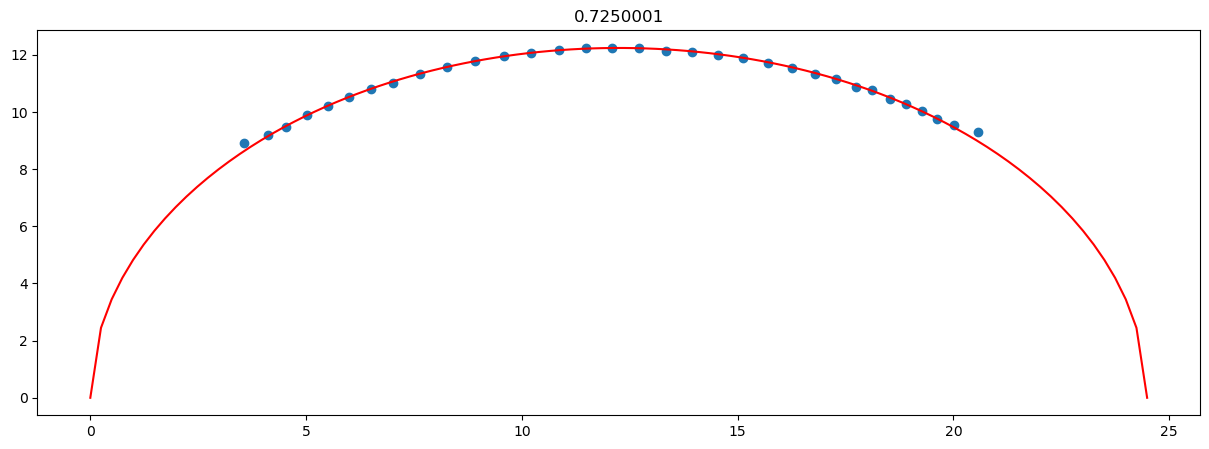

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


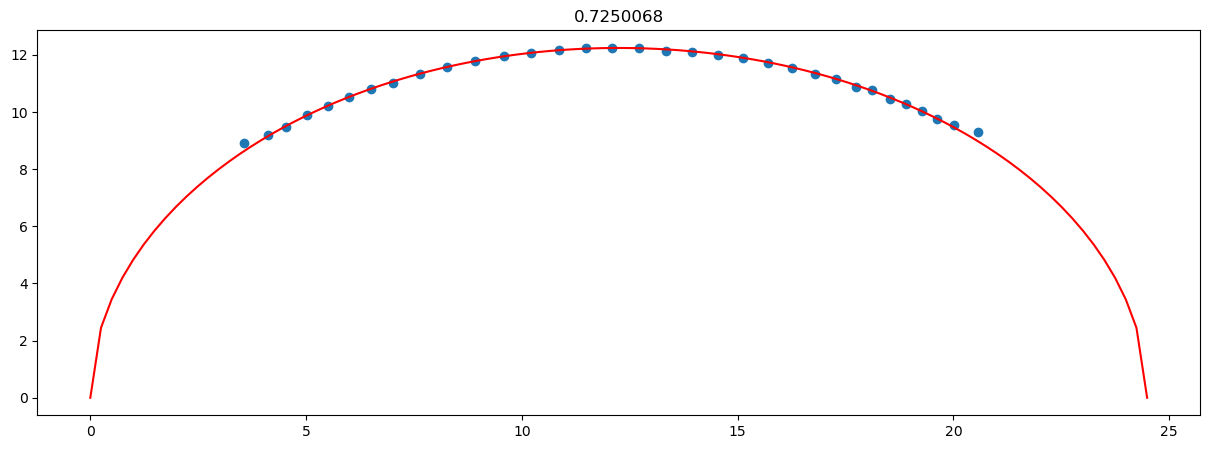

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


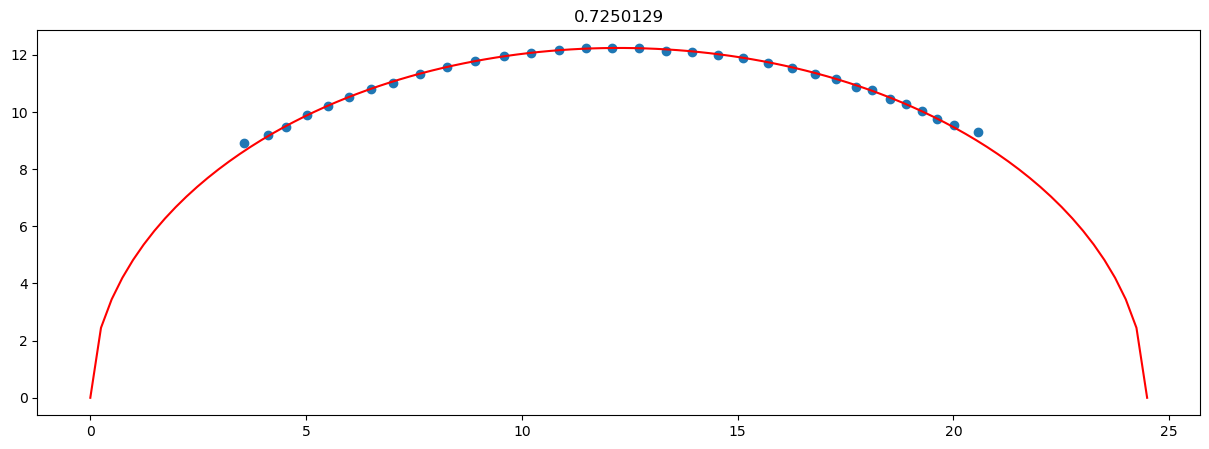

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


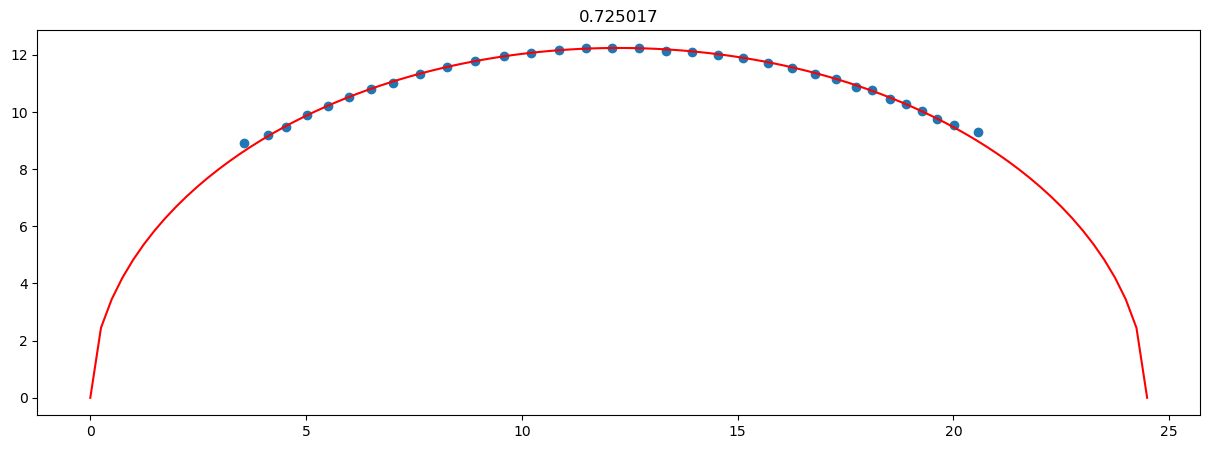

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


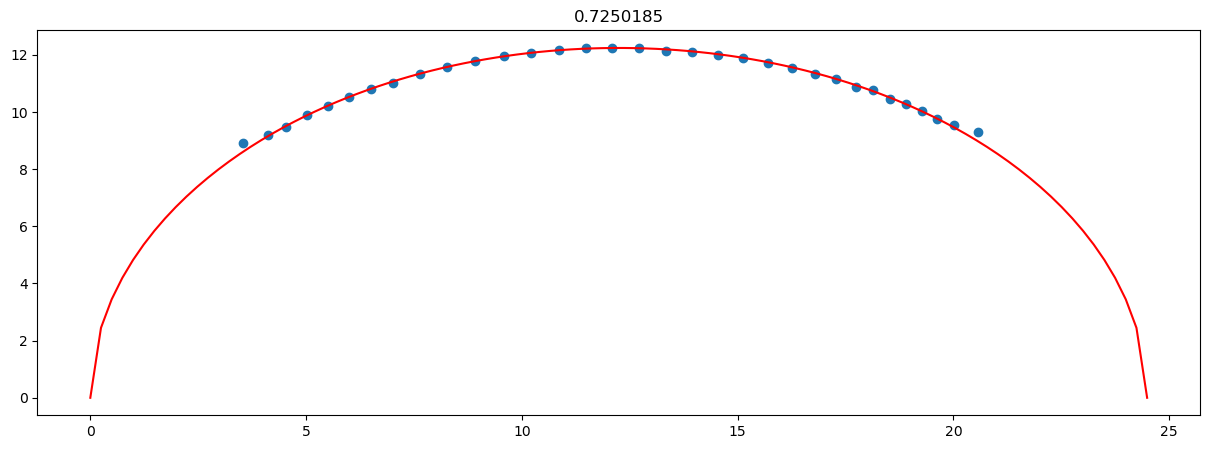

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


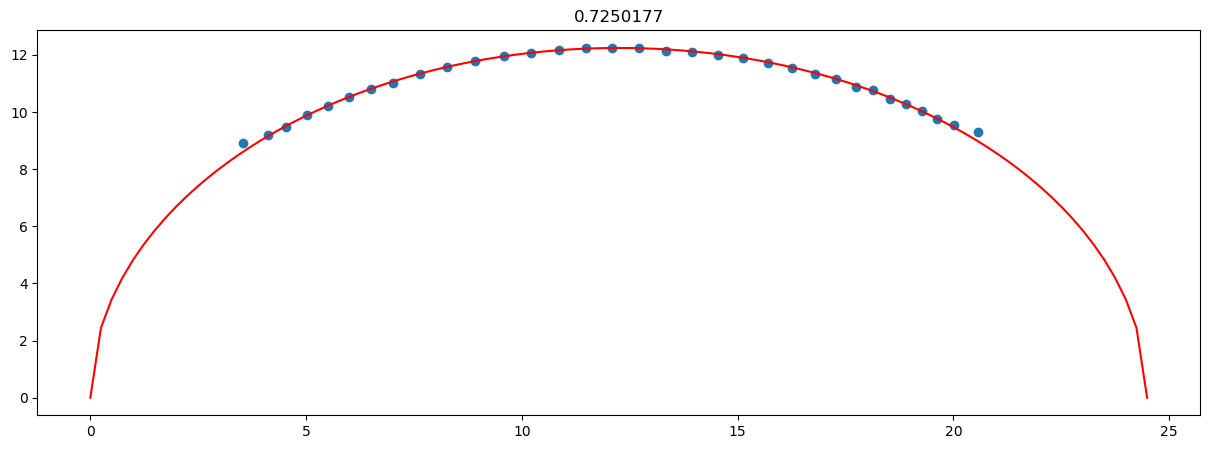

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


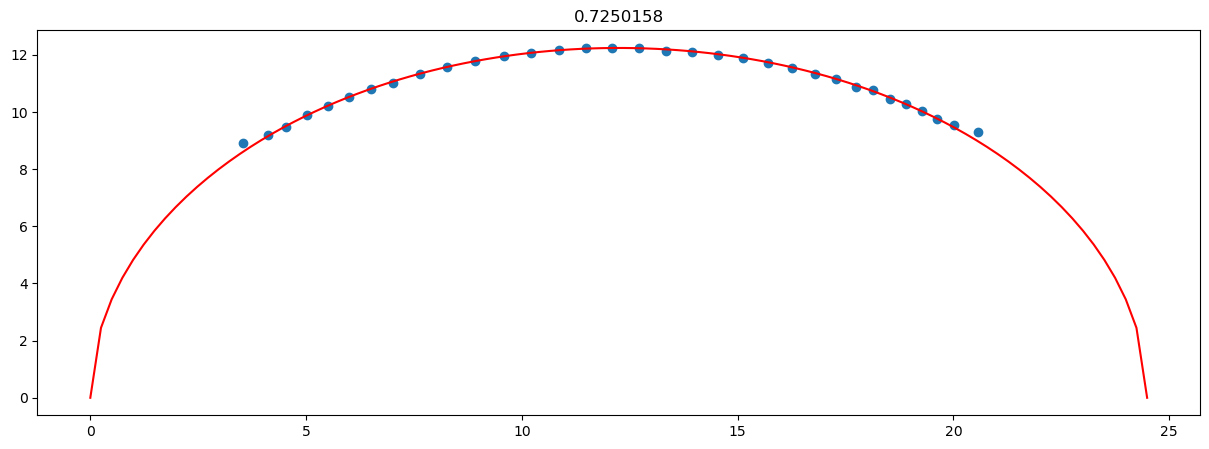

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


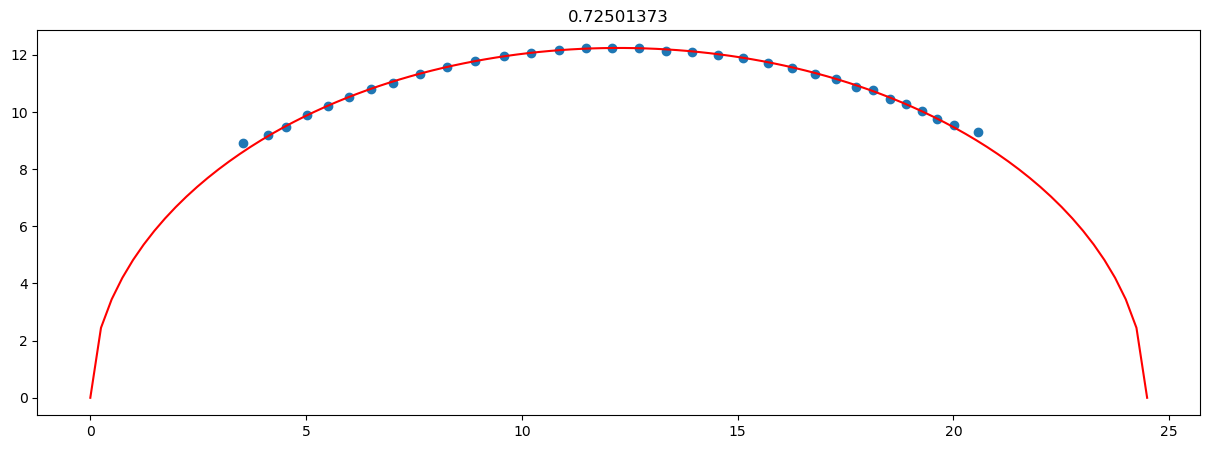

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


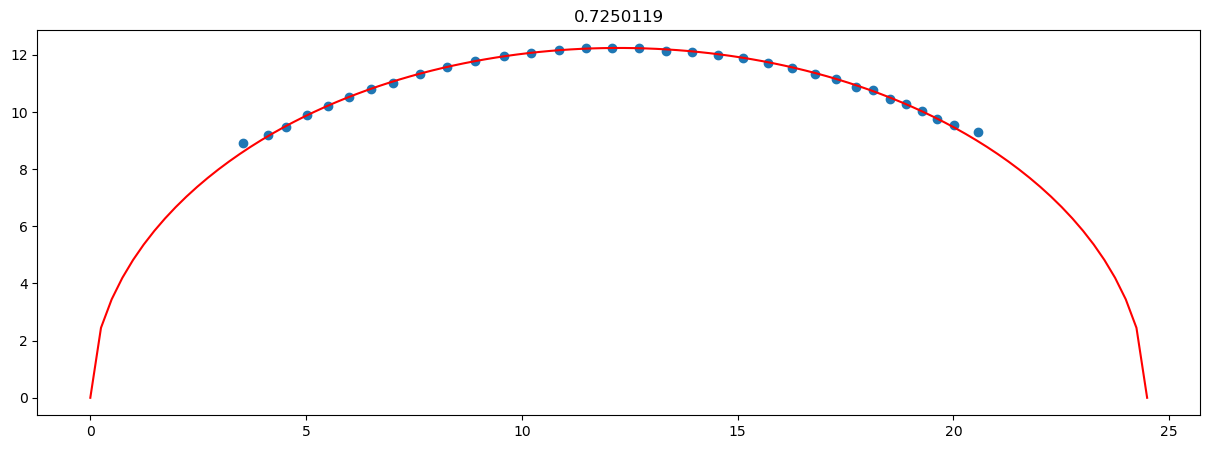

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


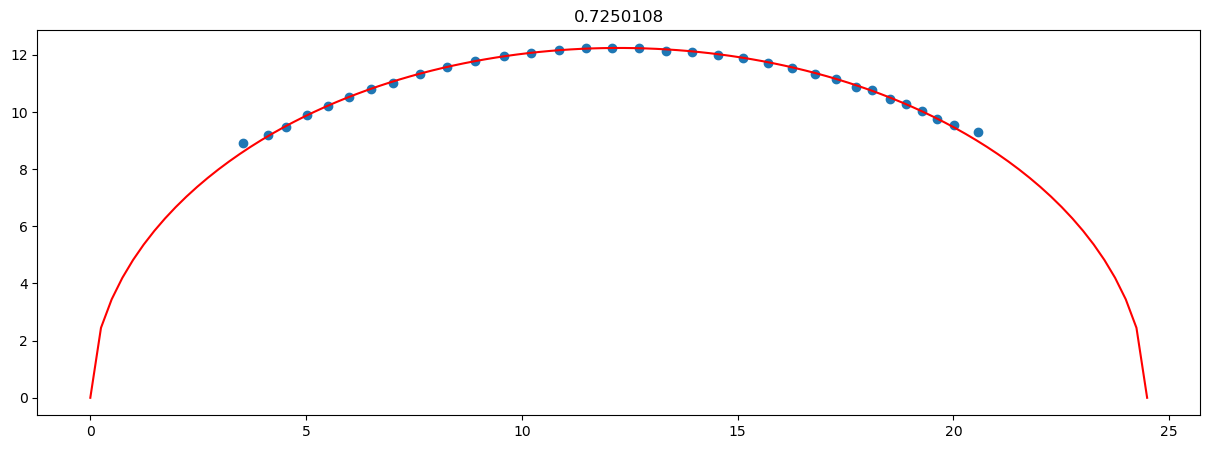

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


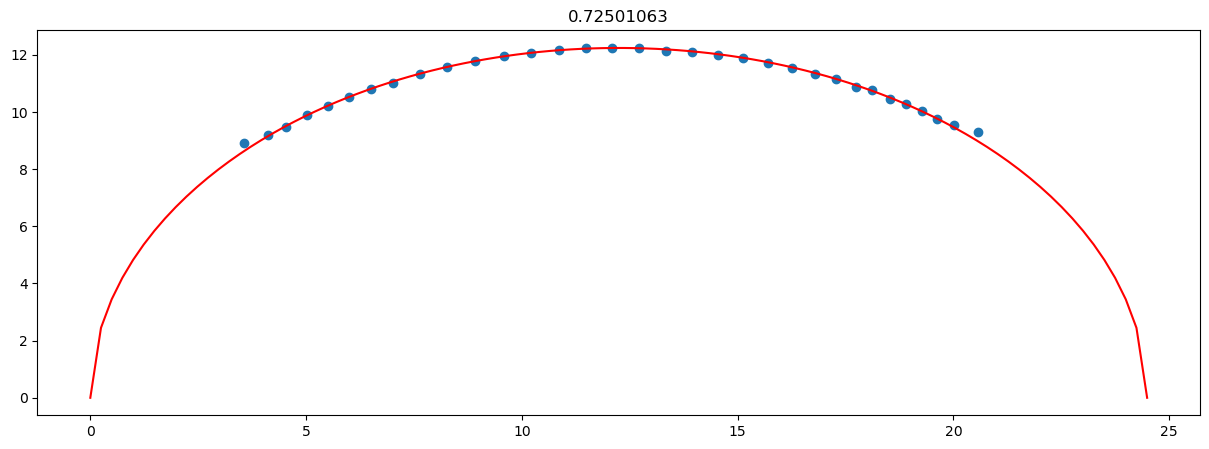

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


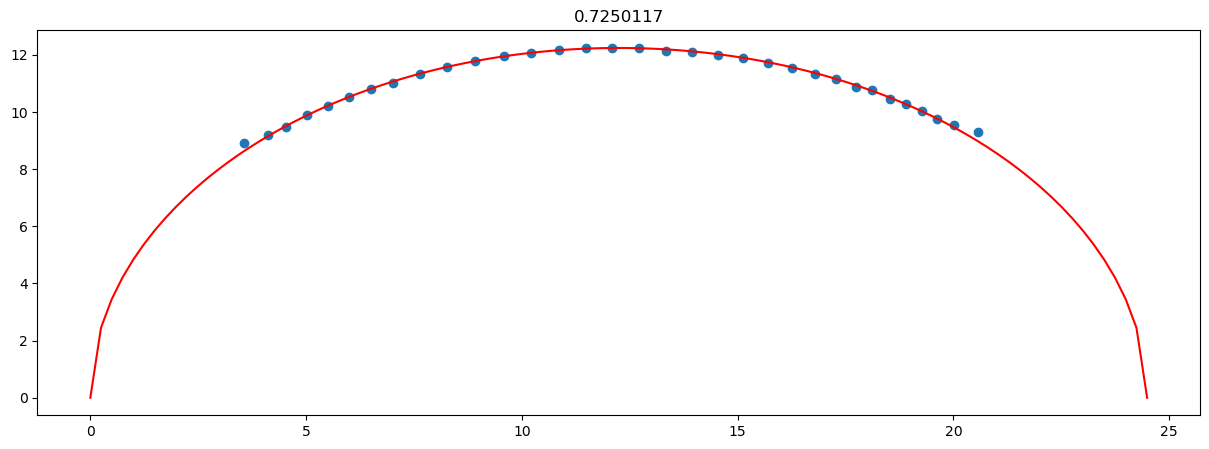

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


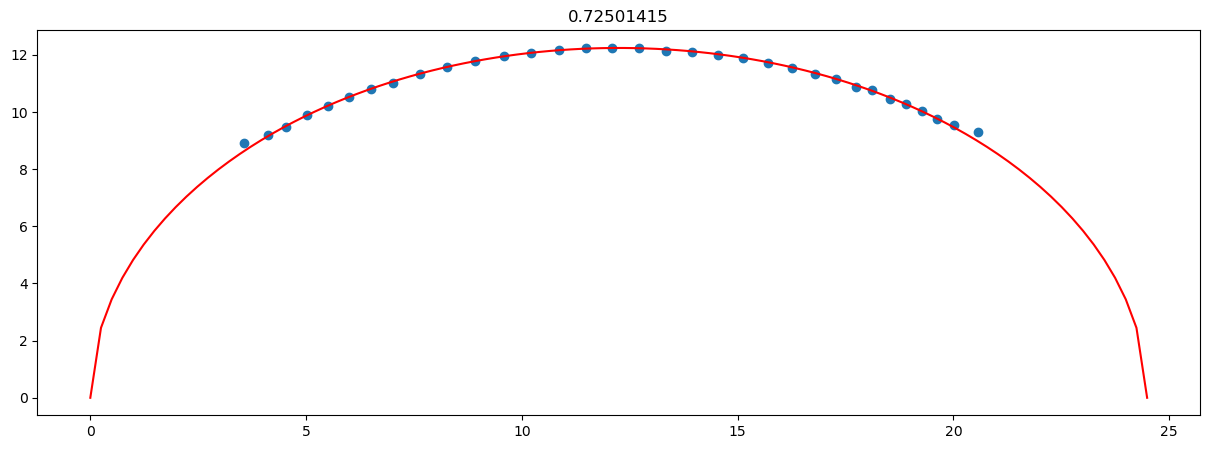

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


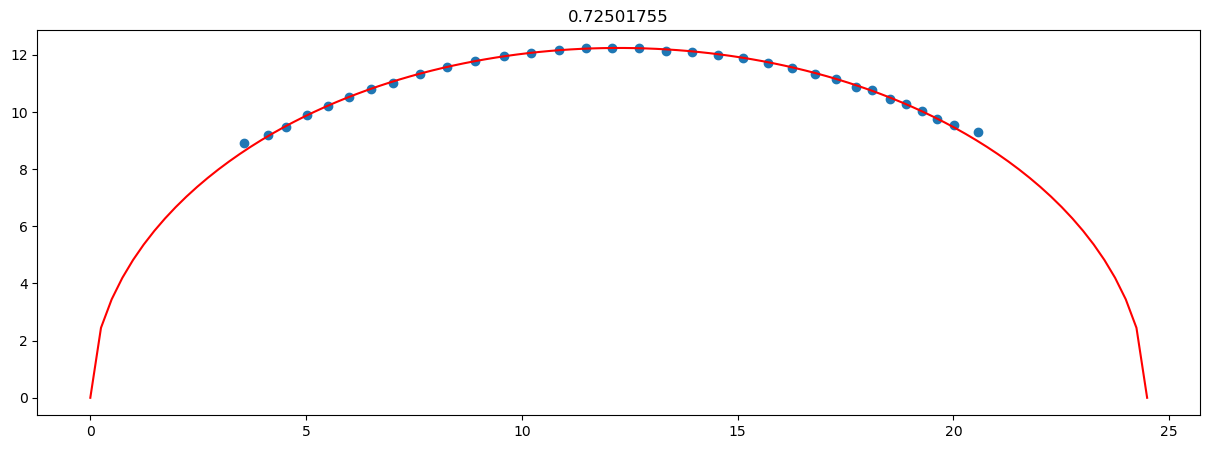

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


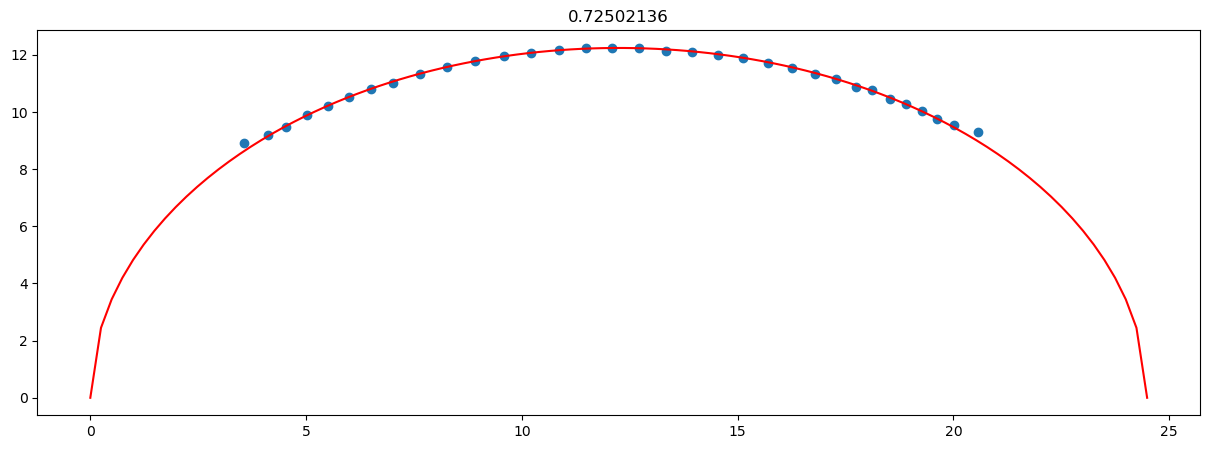

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


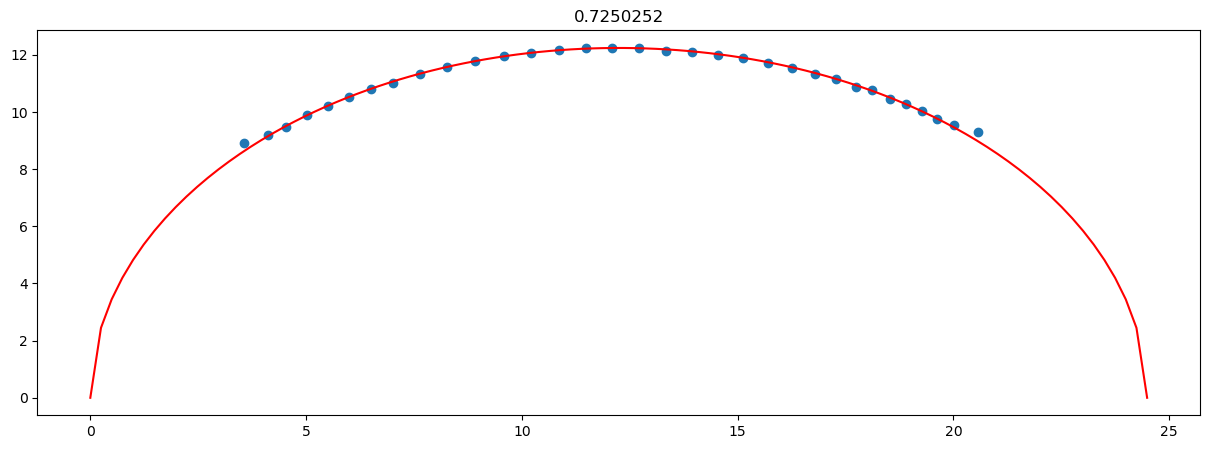

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


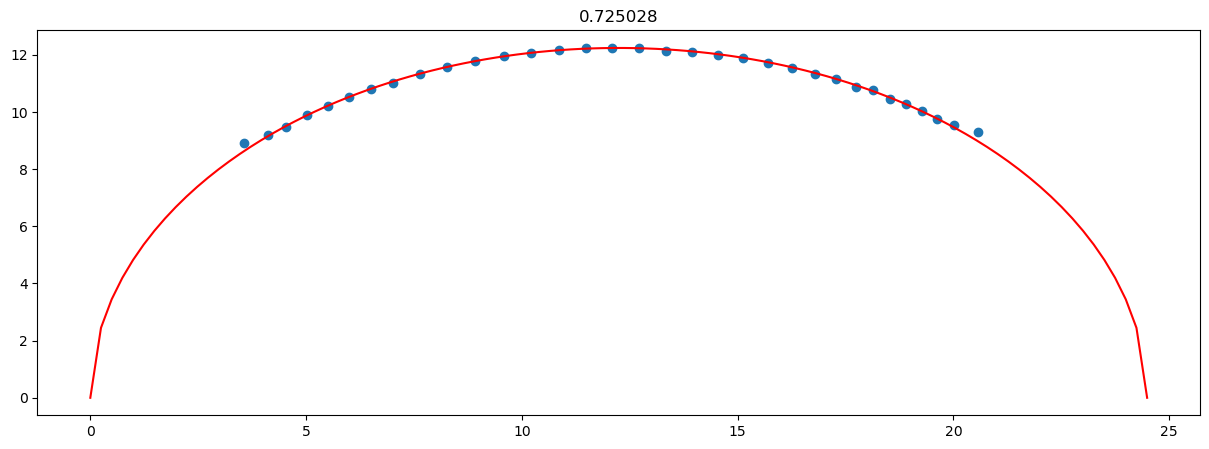

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


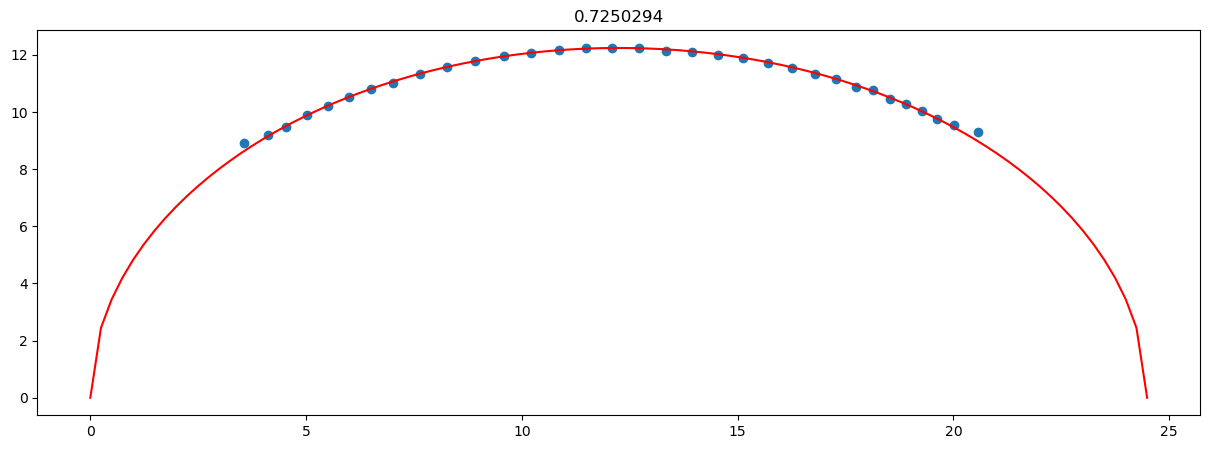

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


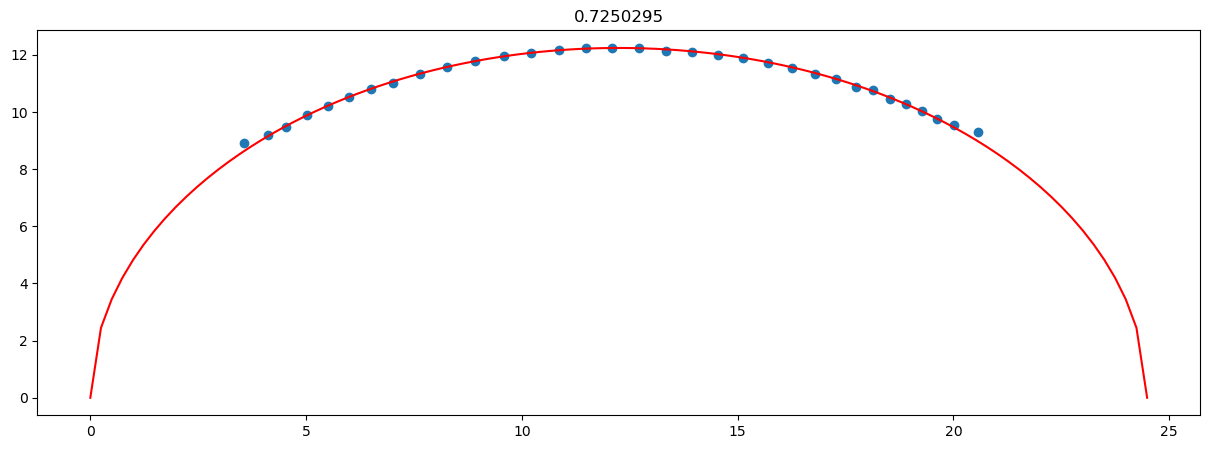

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


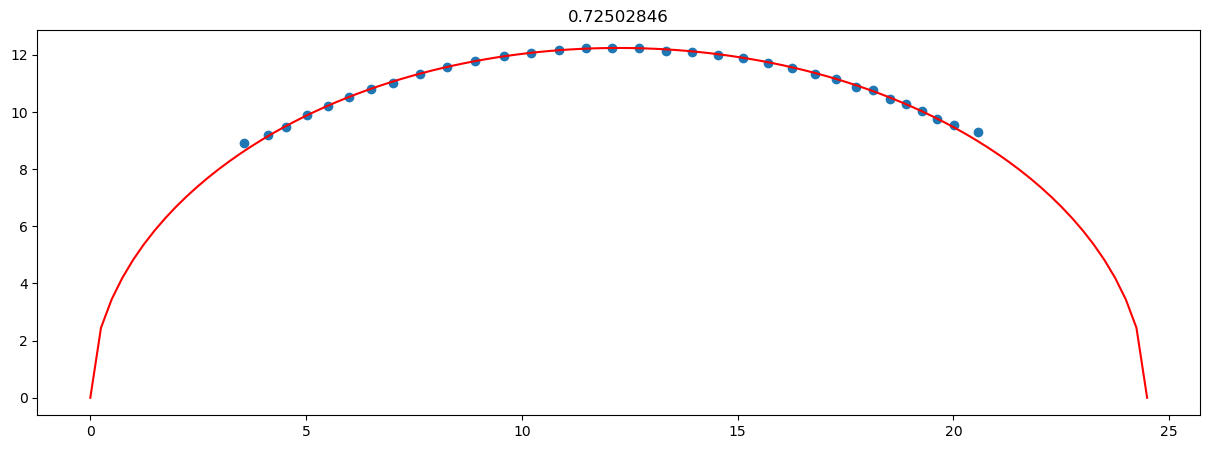

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


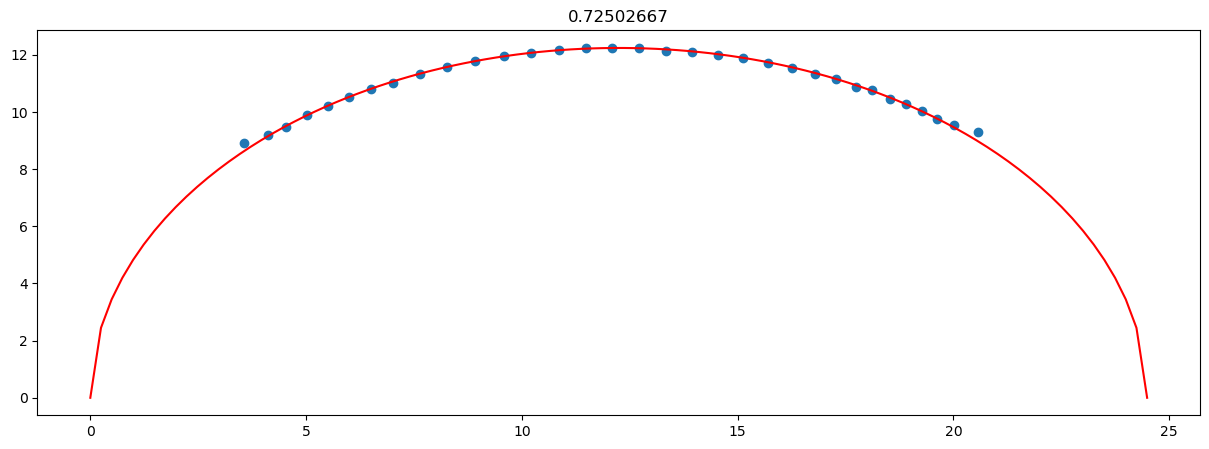

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


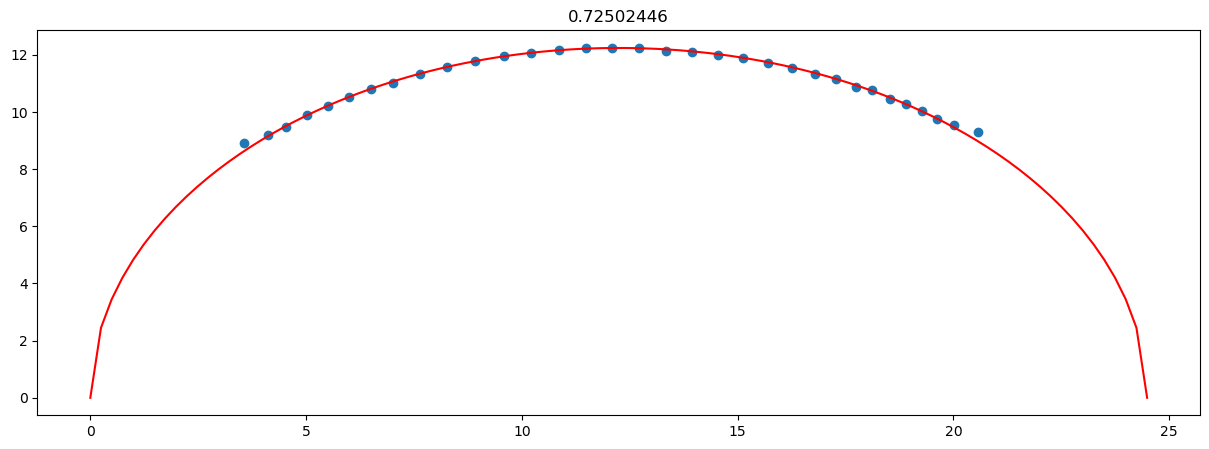

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


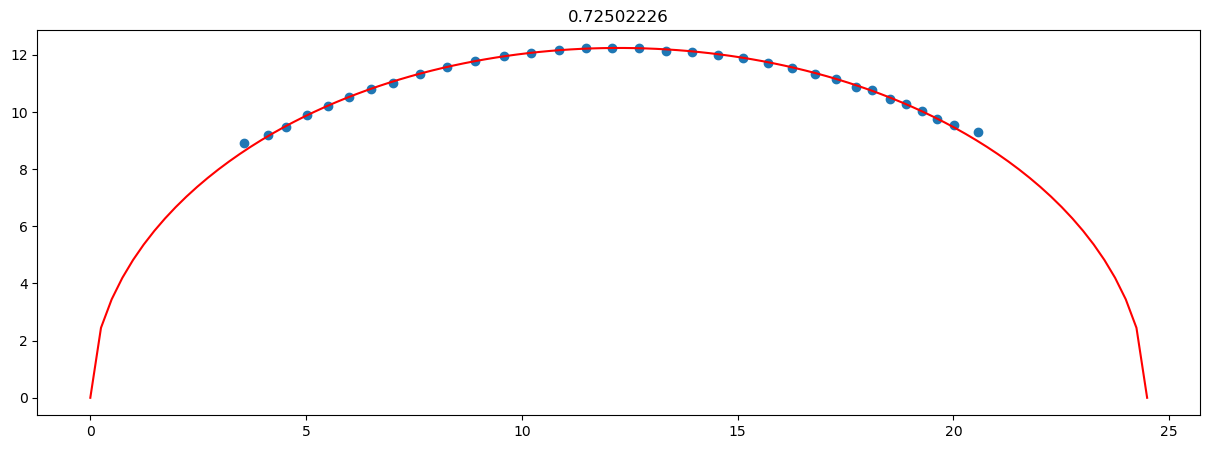

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


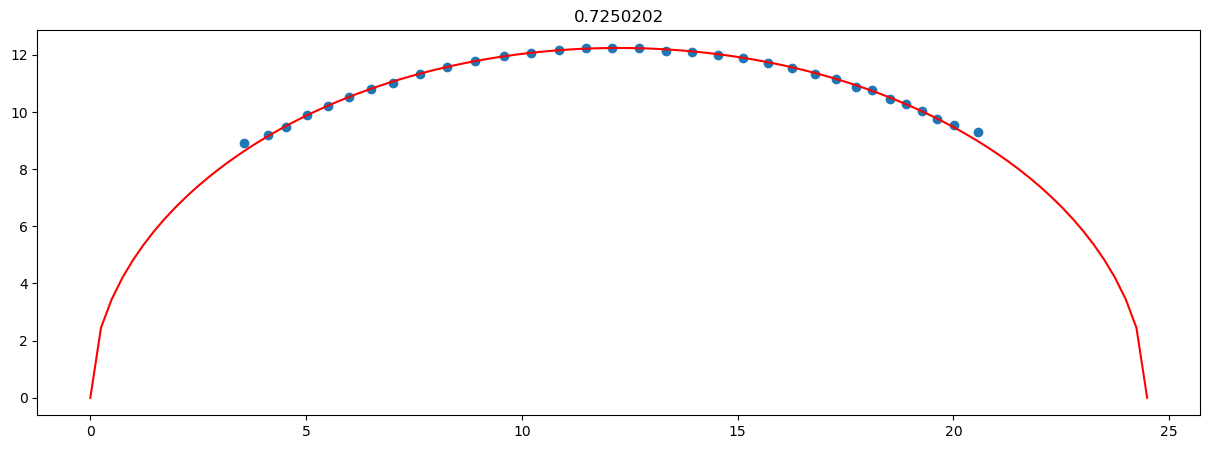

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


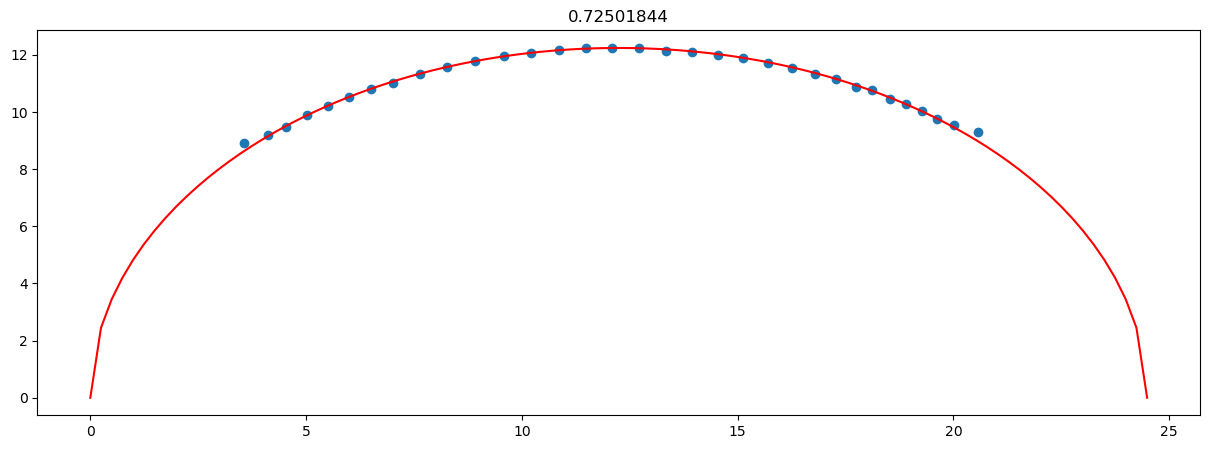

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


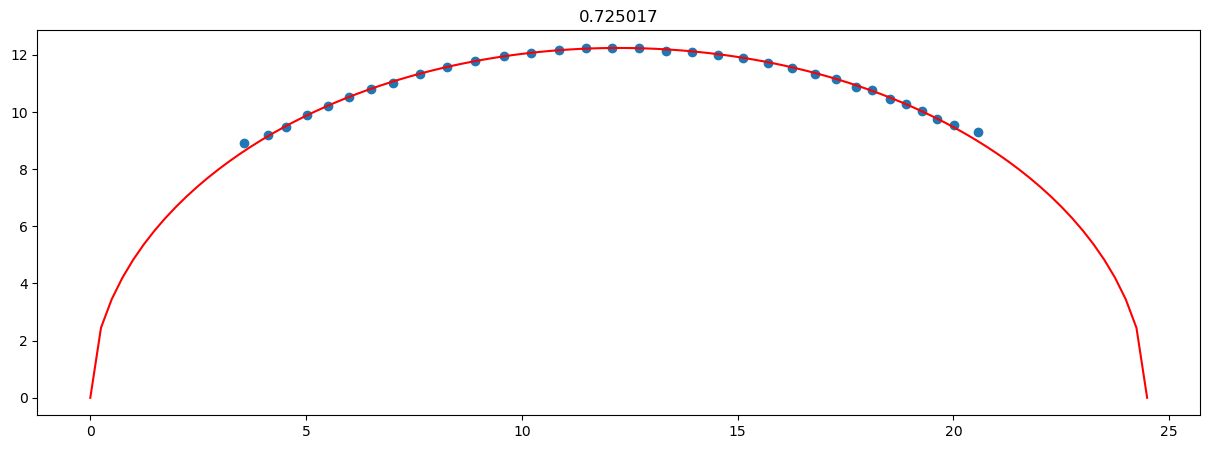

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


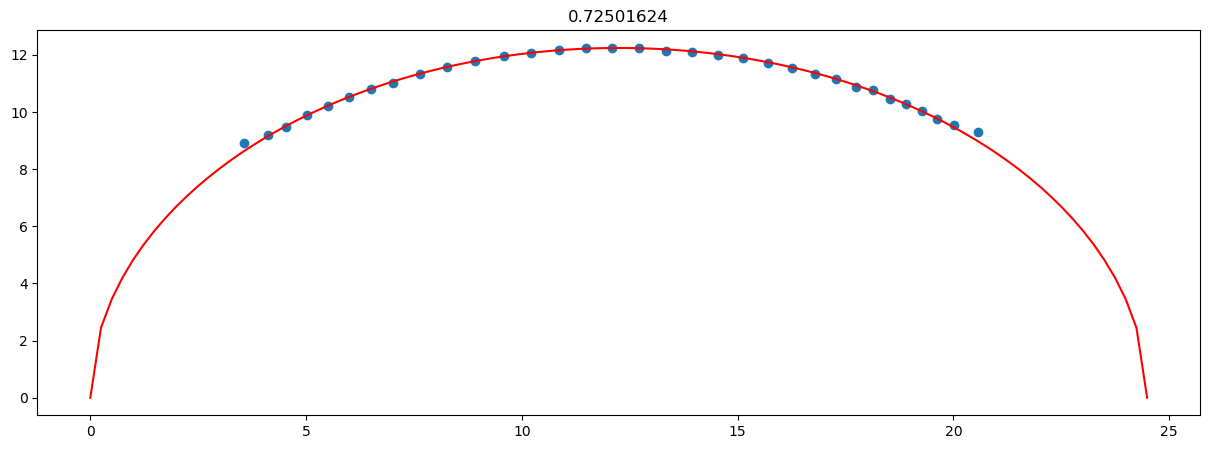

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


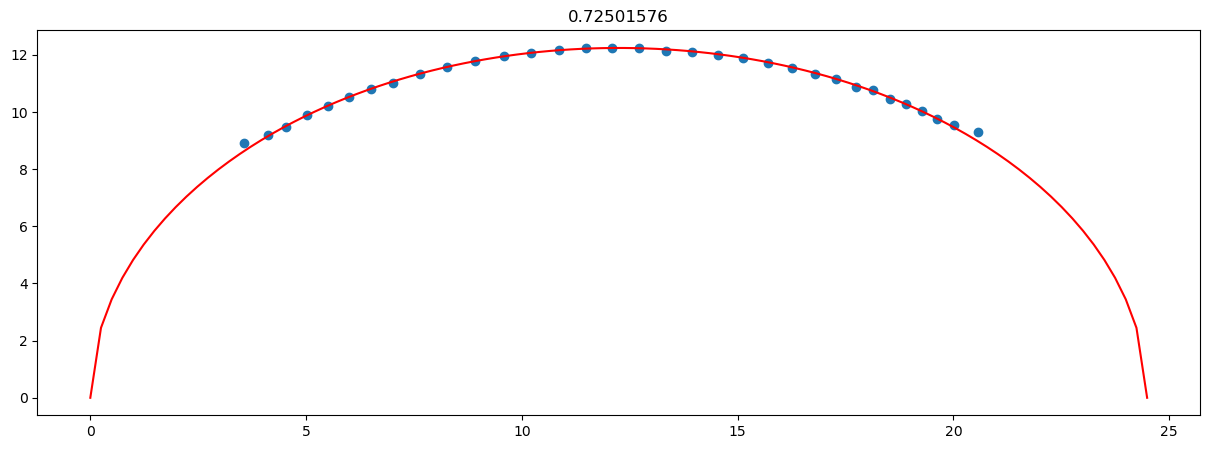

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


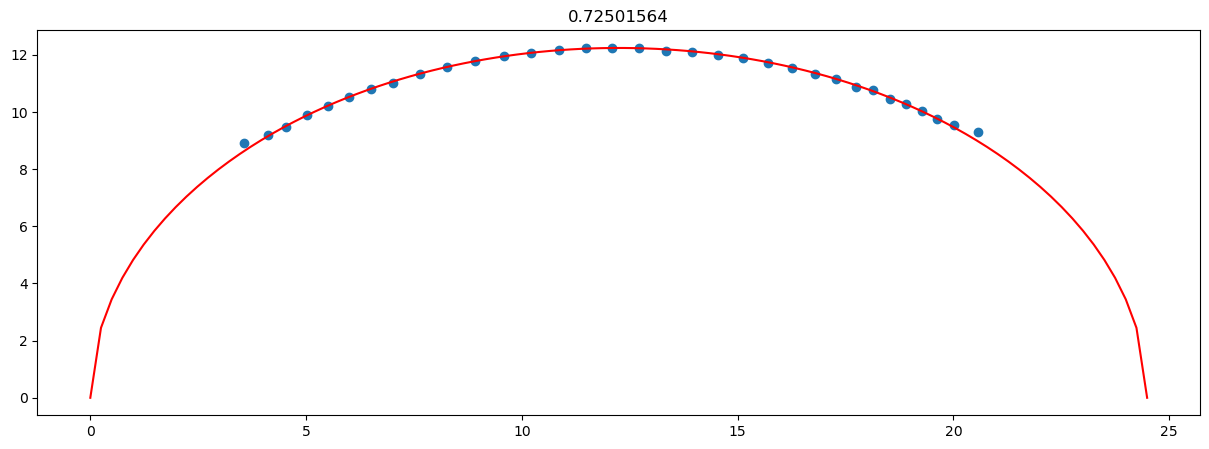

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


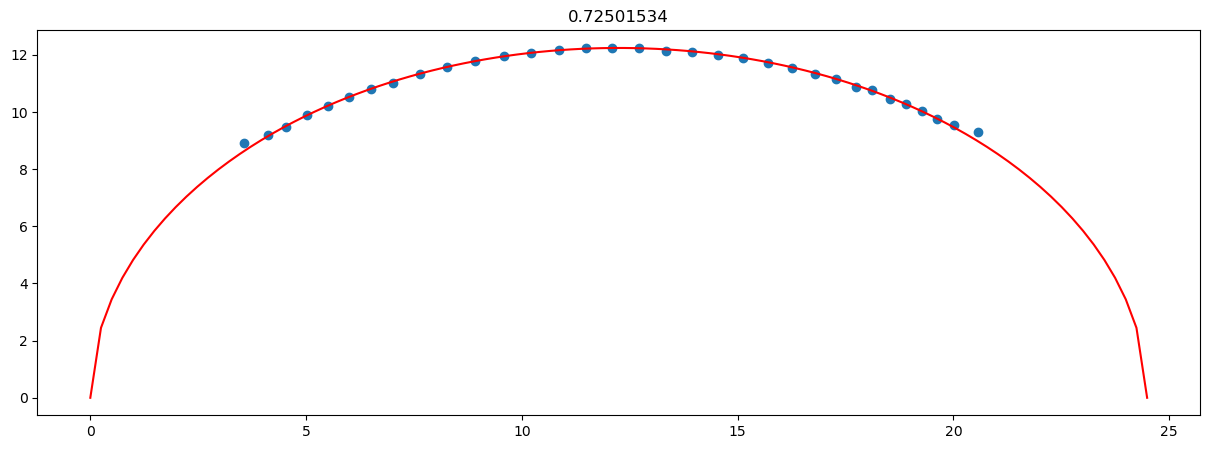

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


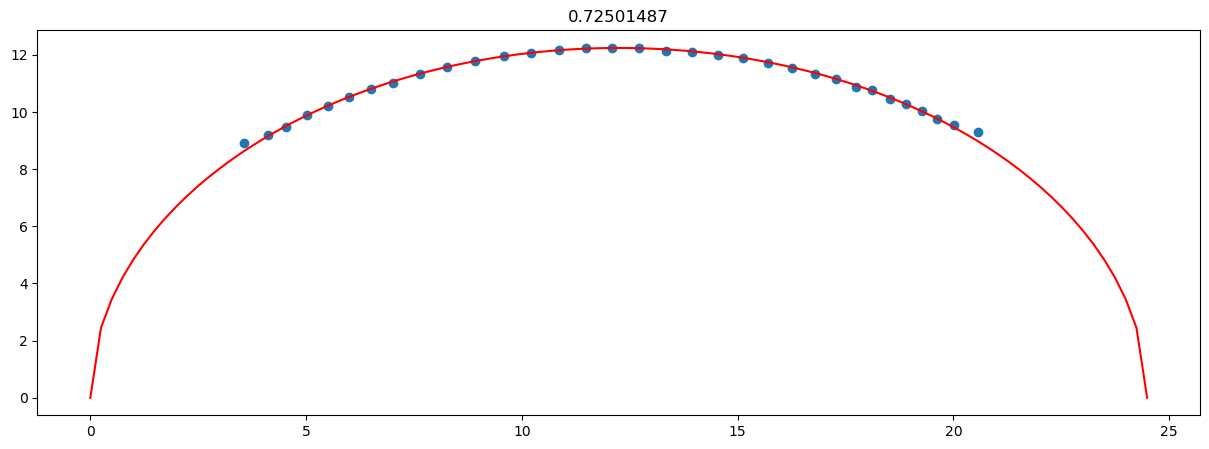

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


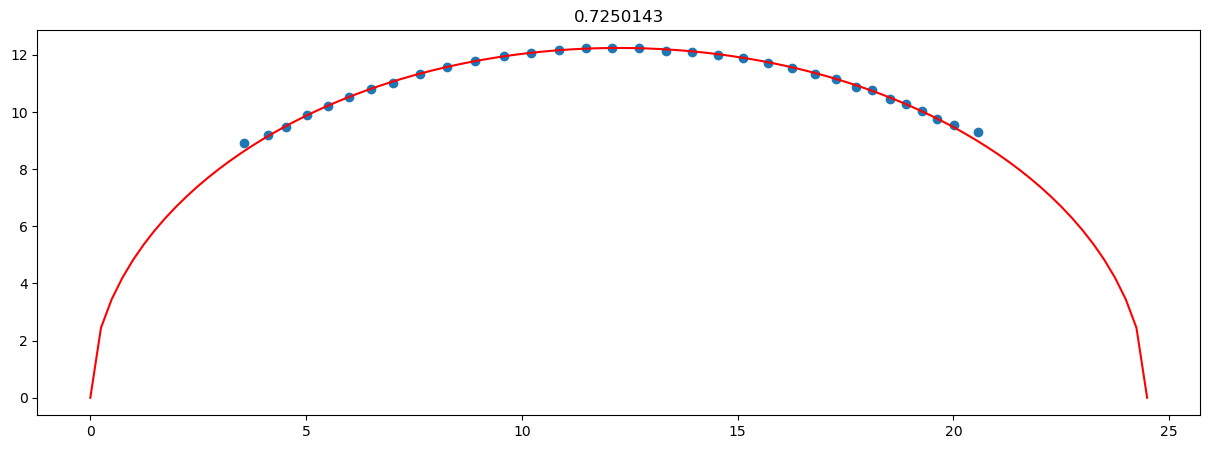

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


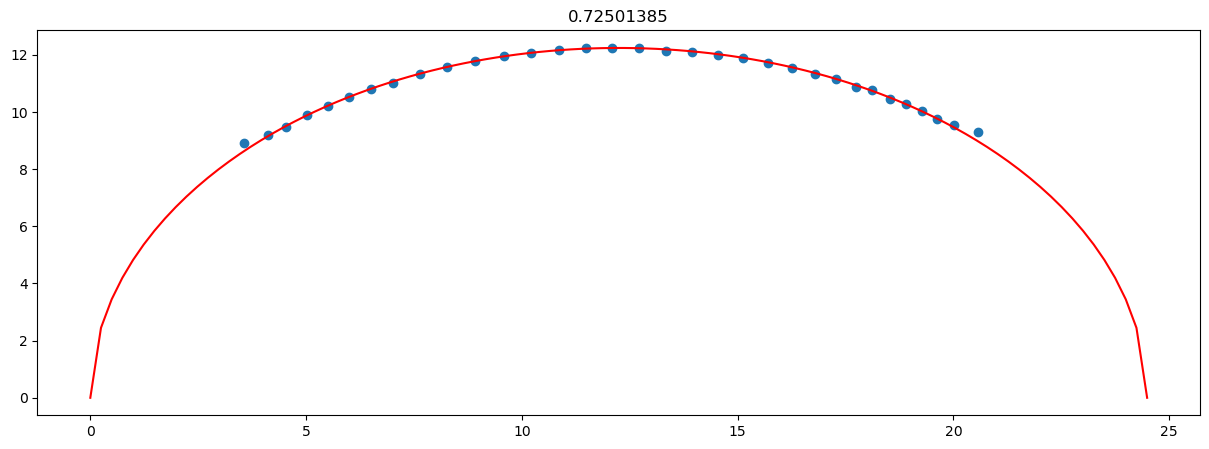

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


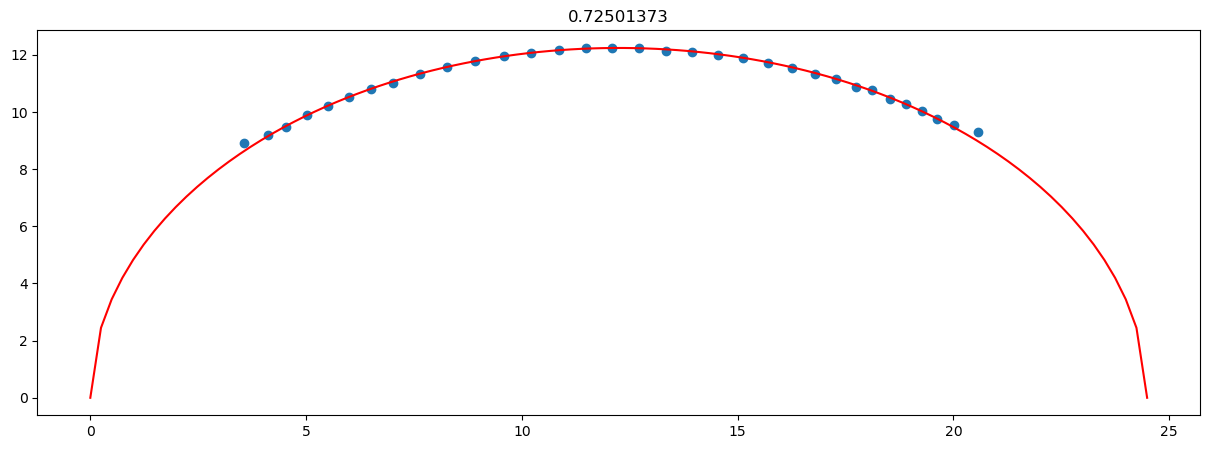

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


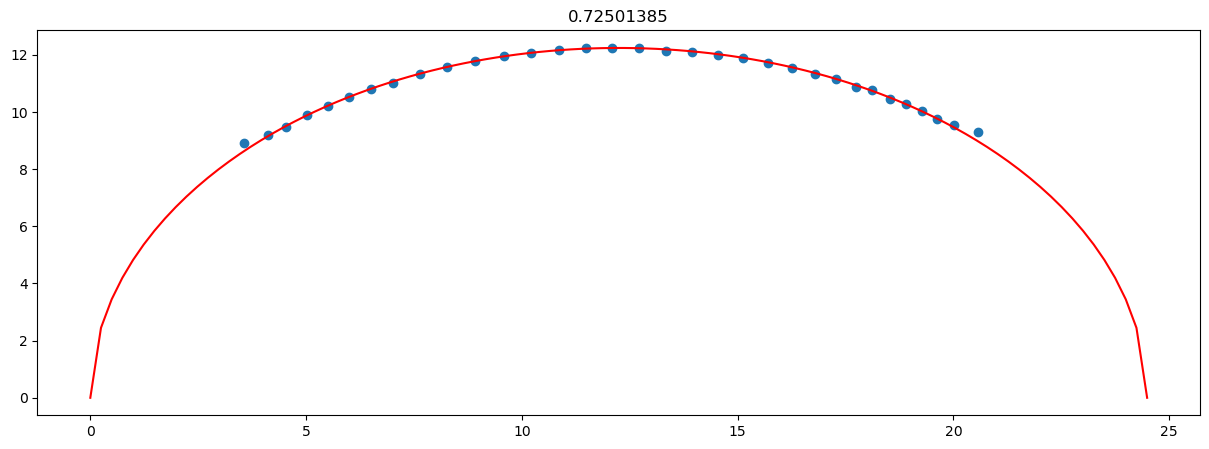

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


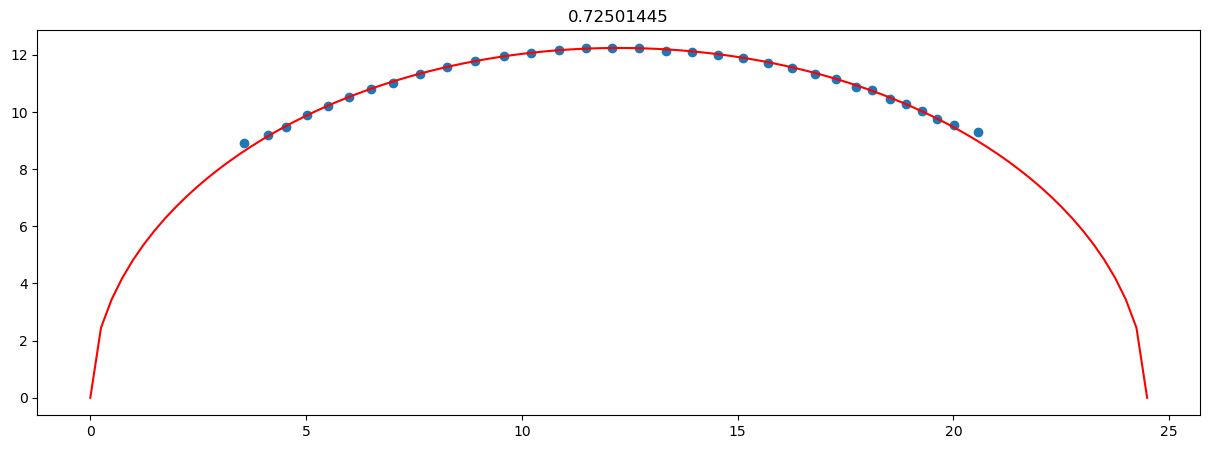

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


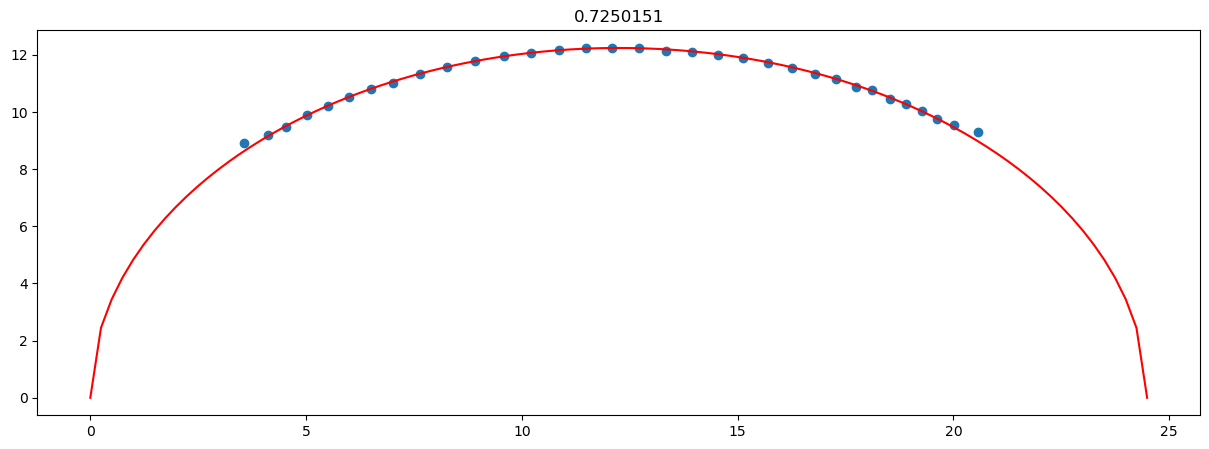

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


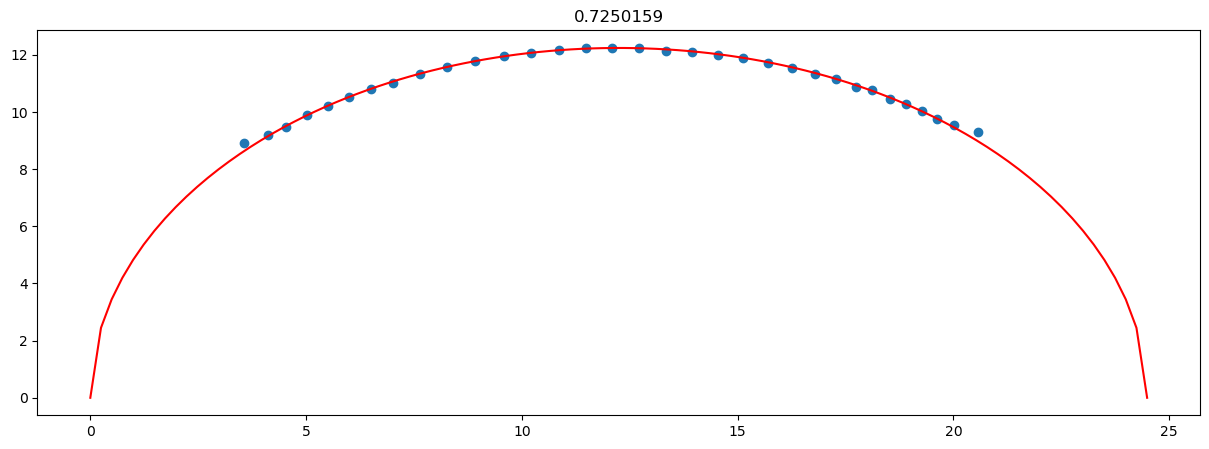

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


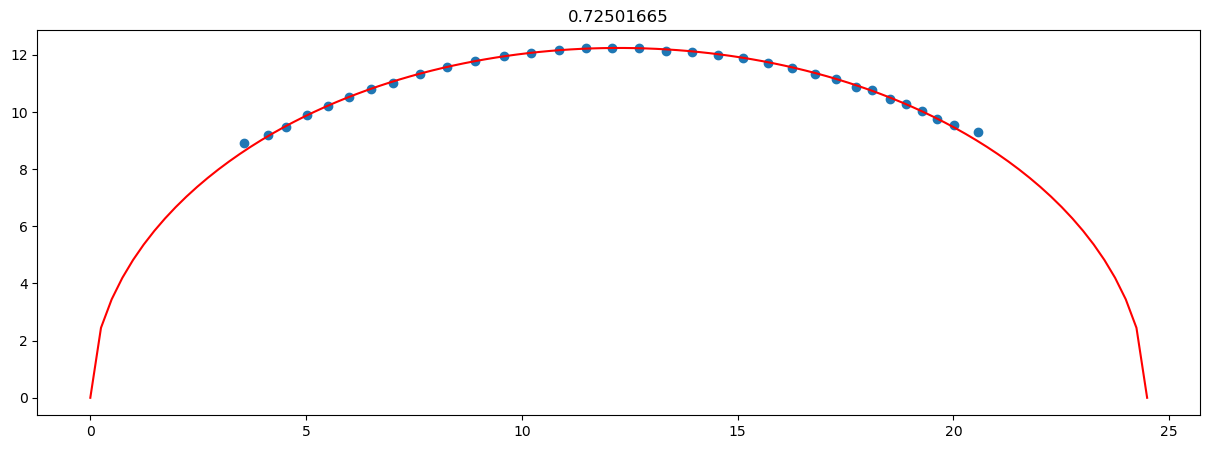

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


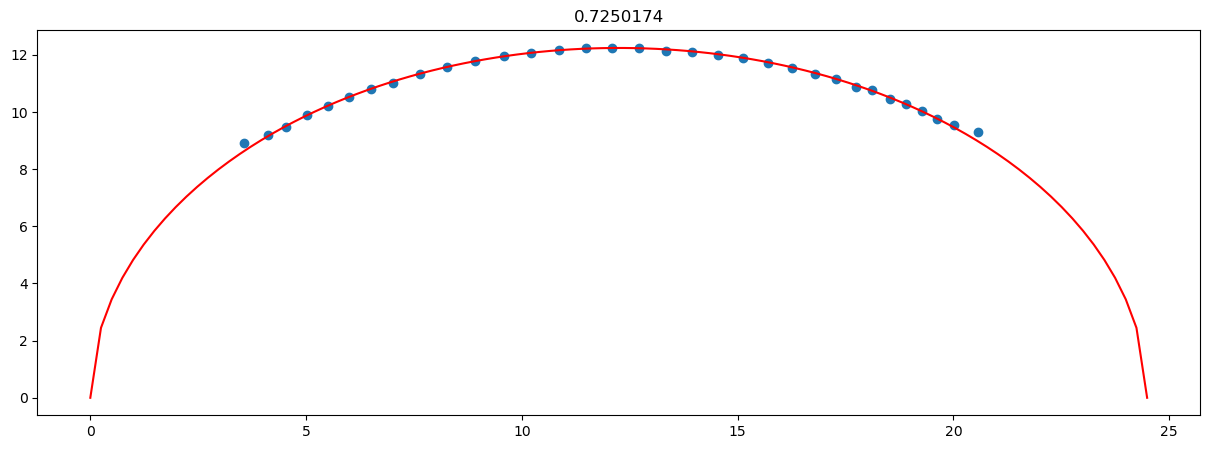

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


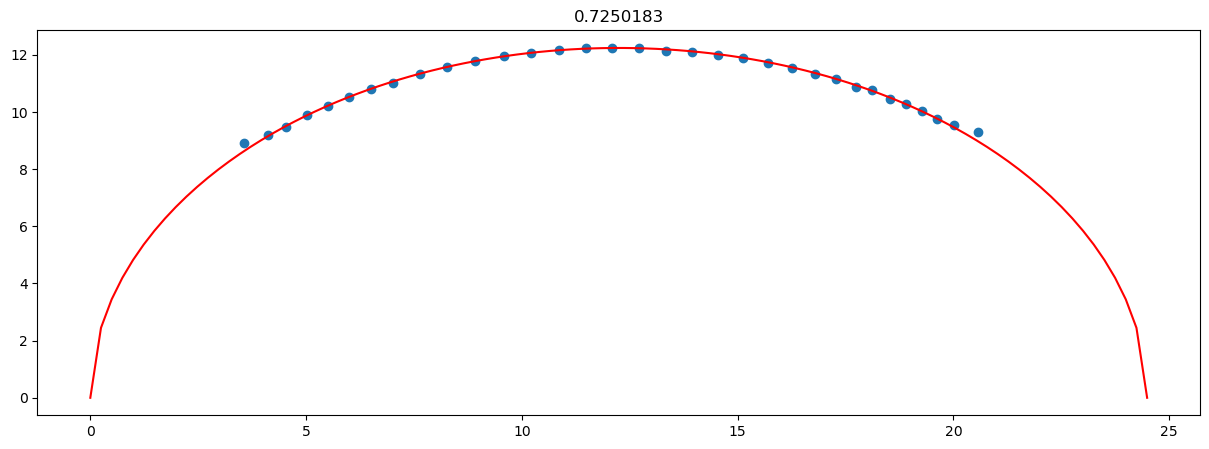

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


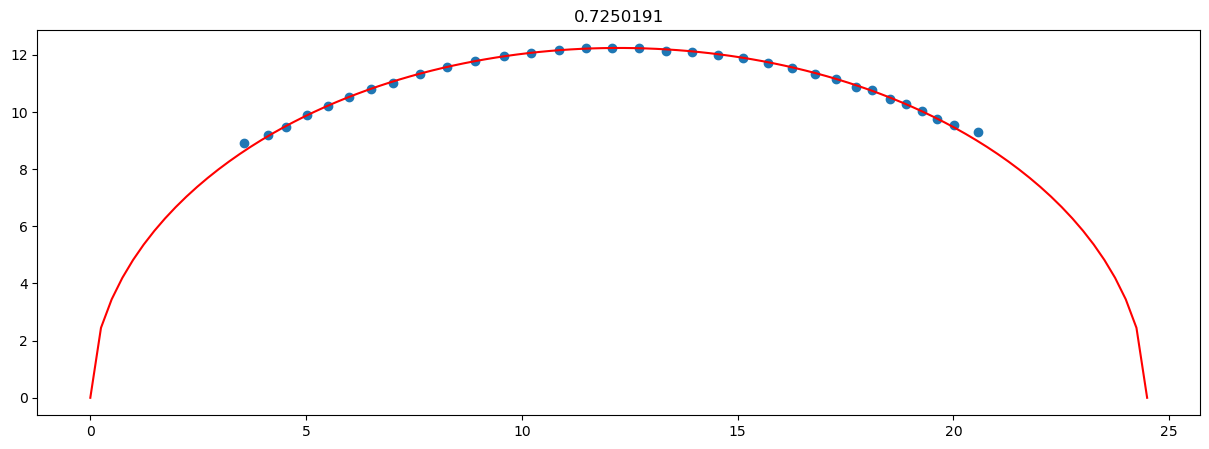

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


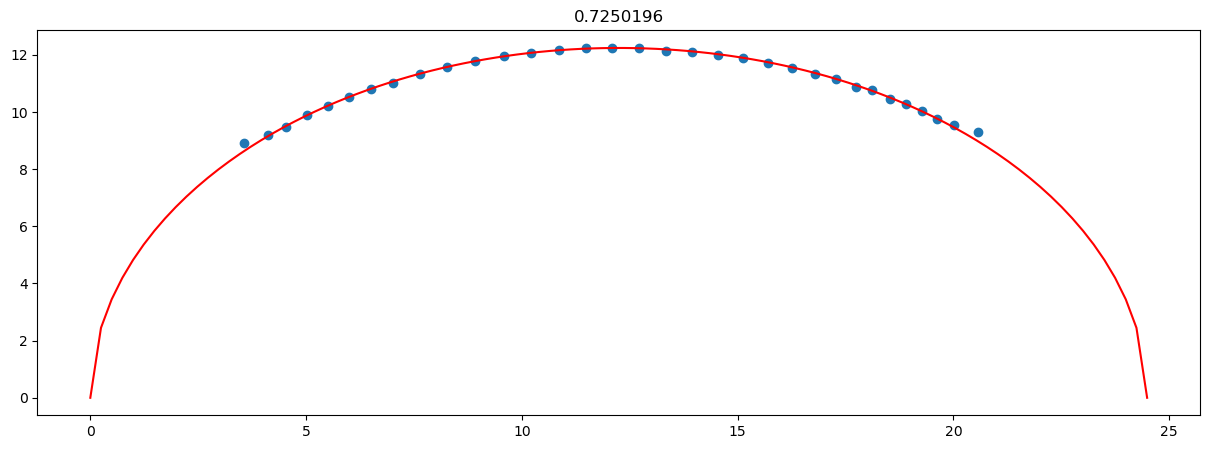

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


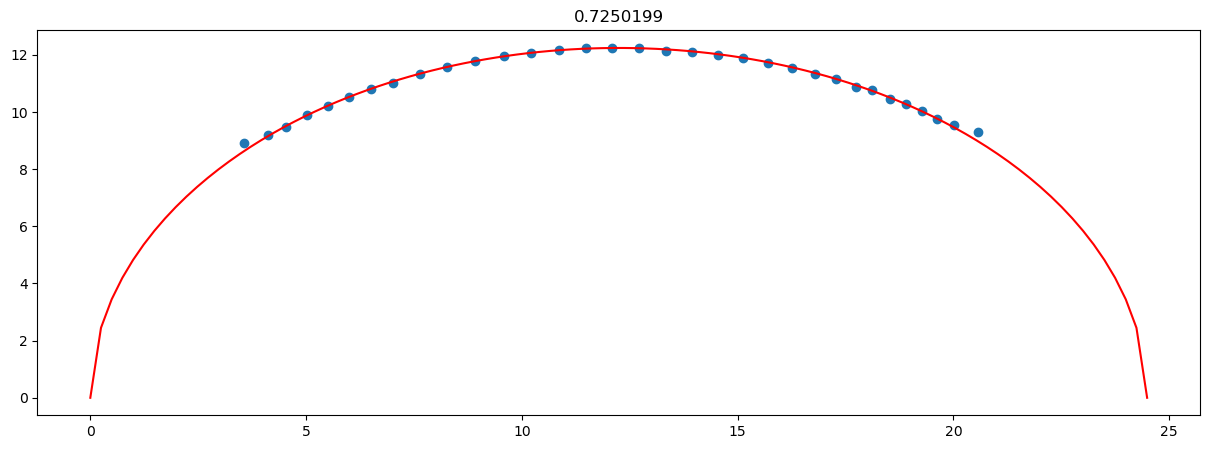

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


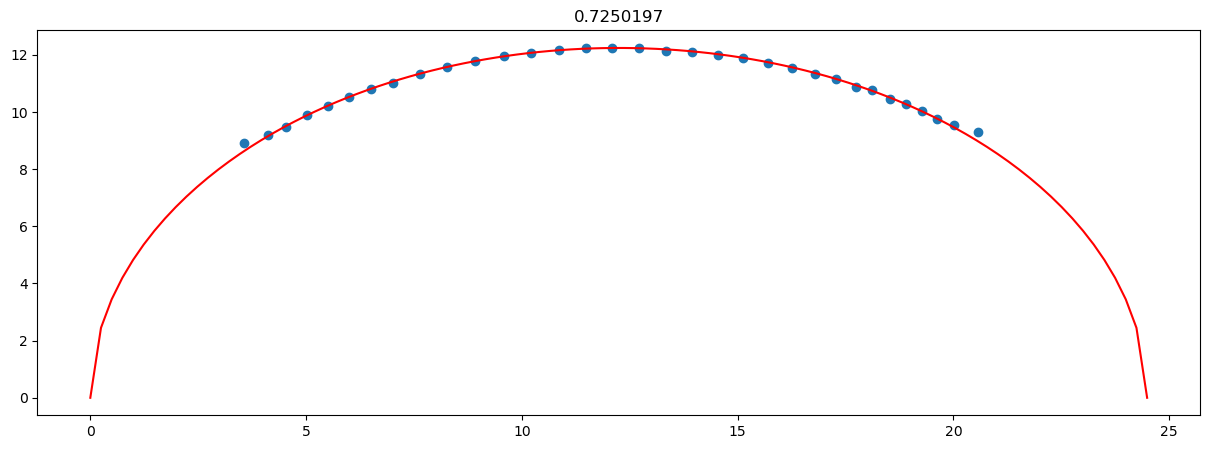

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


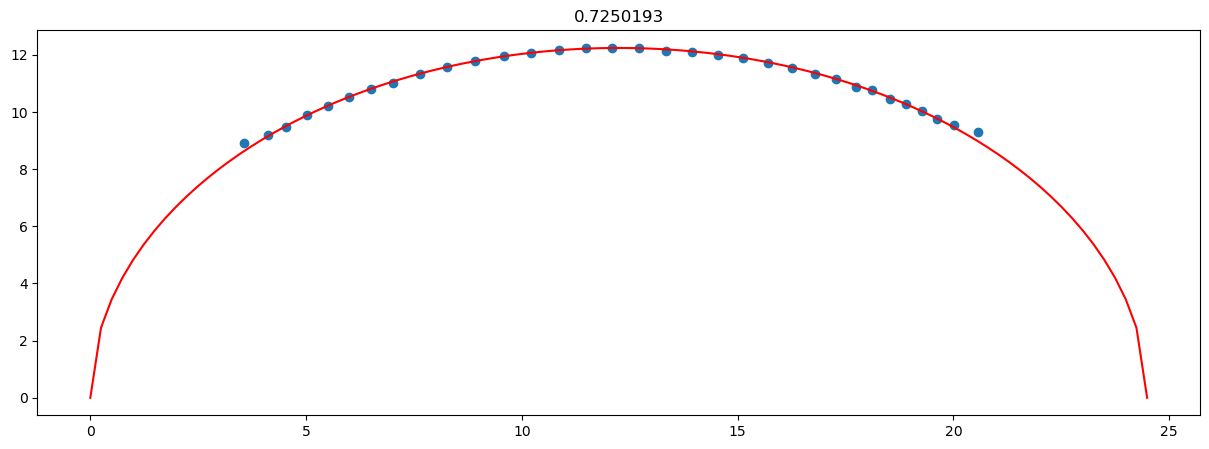

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


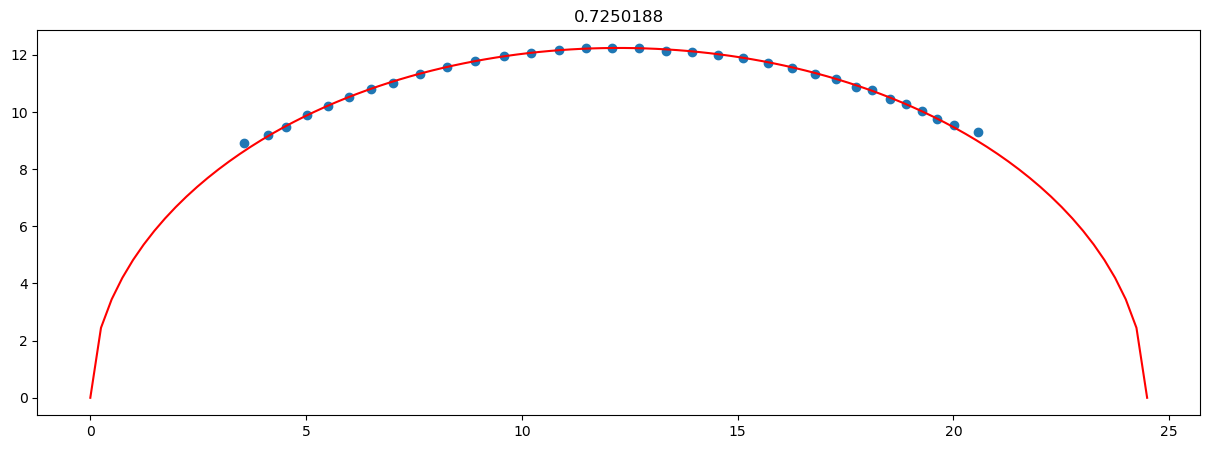

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


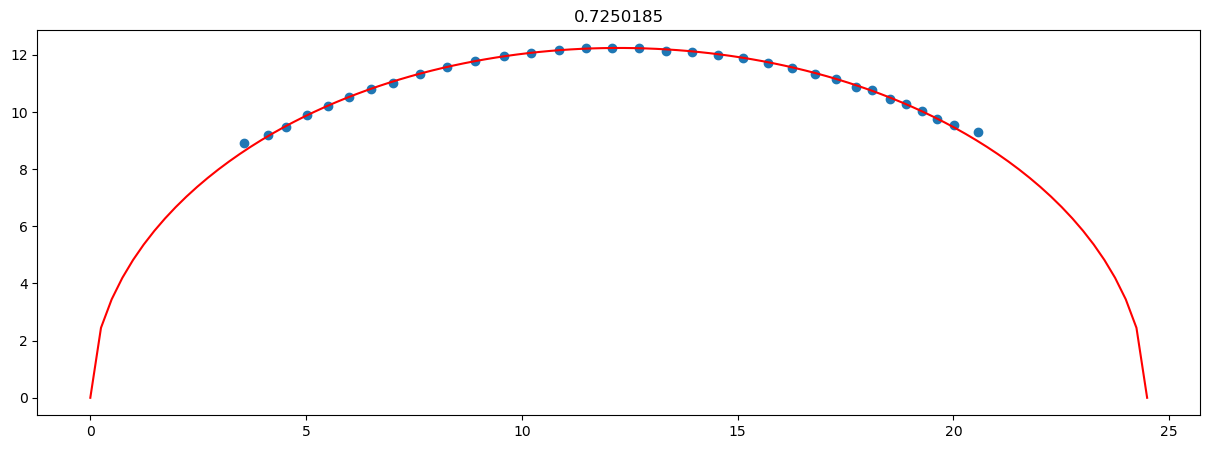

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


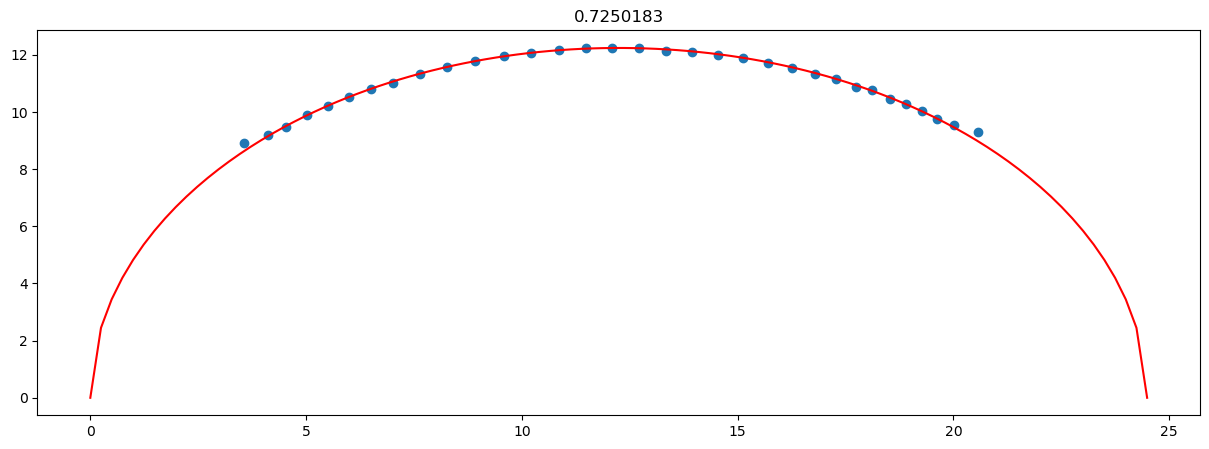

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


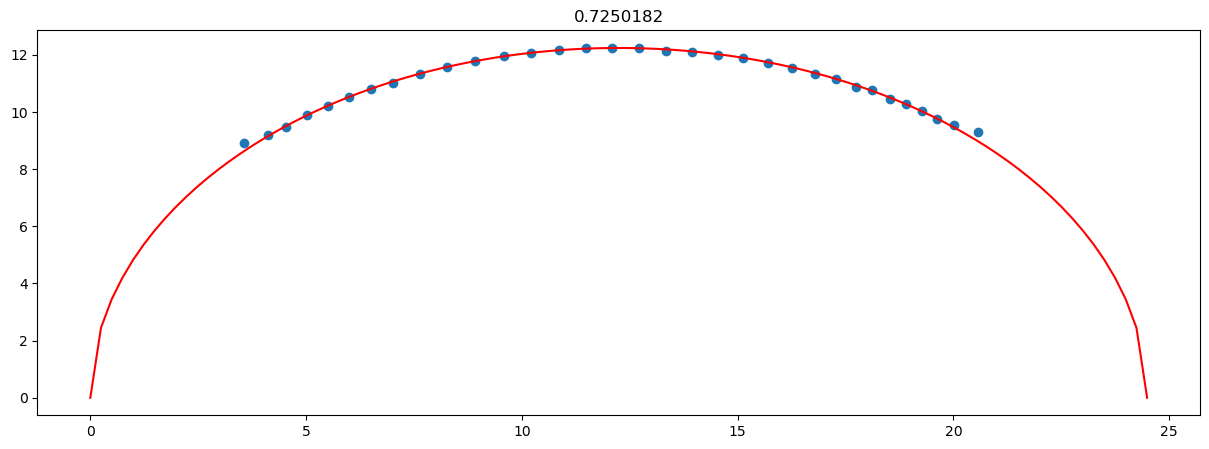

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


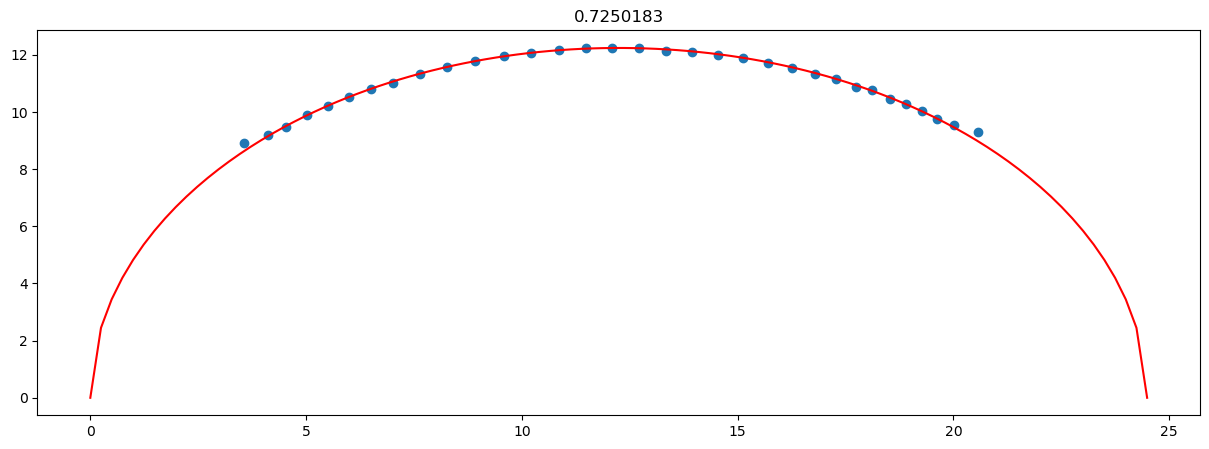

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


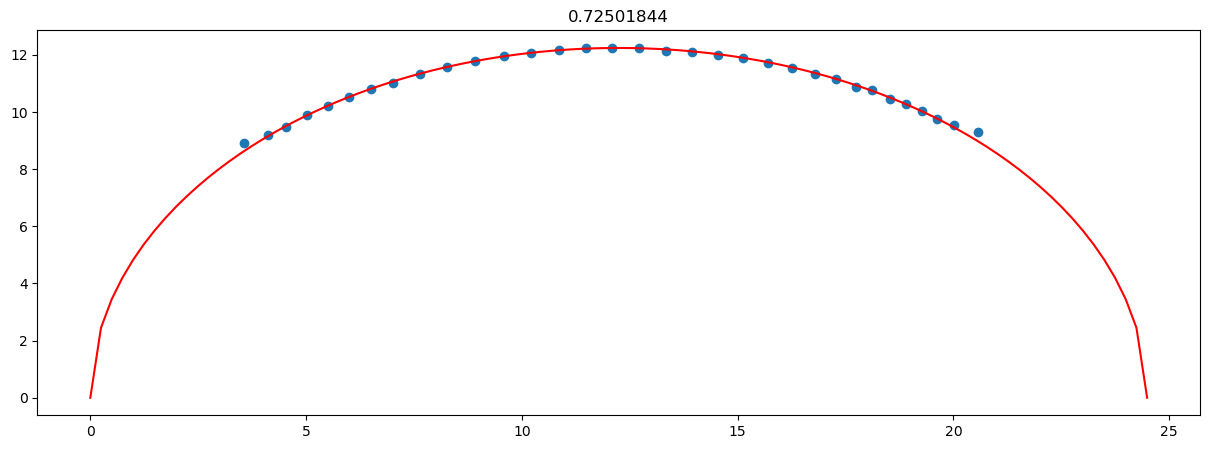

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


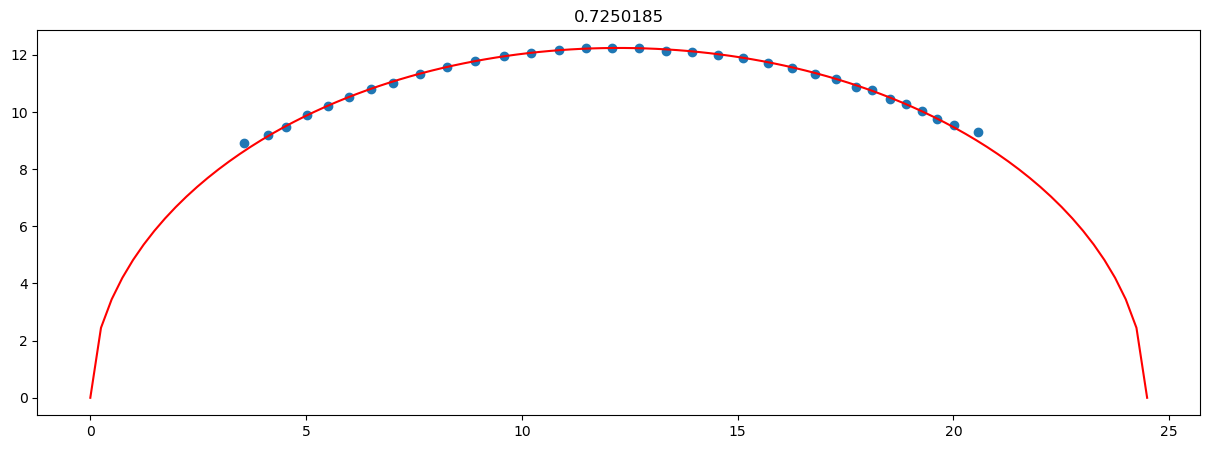

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


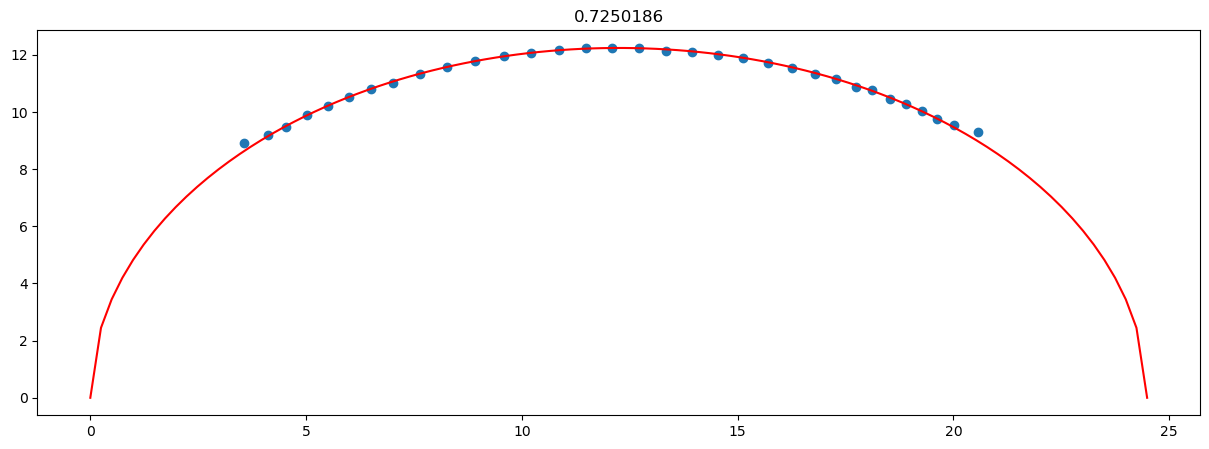

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


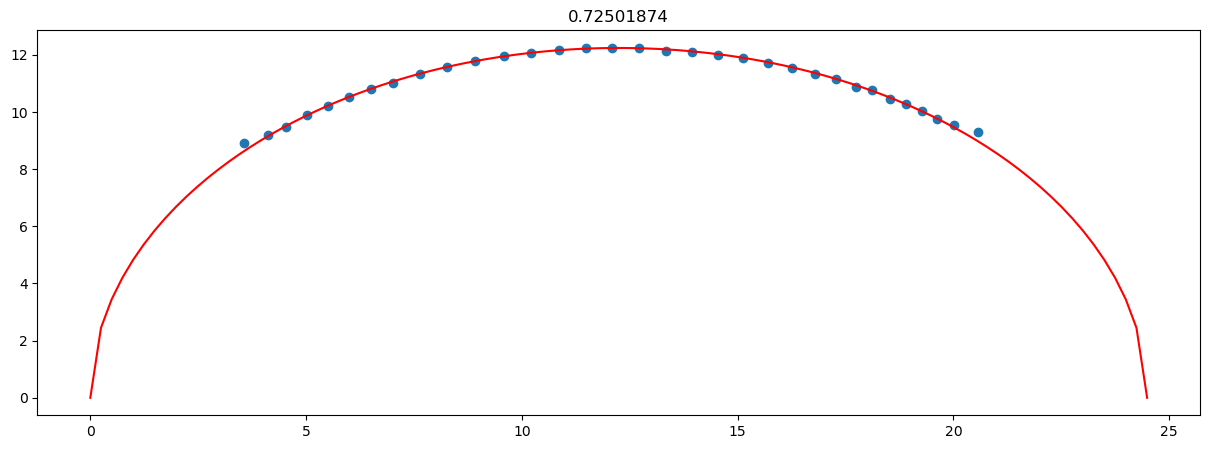

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


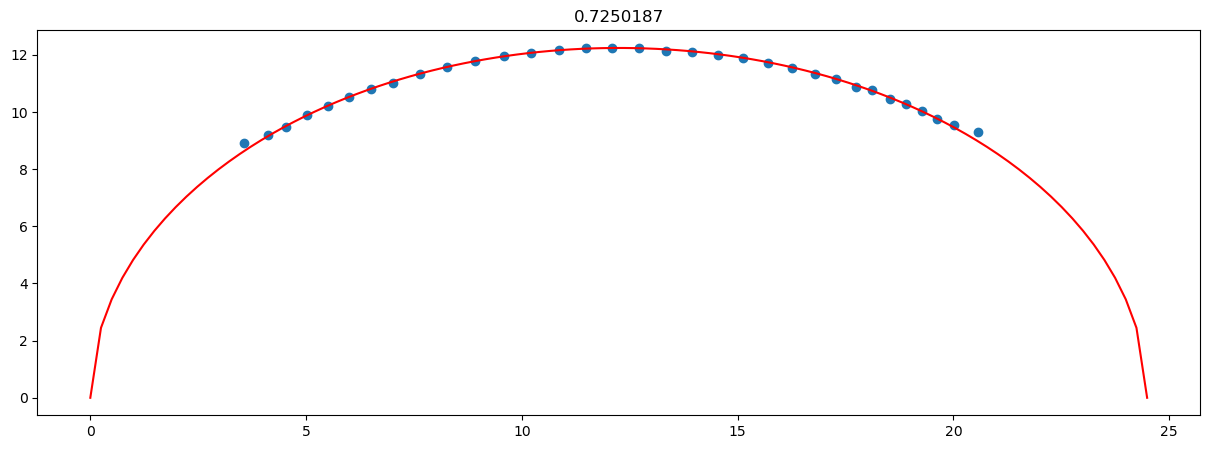

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


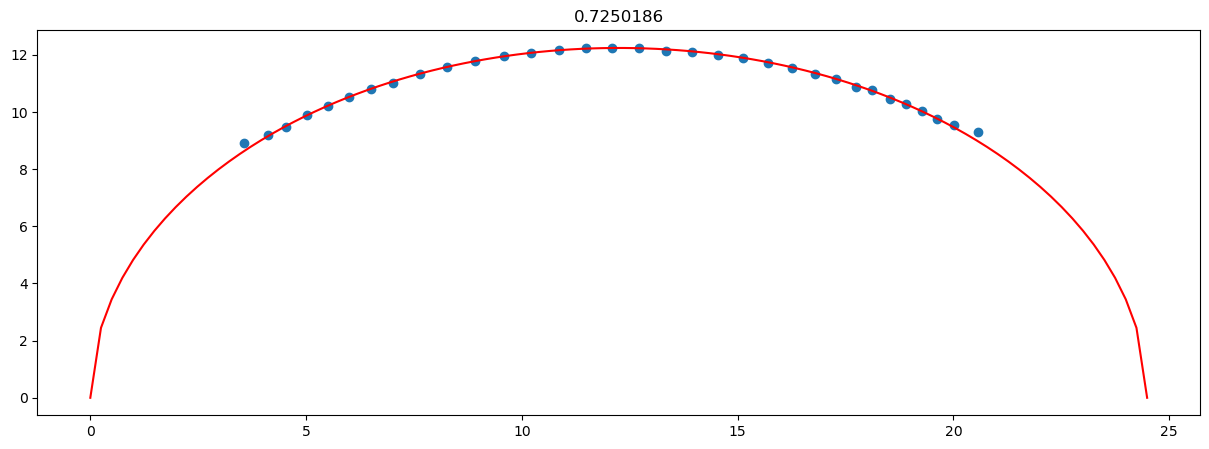

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


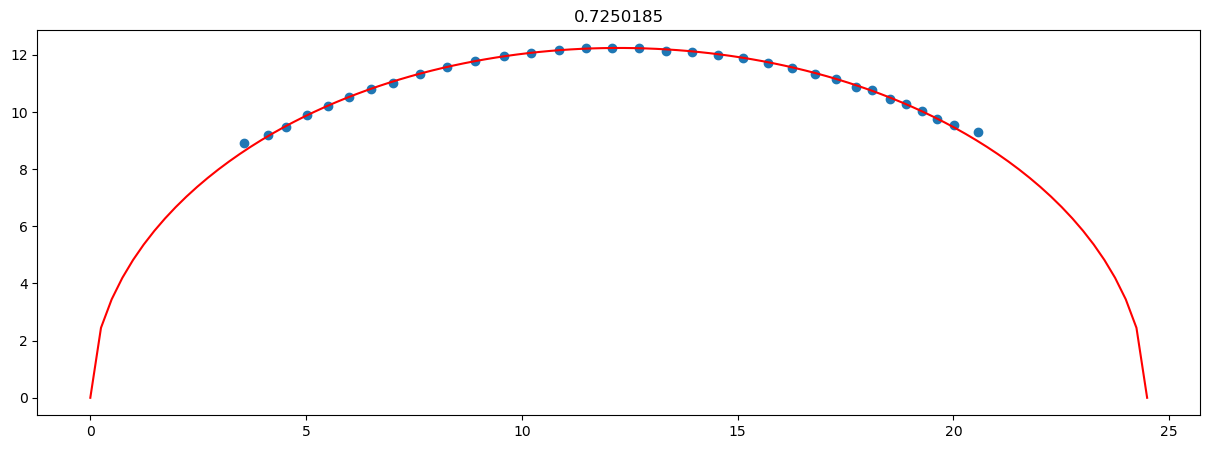

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


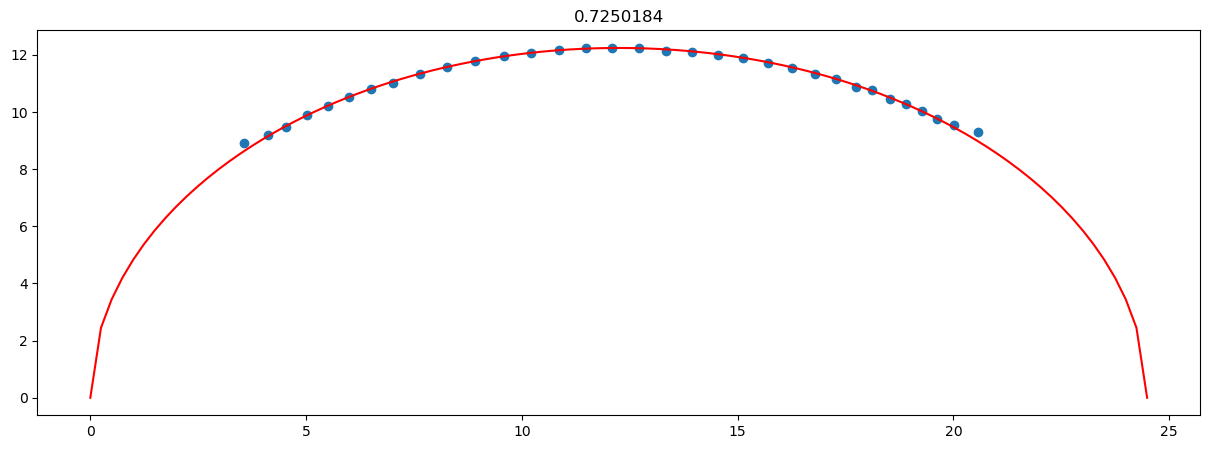

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


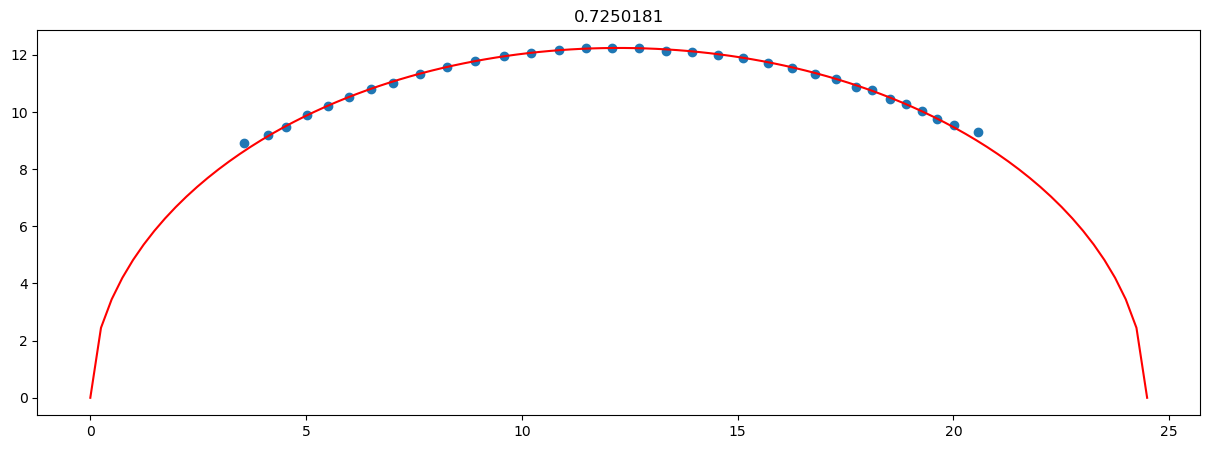

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


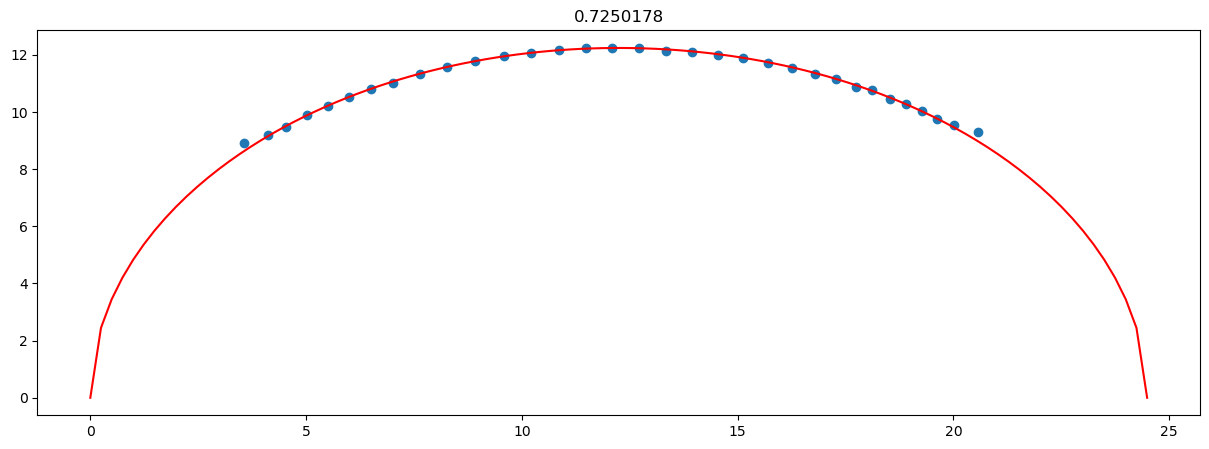

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


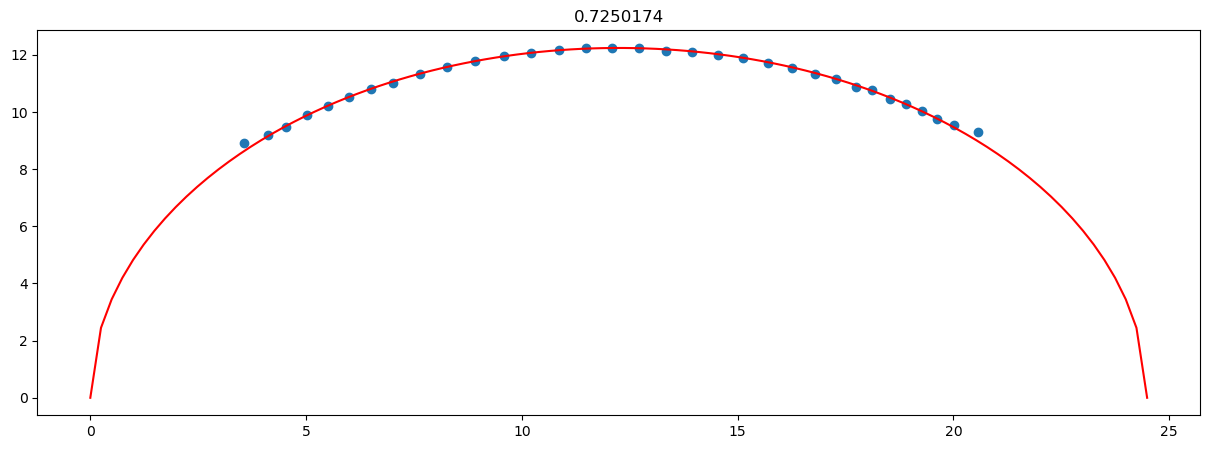

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


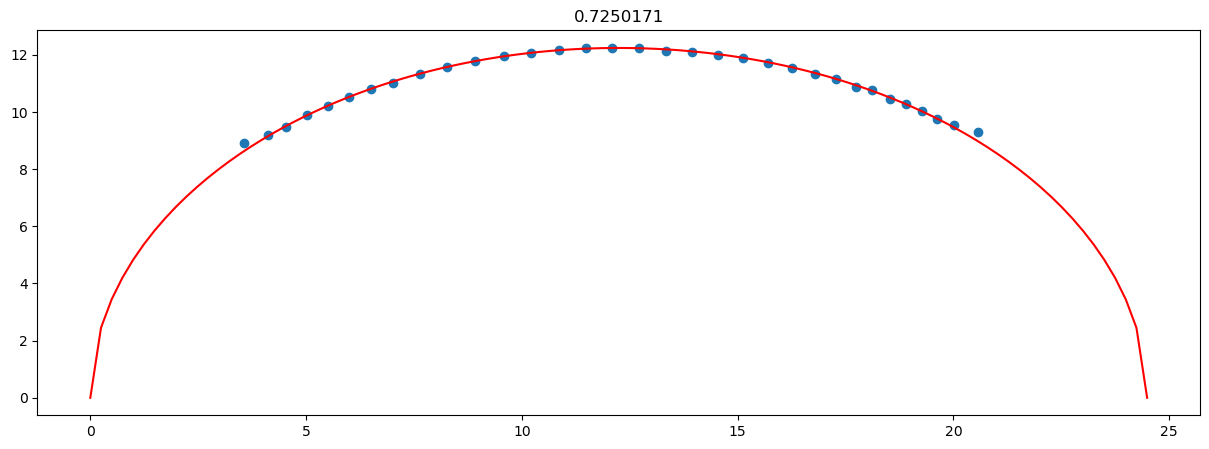

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


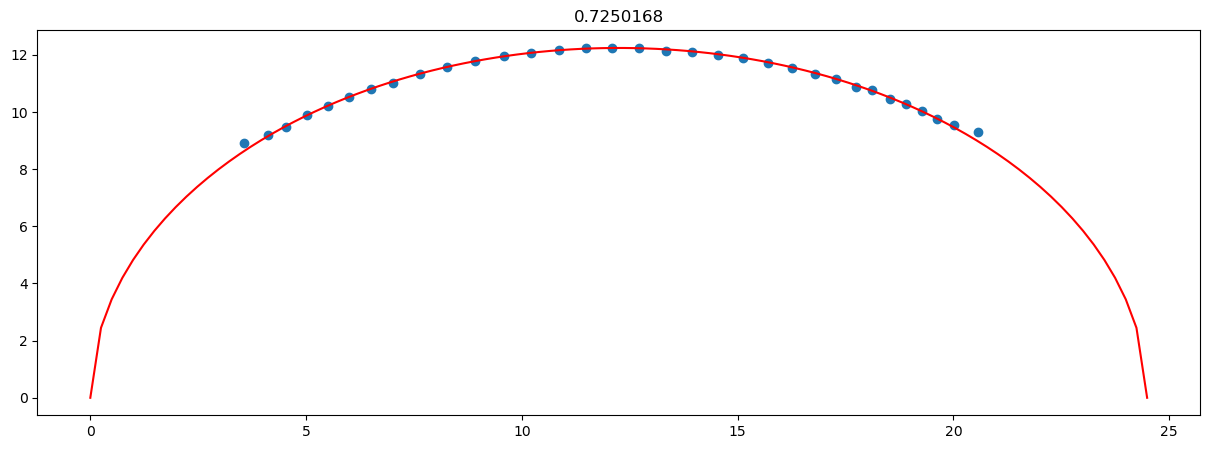

tensor(19.0955, dtype=torch.float64, grad_fn=<AddBackward0>)


In [28]:
radii_list = torch.tensor(radii)
R_ = torch.tensor(R)

N = len(radii)

params = torch.tensor([0.65 for k in range(N)]+[4.], requires_grad=True)

loss_ = []

optimizer = torch.optim.Adam([params], lr=0.02)
for i in range(200):
    optimizer.zero_grad()  # Reset gradients
    z_real, z_app, loss = loss_xi(params[:-1], params[-1], radii_list, R_)
    loss_.append(loss.detach().numpy())
    loss.backward()  # Backpropagation
    optimizer.step()  # Update parameters
    print(loss)
xi = params.detach().numpy()[:-1]

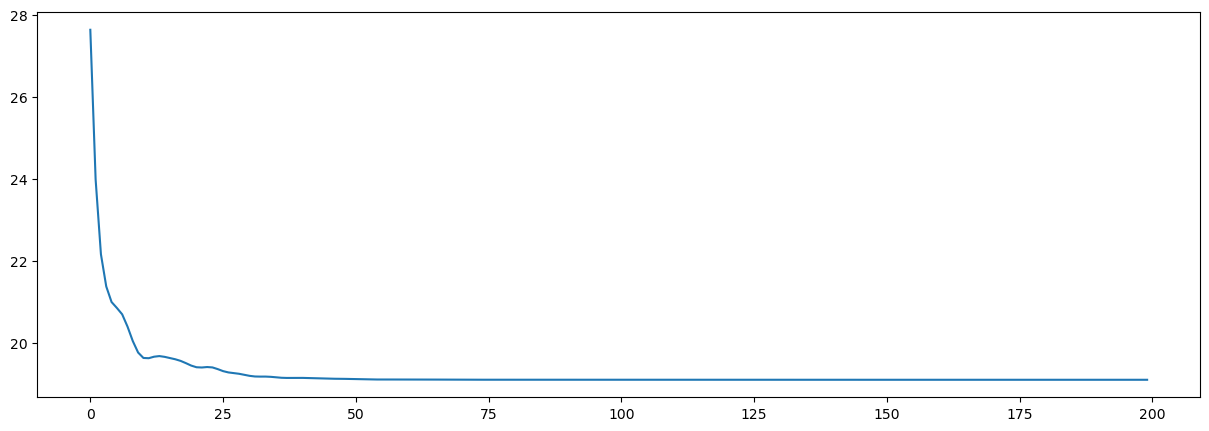

In [29]:
plt.plot(loss_)

tensor(0.8649, grad_fn=<SelectBackward0>)
1.469309875179063


<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
C:\Users\LOCCO_Louise\AppData\Local\Temp\ipykernel_16264\860477463.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(z_real*0.120, xi_univ, label='Loginov et $\mathit{et}$ $\mathit{al.}$')


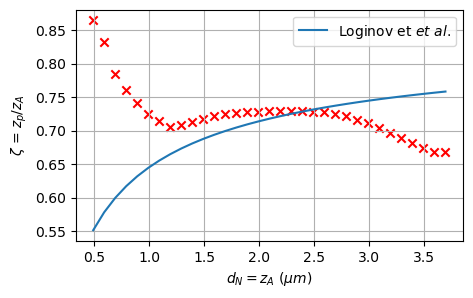

In [30]:
epsilon = -(0.617)/(4*z_real*0.120*n2)
mm = np.sqrt(n1**2-n2**2)
xi_univ = (n2/n1)*(1-epsilon-(mm/n1)*np.sqrt(epsilon*(epsilon-2)))/(1-((n2/n1)**2)*epsilon*(2-epsilon))

plt.rcParams['figure.figsize'] = [5, 3]
plt.scatter(z_real*0.120, xi, c='r', marker='x')
plt.plot(z_real*0.120, xi_univ, label='Loginov et $\mathit{et}$ $\mathit{al.}$')
plt.legend()
plt.xlabel('$d_N = z_A$ ($\\mu m$)')
plt.ylabel('$\\zeta$ = $z_p$/$z_A$')
plt.grid()
print(params[0])
print(R*0.120)

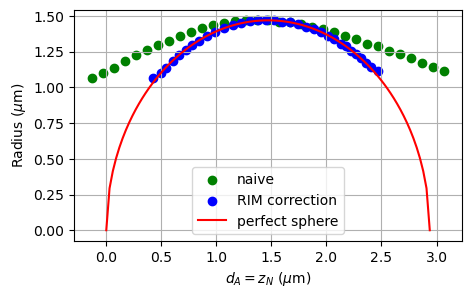

In [31]:
plt.rcParams['figure.figsize'] = [5, 3]
plt.scatter(z_naive*0.12, np.array(radii)*0.12, label='naive', c='g')
plt.scatter(z_app*0.12, np.array(radii)*0.12, label='RIM correction', c='b')
plt.plot(np.linspace(0,2*R,100)*0.12, r__(R,np.linspace(0,2*R,100))*0.12, c='r', label='perfect sphere')
plt.legend()
plt.xlabel('$d_A = z_N$ ($\\mu$m)')
plt.ylabel('Radius ($\\mu$m)')
plt.grid()

## Finding the position of the image planes

In [32]:
path_3_planes_WF = 'Z:\\DATA\\PolMFM_SilicaBeads_SLB_NR\\widefield\\001_WF_560nm\AVG_image_Pos0_reco\\AVG_AVG_image_Pos0_1.tif'

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\LOCCO_Louise\AppData\Local\Temp\ipykernel_16264\1997583172.py:1: SyntaxWarning: invalid escape sequence '\A'
  path_3_planes_WF = 'Z:\\DATA\\PolMFM_SilicaBeads_SLB_NR\\widefield\\001_WF_560nm\AVG_image_Pos0_reco\\AVG_AVG_image_Pos0_1.tif'


In [33]:
FP = []
with Image.open(path_3_planes_WF) as img:
    for i in range(img.n_frames):
        img.seek(i)
        FP.append(np.array(img))
FP = np.array(FP)

In [34]:
box_FP = [[38,71],[94,130]]
#box_FP = [[85,125],[90,132]]

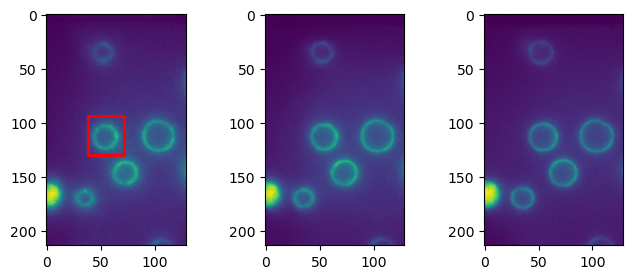

In [35]:
plt.rcParams['figure.figsize'] = [8, 3]
fig, ax = plt.subplots(1,3)
rect = patches.Rectangle((box_FP[0][0], box_FP[1][0]), box_FP[0][1]-box_FP[0][0], box_FP[1][1]-box_FP[1][0], linewidth=2, edgecolor='r', facecolor='none')
ax[0].imshow(FP[0])
ax[1].imshow(FP[1])
ax[2].imshow(FP[2])
ax[0].add_patch(rect)

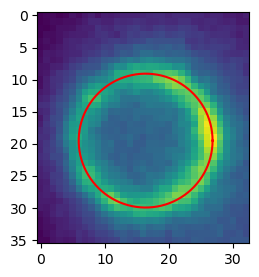

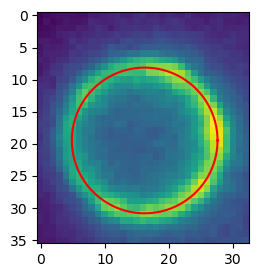

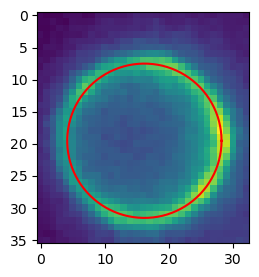

In [36]:
FPradii = []
for index in range(FP.shape[0]):
    frame = FP[index,box_FP[1][0]:box_FP[1][1],box_FP[0][0]:box_FP[0][1]]
    parameters = find_params(frame)
    plt.imshow(FP[index,box_FP[1][0]:box_FP[1][1],box_FP[0][0]:box_FP[0][1]])
    xx = parameters[0] + parameters[2]*np.cos(np.linspace(0,2*np.pi,100))
    yy = parameters[1] + parameters[2]*np.sin(np.linspace(0,2*np.pi,100))
    plt.plot(xx, yy, c='r')
    plt.show()
    FPradii.append(copy.deepcopy(parameters[2]))

In [37]:
R

np.float64(12.244248959825525)

In [38]:
np.array(FPradii)

array([10.430852, 11.35309 , 12.024671], dtype=float32)

tensor(0.8649, grad_fn=<SelectBackward0>)


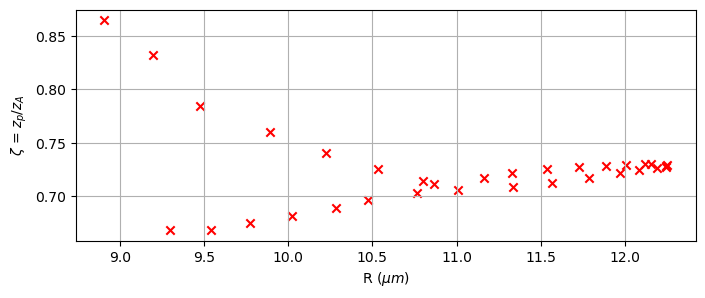

In [39]:
plt.scatter(radii, xi, c='r', marker='x')
plt.xlabel('R ($\\mu m$)')
plt.ylabel('$\\zeta$ = $z_p$/$z_A$')
plt.grid()
print(params[0])

### the radius gives the apparent focal plane but we need to know the real one too

In [40]:
FPradii

[np.float32(10.430852), np.float32(11.35309), np.float32(12.024671)]

In [41]:
epsilon = -(0.617)/(4*z__(R, np.array(FPradii))*0.120*n2)
mm = np.sqrt(n1**2-n2**2)
xi_ideal = (n2/n1)*(1-epsilon-(mm/n1)*np.sqrt(epsilon*(epsilon-2)))/(1-((n2/n1)**2)*epsilon*(2-epsilon))
d = z__(R, np.array(FPradii))*0.120#xi_ideal

In [42]:
d

array([0.69982108, 0.91902151, 1.19229603])

In [43]:
d_app = z__(R, np.array(FPradii))*0.120

In [44]:
d_app

array([0.69982108, 0.91902151, 1.19229603])

# Data

In [45]:
path_data = 'Z:\\DATA\\PolMFM_SilicaBeads_SLB_NR\\2024-01-11_SilicaBeads_Lipids_NR\\001_SM_560nm_EM250_25ms\\SilicaBead\\images\\RAW_DATA\\image_Pos0_2_reco\\image_Pos0_2_0001.tif'
path_info = 'Z:\\DATA\\PolMFM_SilicaBeads_SLB_NR\\image_Pos0_2.ome_results_fr1to8095_method=Propagation matrix_box-method=Fixed_invertRotationPolarizer_corr.csv'

In [46]:
raw = extract_raw(path_data)

In [47]:
data = pos_from_csv(path_info)

In [48]:
data.shape

(51809, 16)

In [49]:
raw.shape

(6, 214, 129)

In [50]:
QE = 0.92
EM = 250
sensitivity = 15.4

In [51]:
np.mean(raw)

np.float64(165.43668646912508)

In [52]:
raw = raw*sensitivity/(QE*EM)

In [53]:
np.mean(raw)

np.float64(11.077065094019682)

(0.0, 2000.0)

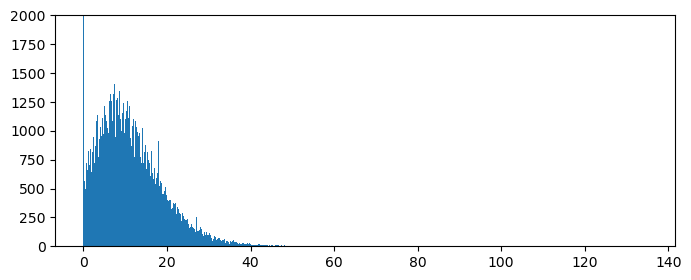

In [54]:
plt.hist(raw.flatten(), bins=1000)
plt.ylim((0,2000))

# Finding noise distribution

In [55]:
def distrib_approx(data):
    NN = len(data)
    histo = plt.hist(data, bins=int(NN/2000))
    dhisto = histo[1][1]-histo[1][0]
    x = histo[1]+dhisto/2
    y = histo[0]
    y = y/np.sum(y)
    return x[:-1], y/dhisto

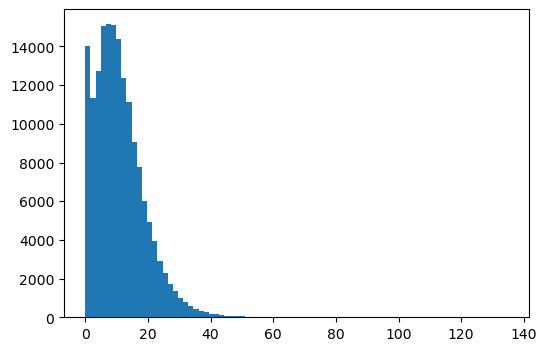

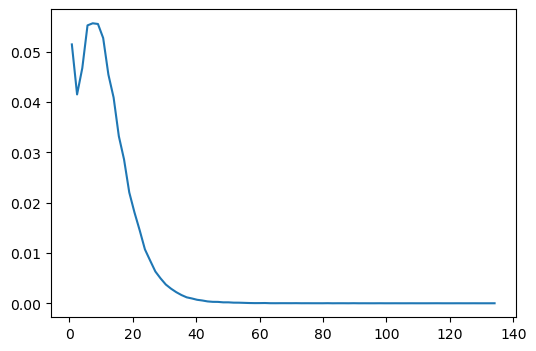

In [56]:
plt.rcParams['figure.figsize'] = [6,4]    
abscisse, distrib_exp = distrib_approx(raw.flatten())
plt.show()
plt.plot(abscisse, distrib_exp)


In [57]:
abscisse[np.argmin(distrib_exp[abscisse<15])]

np.float64(13.98533934252386)

In [58]:
absc = torch.tensor(abscisse)

In [59]:
def noise_analytical(value, b1, s1, b2, s2):
    num_points=2000
    t = torch.linspace(0, 1, num_points).unsqueeze(0)  # shape: (1, 100)
    cst = torch.tensor([1. for fgh in range(num_points)])
    
    r_range = (value.unsqueeze(1) * t)
    l_range = (5*value.unsqueeze(1) * t)
    dr_range = ((value/num_points).unsqueeze(1) * cst)
    dl_range = ((5*value/num_points).unsqueeze(1) * cst)
    
    rr = r_range.unsqueeze(2).expand(-1, num_points, num_points)
    ll = l_range.unsqueeze(1).expand(-1, num_points, num_points)
    dr = dr_range.unsqueeze(2).expand(-1, num_points, num_points)
    dl = dl_range.unsqueeze(1).expand(-1, num_points, num_points)    

    return (1/(2*torch.pi*s1*s2))*torch.sum(((ll**(value.view(-1, 1, 1)-rr))/(torch.exp(torch.lgamma(1+value.view(-1, 1, 1)-rr))))*dr*dl*torch.exp(-ll -0.5*((ll-b1)/s1)**2 -0.5*((rr-b2)/s2)**2), dim=(1,2))

def noiseMC(b1, s1, b2, s2, num_samples=100000):
    # Background Gaussian noise as Poisson rate
    bac = torch.distributions.Normal(b1, s1)
    rate_samples = bac.sample((num_samples,))
    
    # Clamp to non-negative to ensure valid Poisson rates
    rate_samples = torch.clamp(rate_samples, min=0)

    # Sample Poisson based on those rates
    poiss = torch.distributions.Poisson(rate_samples)
    poisson_samples = poiss.sample()

    # Read noise
    read = torch.distributions.Normal(b2, s2)
    read_samples = read.sample((num_samples,))

    # Total observed noise
    return poisson_samples + read_samples

def clamp(x, y, lim):
    arg_lim = torch.argmin((x-lim)**2)
    sum_to_add = torch.sum(y[:arg_lim])
    x = x.clone()[arg_lim:]-x[arg_lim]+(-x[arg_lim]+x[arg_lim+1])/2
    y = y.clone()[arg_lim:]
    y[0]+=sum_to_add
    return x, y

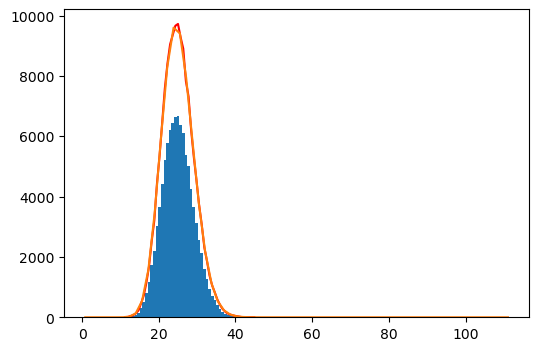

In [60]:
mc = noiseMC(15., 1., 10., 1.)
res = noise_analytical(absc, 15., 1., 10., 1.)

plt.rcParams['figure.figsize'] = [6,4]            
xmc, ymc = distrib_approx(mc.detach().numpy())
plt.plot(xmc, ymc*100000, c='r')
plt.plot(absc.detach().numpy(), (res).detach().numpy()*100000)

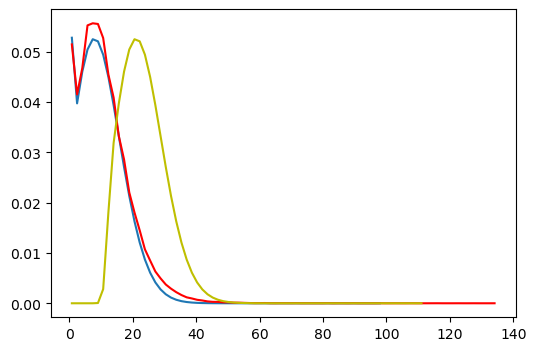

In [61]:
res = noise_analytical(absc, 10.5, 6.8, 11.9, 1.)
xxx, yyy = clamp(absc, res, 14.)

plt.rcParams['figure.figsize'] = [6,4]
#uu = plt.hist(raw.flatten()*sensitivity/(QE*EM), bins=70)
#uu_t = torch.histc(yy, bins=len(absc), min=absc[0].item(), max=absc[-1].item())
plt.plot(xxx, yyy)
plt.plot(abscisse, distrib_exp, c='r')
plt.plot(absc, res, c='y')

# Transform data

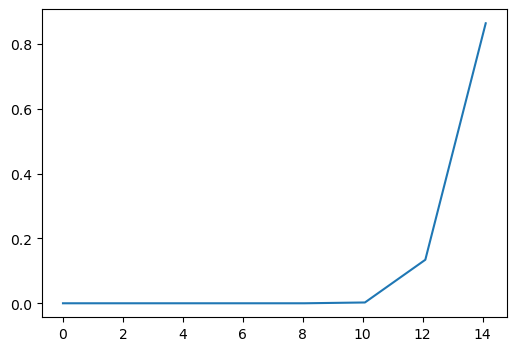

In [62]:
# cf end of the notebook
raw = raw+14
pdf = res[:torch.argmin((absc-14.1)**2)].detach().numpy()
pdf=pdf/np.sum(pdf)
plt.plot(np.linspace(0,14.1,len(pdf)), pdf)
plt.show()
for iii in range(raw.shape[0]):
    for jjj in range(raw.shape[1]):
        for kkk in range(raw.shape[2]):
            if raw[iii,jjj,kkk]==14.:
                raw[iii,jjj,kkk] = np.random.choice(np.linspace(0,14.1,len(pdf)), p=pdf)

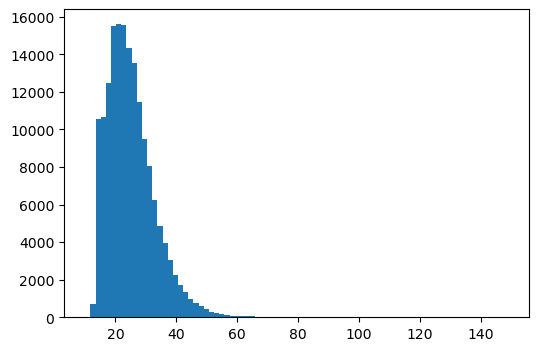

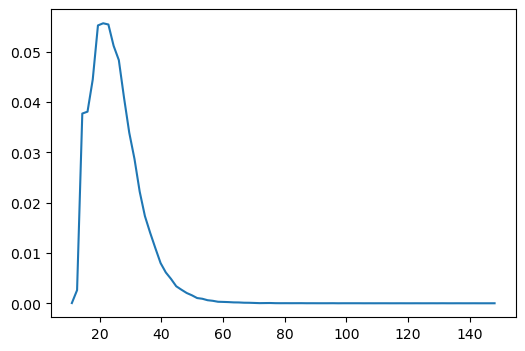

In [63]:
plt.rcParams['figure.figsize'] = [6,4]    
abscisse, distrib_exp = distrib_approx(raw.flatten())
plt.show()
plt.plot(abscisse, distrib_exp)

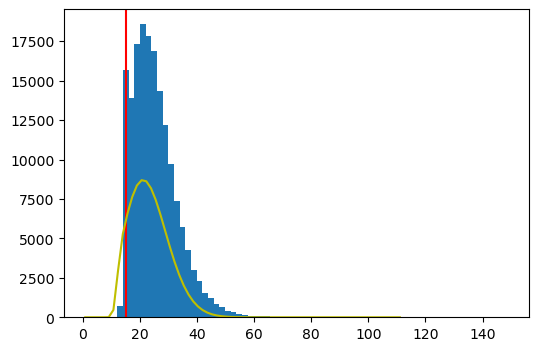

In [64]:
zzz = plt.hist(raw.flatten(), bins=70)
plt.axvline(15.1, c='r')
plt.plot(absc, res*len(raw.flatten()), c='y')

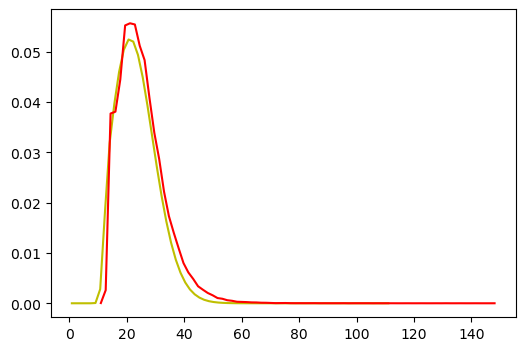

In [65]:
plt.plot(absc, res, c='y')
plt.plot(abscisse, distrib_exp, c='r')

# SGD

In [ ]:
x, y, z, rho, delta = position_from_data(data, 1)
rho[np.isnan(rho)]=90.
delta[np.isnan(delta)]=100.
plot_raw_xy(raw, x, y,  number=2)
print(z)
NPSF = len(x)

In [ ]:
single_psf = extract_raw_xy(raw, x, y)

In [ ]:
def gauss(coords, A, mu1, mu2, s, c):
    x, y = coords
    return A*(1/(2*np.pi*(s**2)))*np.exp(-0.5*(((x-mu1)**2+(y-mu2)**2)/((s**2)))) + c

In [ ]:
def fit_psf_in_pixel(data_raw):
    uuuu, vvvv = np.meshgrid(np.arange(data_raw.shape[0]),np.arange((data_raw.shape[0])))
    xdata = np.vstack((uuuu.ravel(), vvvv.ravel()))
    zdata = data_raw.ravel()
    p, pcov = curve_fit(gauss, xdata, zdata, p0=(1000, 6, 6, 1, 30))
    return p, gauss((uuuu, vvvv), p[0], p[1], p[2], p[3], p[4])

In [ ]:
n=2
fig, ax = plt.subplots(1,2)
p, sim = fit_psf_in_pixel(single_psf[n,0,0]+single_psf[n,0,1])
vmax2 = np.max(sim)
vmax = np.max(single_psf[n,0,0]+single_psf[n,0,1])
me = ax[0].imshow(single_psf[n,0,0]+single_psf[n,0,1], vmin=0, vmax=vmax)
cb = plt.colorbar(me, pad=0.15, label='Photon number')
mesh2 = ax[1].imshow(sim, vmin=0, vmax=vmax2)
cb = plt.colorbar(mesh2, pad=0.15, label='Photon number')

In [ ]:
n = 0
vmin = 0.
vmax = np.max(single_psf[n])
fig, ax = plt.subplots(2,3)
for i in range(2):
    for j in range(3):
        ax[i,j].set_aspect('equal')
        im = ax[i,j].pcolormesh(single_psf[n,j,i], cmap='grey', vmin=vmin, vmax=vmax)
        ax[i,j].set_title(str(np.sum(single_psf[n,j,i])))
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.8)
print(z[n], x[n], y[n], rho[n], delta[n])

In [ ]:
NN = []
for plan in [0,1,2]:
    p, sim = fit_psf_in_pixel(single_psf[n,plan,0]+single_psf[n,plan,1])
    NN.append(p[0])

## starting point

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU")
else:   
    device = torch.device('cpu')
    print("Using CPU")

In [ ]:
d_app

In [ ]:
single_psf.shape

In [ ]:
x_start = torch.tensor([0. for k in range(len(x))], requires_grad=False, device=device)
y_start = torch.tensor([0. for k in range(len(x))], requires_grad=False, device=device)
'''index = []
for k in range(len(x)):
    index.append(np.argmax(np.array([np.max(single_psf[k,ju]) for ju in range(3)])))'''
z_exp =  torch.tensor([(d_app[1]+z[k]*0.001)*1. for k in range(len(x))], requires_grad=False, device=device)
# torch.tensor([1.4775266*0.65 for k in range(len(x))], requires_grad=False, device=device)

rho_exp = torch.tensor((rho+60.)%180., requires_grad=False, device=device)
delta_exp = torch.tensor(delta, requires_grad=False, device=device)

d_ = -torch.tensor([d[1] for k in range(len(x))], requires_grad=False, device=device)
second_plane = [d[1]-d[2], d[1]-d[0]]
print(second_plane)

In [ ]:
N=torch.tensor(80, device=device)
l_pixel=torch.tensor(16, device=device)
NA=torch.tensor(1.4, device=device)
mag=torch.tensor(100, device=device)
lambd=torch.tensor(638, device=device)
f_tube=torch.tensor(200, device=device)
MAG=torch.tensor(200/150, device=device)

In [ ]:
xx, yy, th1, phi, [Ex0, Ex1, Ex2], [Ey0, Ey1, Ey2], r, r_cut, k_, f_o = vectorial_BFP_perfect_focus(N, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, device=device)

# Gradient Descent

In [ ]:
noisy_psf = torch.tensor([single_psf[k] for k in range(len(x))], device=device)

In [ ]:
noisy_psf.shape

In [ ]:
def limit(x, lim, slope, upper=True):
    '''
    if upper:
       return torch.sum(torch.tensor(1/(1+torch.exp(-slope*(x-lim))), requires_grad=True, device=device))
    else:
        return torch.sum(torch.tensor(1/(1+torch.exp(slope*(x-lim))), requires_grad=True, device=device))
    '''
    if upper:
        return torch.sum(torch.exp((x-lim)*slope))
    else:
        return torch.sum(torch.exp(-1*(x-lim)*slope))
        

def loss_N(xp, yp, zp, rho, eta, delta, N_photons, data, second_plane, background, sigma, dim_simu=122):
    u, v, M_ = compute_M(xp=xp, yp=yp, zp=zp, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, second_plane=second_plane, N=N,
                    l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device)
    dim_data = 6
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]
    #plt.imshow(h.detach().numpy()[0,0,0])
    #plt.show()
    #print(torch.max(h), torch.max(data))
    loss = torch.sum(torch.pow(torch.sum(torch.add(h, -data-background[:,None,None,None,None]), dim=(2,)), 2))
    return loss 

In [ ]:
def loss_pos(xp, yp, zp, rho, eta, delta, N_photons, data, second_plane, background, sigma, dim_simu=122):
    u, v, M_ = compute_M(xp=xp, yp=yp, zp=zp, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, second_plane=second_plane, N=N,
                    l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device)
    dim_data = 6
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]
    #plt.imshow(h.detach().numpy()[0,0,0])
    #plt.show()
    #loss = torch.sum(torch.add(h, -(data+sigma[:,None,None,None,None]**2))*torch.log(h+background[:,None,None,None,None]+sigma[:,None,None,None,None]**2))
    loss = torch.sum(torch.pow(torch.sum(torch.add(h, -data), dim=(2,)), 2)) #+background[:,None,None,None,None]
    x_bound = limit(xp, 5*0.12, 100, upper=True) + limit(xp, -5*0.12, 100, upper=False)
    y_bound = limit(yp, 5*0.12, 100, upper=True) + limit(yp, -5*0.12, 100, upper=False)
    z_bound = limit(xp, 5., 100, upper=True) + limit(zp, 0, 100, upper=False)
    return loss +x_bound+y_bound+z_bound

In [ ]:
def loss_angle(M_, rho, eta, delta, N_photons, data, background, sigma, dim_simu=122):
    dim_data = 6
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]
    loss = torch.sum(torch.add(h, -(data+sigma[:,None,None,None,None]**2)*torch.log(h+background[:,None,None,None,None]+sigma[:,None,None,None,None]**2)))
    rho_bound = limit(rho, 180, 100, upper=True) + limit(rho, 0, 100, upper=False)
    delta_bound = limit(delta, 180, 100, upper=True) + limit(delta, 1, 100, upper=False)
    eta_bound = limit(eta, 180, 100, upper=True) + limit(eta, 0, 100, upper=False)
    #rho_bound = torch.sum(((rho-rho_guess)/thresh_rho)**2)
    #delta_bound = torch.sum(((delta-delta_guess)/thresh_delta)**2)
    #N_photons_bound = limit(N_photons, 5000, 0.1, upper=True) + limit(N_photons, 0, 100, upper=False)
    #return loss + lambd*(rho_bound + delta_bound) + 1000.*(eta_bound) #+ 0.1*torch.sum(h.pow(2))
    return loss + 1000.*(rho_bound + delta_bound + eta_bound) #+ 0.1*torch.sum(h.pow(2))

In [ ]:
#sigma = torch.std(torch.flatten(noisy_psf, start_dim=1), dim=1)
#background = torch.mean(torch.flatten(noisy_psf, start_dim=1), dim=1)
sigma = []
background = []
Nstart = []
for k in range(NPSF):
    cc=0
    nb = []
    x__x = []
    y__y = []
    peak = []
    for plan in [0,1,2]:
        p, sim = fit_psf_in_pixel(single_psf[k,plan,0]+single_psf[k,plan,1])
        peak.append(np.max(single_psf[k,plan,0]+single_psf[k,plan,1]))
        nb.append(p[0])
        cc+=p[4]
        x__x.append(p[1])
        y__y.append(p[2])
    cc/=3
    background.append(cc)
    print(nb)
    Nstart.append(3*nb[np.argmax(np.array(peak))])
    sigma.append(np.sqrt(6**2+2**2))
    x_start[k] = (x__x[np.argmax(np.array(peak))]-6.5)*0.120
    y_start[k] = (y__y[np.argmax(np.array(peak))]-6.5)*0.120
background = torch.tensor(background, device=device)
sigma = torch.tensor(sigma, device=device)
print(background, sigma, Nstart, x_start)

In [ ]:
u, v, M = compute_M(xp=x_start, yp=y_start, zp=z_exp, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, second_plane=second_plane, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device)

In [ ]:
h = PSF(rho=torch.tensor([45. for k in range(NPSF)], device=device), eta=torch.tensor([45. for k in range(NPSF)], device=device), delta=torch.tensor([100. for k in range(NPSF)], device=device), M=M, N_photons=torch.tensor([1000. for k in range(NPSF)], device=device))

In [ ]:
h.shape

In [ ]:
Nstart = torch.tensor(Nstart, requires_grad=False, device=device)
#-background[k]*12*12*NPSF
print(Nstart)
eta_rd = torch.tensor([45. for k in range(NPSF)], requires_grad=False, device=device)
delta_rd = torch.tensor([150. for k in range(NPSF)], requires_grad=False, device=device)

params = torch.cat((x_start, y_start, z_exp, Nstart/10000))
params.requires_grad=True

params_prev = params.clone().detach() - torch.tensor([2. for k in range(len(params))], device=device)

# Use Stochastic Gradient Descent (SGD) to optimize params
optimizer = torch.optim.Adam([params], lr=0.2)  # Learning rate = 0.012

num_epochs_max = 40
loss_ = []
x_ = []
y_ = []
z_ = []
N_ = []
tour=0

while ((torch.add(params, -params_prev)[0:NPSF]>.00001).any() or
       (torch.add(params, -params_prev)[NPSF:2*NPSF]>.00001).any() or
       (torch.add(params, -params_prev)[2*NPSF:3*NPSF]>.00001).any() or
       (torch.add(params, -params_prev)[3*NPSF:4*NPSF]>.0001).any() 
       ) and tour<num_epochs_max:
       
    params_prev = params.clone().detach()
    optimizer.zero_grad()  # Reset gradients
    #print(params[0:3], params[3:6], params[6:])
    loss = loss_pos(params[0:NPSF], params[NPSF:2*NPSF], params[2*NPSF:3*NPSF], rho_exp
                        , eta_rd, delta_exp, 10000*params[3*NPSF:4*NPSF], noisy_psf, second_plane, background, sigma) 
    loss_.append(loss.cpu().detach().numpy())
    x_.append(params[0:NPSF].cpu().clone().detach().numpy())
    y_.append(params[NPSF:2*NPSF].cpu().clone().detach().numpy())
    z_.append(params[2*NPSF:3*NPSF].cpu().clone().detach().numpy())
    N_.append(10000*params[3*NPSF:4*NPSF].cpu().clone().detach().numpy())
    loss.backward()  # Backpropagation
    optimizer.step()  # Update parameters
    tour+=1


    x_found = params[0:NPSF].clone().detach()
    y_found = params[NPSF:2*NPSF].clone().detach()
    z_found = params[2*NPSF:3*NPSF].clone().detach()
    N_found = 10000*params[3*NPSF:4*NPSF].clone().detach()

In [ ]:
plt.rcParams['figure.figsize'] = [14,7]
fig, ax = plt.subplots(2,2)
ax[0,0].plot(x_)
ax[0,1].plot(np.array(y_)[:,:])
ax[1,0].plot(np.array(z_)[:,:])
ax[1,1].plot(N_)

In [ ]:
n = 2
vmin = 0.
vmax = np.max(single_psf[n,:,0]+single_psf[n,:,1])
x_x = np.linspace(-single_psf.shape[-1]/2, single_psf.shape[-1]/2, int(single_psf.shape[-1]))*0.120
xxx, yyy = np.meshgrid(x_x, x_x)
plt.rcParams['figure.figsize'] = [15,9]
fig, ax = plt.subplots(1,3)

for j in range(3):
    ax[j].set_aspect('equal', adjustable='box')
    im = ax[j].pcolormesh(xxx, yyy, single_psf[n,j,0]+single_psf[n,j,1], cmap='grey', vmin=vmin, vmax=vmax)
    ax[j].scatter(x_found[n], y_found[n], c='yellow', s=100, marker='+')
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.4)
print(z[n])
print(z_found[n], z_found[n]+d_[1])
plt.show()
#################################################
plt.rcParams['figure.figsize'] = [15,9]
fig2, ax2 = plt.subplots(1,3)
u, v, M_ = compute_M(xp=x_found, yp=y_found, zp=z_found, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, second_plane=second_plane, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device)
dim_simu=122
dim_data = 6
print('nstart ', Nstart[n])
psf_th = PSF(rho=rho_exp, eta=eta_rd, delta=delta_exp, M=M_, N_photons=Nstart)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1].detach().numpy()
print(np.max(psf_th[n]), np.sum(psf_th[n]))
print(Nstart)
b, sig_background, sigma_read, bias = 12., 6., 2., 12.
psf_th = noise(psf_th, QE=1, EM=1, b=b, sigma_b=sig_background, sigma_r=sigma_read, bias=bias)
vmax2 = np.max(psf_th[n,:,0]+psf_th[n,:,1])

for j in range(3):
    ax2[j].set_aspect('equal', adjustable='box')
    im2 = ax2[j].pcolormesh(xxx, yyy, psf_th[n,j,0]+psf_th[n,j,1], cmap='grey', vmin=vmin, vmax=vmax) #
    ax2[j].scatter(x_found[n], y_found[n], c='yellow', s=100, marker='+')
fig2.colorbar(im2, ax=ax2.ravel().tolist(), shrink=0.4)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [5,4]
plan = 0
plt.plot(single_psf[n,plan,0,6]+single_psf[n,plan,1,6])
plt.plot(psf_th[n,plan,0,6]+psf_th[n,plan,1,6])
plt.show()
plt.plot(single_psf[n,plan,0,7]+single_psf[n,plan,1,7])
plt.plot(psf_th[n,plan,0,7]+psf_th[n,plan,1,7])

### angle

In [ ]:
u, v, M = compute_M(xp=x_found, yp=y_found, zp=z_found, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, second_plane=second_plane, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device)

In [ ]:
eta_rd = torch.tensor([90. for k in range(NPSF)], requires_grad=False, device=device)

params = torch.cat((rho_exp, delta_exp))
params.requires_grad=True

params_prev = params.clone().detach() - torch.tensor([2. for k in range(len(params))], device=device)

# Use Stochastic Gradient Descent (SGD) to optimize params
optimizer = torch.optim.Adam([params], lr=0.3)  # Learning rate = 0.01

num_epochs_max = 500
loss_ = []
rho_ = []
delta_ = []

tour=0

while ((torch.add(params, -params_prev)[0:NPSF]>.0001).any() or
       (torch.add(params, -params_prev)[NPSF:2*NPSF]>.0001).any() 
       ) and tour<num_epochs_max:
       
    params_prev = params.clone().detach()
    optimizer.zero_grad()  # Reset gradients
    #print(params[0:3], params[3:6], params[6:])
    loss = loss_angle(M.detach(), params[:NPSF], eta_rd, params[NPSF:2*NPSF], N_found, noisy_psf, background, sigma)
    loss_.append(loss.cpu().detach().numpy())
    rho_.append(params[0:NPSF].cpu().clone().detach().numpy())
    delta_.append(params[1*NPSF:2*NPSF].cpu().clone().detach().numpy())
    loss.backward()  # Backpropagation
    optimizer.step()  # Update parameters
    tour+=1

In [ ]:
plt.rcParams['figure.figsize'] = [10,3]
fig, ax = plt.subplots(1, 2)
ax[0].plot(rho_)
ax[1].plot(delta_)
plt.show()
plt.plot(loss_)

In [ ]:
eta_rd = torch.tensor([90. for k in range(NPSF)], requires_grad=False, device=device)

params = torch.cat((rho_exp, eta_rd, delta_exp))
params.requires_grad=True

params_prev = params.clone().detach() - torch.tensor([2. for k in range(len(params))], device=device)

# Use Stochastic Gradient Descent (SGD) to optimize params
optimizer = torch.optim.Adam([params], lr=0.3)  # Learning rate = 0.01

num_epochs_max = 500
loss_ = []
rho_ = []
eta_ = []
delta_ = []

tour=0

while ((torch.add(params, -params_prev)[0:NPSF]>.0001).any() or
       (torch.add(params, -params_prev)[NPSF:2*NPSF]>.0001).any() or
       (torch.add(params, -params_prev)[2*NPSF:]>.0001).any()
       ) and tour<num_epochs_max:
       
    params_prev = params.clone().detach()
    optimizer.zero_grad()  # Reset gradients
    #print(params[0:3], params[3:6], params[6:])
    loss = loss_angle(M.detach(), params[:NPSF], params[NPSF:2*NPSF], params[2*NPSF:3*NPSF], Nstart, noisy_psf, background, sigma)
    loss_.append(loss.cpu().detach().numpy())
    rho_.append(params[0:NPSF].cpu().clone().detach().numpy())
    eta_.append(params[NPSF:2*NPSF].cpu().clone().detach().numpy())
    delta_.append(params[2*NPSF:3*NPSF].cpu().clone().detach().numpy())
    loss.backward()  # Backpropagation
    optimizer.step()  # Update parameters
    tour+=1


rho_found = params[0:NPSF].clone().detach()
eta_found = params[NPSF:2*NPSF].clone().detach()
delta_found = params[2*NPSF:3*NPSF].clone().detach()

In [ ]:
plt.rcParams['figure.figsize'] = [10,6]
fig, ax = plt.subplots(2,2)
ax[0,0].plot(rho_)
ax[0,1].plot(eta_)
ax[1,0].plot(delta_)
ax[1,1].plot(loss_)

In [ ]:
n = 3
vmin = 0.
vmax = np.max(single_psf[n])
x_x = np.linspace(-single_psf.shape[-1]/2, single_psf.shape[-1]/2, int(single_psf.shape[-1]))*0.120
xxx, yyy = np.meshgrid(x_x, x_x)
plt.rcParams['figure.figsize'] = [15,9]
fig, ax = plt.subplots(2,3)

for i in range(2):
    for j in range(3):
        ax[i,j].set_aspect('equal', adjustable='box')
        im = ax[i,j].pcolormesh(xxx, yyy, single_psf[n,j,i], cmap='grey', vmin=vmin, vmax=vmax)
        ax[i,j].scatter(x_found[n], y_found[n], c='yellow', s=100, marker='+')
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.8)
print(z[n], x[n], y[n], rho[n], delta[n])
plt.show()
#################################################
plt.rcParams['figure.figsize'] = [15,9]
fig2, ax2 = plt.subplots(2,3)
u, v, M = compute_M(xp=x_found, yp=y_found, zp=z_found, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, second_plane=second_plane, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device)
dim_simu=118
dim_data = 6
psf_th = PSF(rho=rho_found, eta=eta_found, delta=delta_found, M=M, N_photons=Nstart)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1].detach().numpy()
# 
vmax2 = np.max(psf_th[n])
print(np.max(psf_th[n]))
for i in range(2):
    for j in range(3):
        ax2[i,j].set_aspect('equal', adjustable='box')
        im2 = ax2[i,j].pcolormesh(xxx, yyy, psf_th[n,j,i], cmap='grey', vmin=vmin, vmax=vmax2)
        ax2[i,j].scatter(x_found[n], y_found[n], c='yellow', s=100, marker='+')
fig2.colorbar(im2, ax=ax2.ravel().tolist(), shrink=0.8)
plt.show()

In [ ]:
bias = 12.
b = 12.
sigma_read = 2.
sig_background = 6.

In [ ]:
psf_simu_noisy = noise(psf_th, QE=1, EM=1, b=b, sigma_b=sig_background, sigma_r=sigma_read, bias=bias)

In [ ]:
vmin = 0.
vmax = max(np.max(psf_simu_noisy[n]), np.max(single_psf[n]))
x_x = np.linspace(-single_psf.shape[-1]/2, single_psf.shape[-1]/2, int(single_psf.shape[-1]))*0.120
xxx, yyy = np.meshgrid(x_x, x_x)
plt.rcParams['figure.figsize'] = [15,9]
fig, ax = plt.subplots(2,3)

for i in range(2):
    for j in range(3):
        ax[i,j].set_aspect('equal', adjustable='box')
        im = ax[i,j].pcolormesh(xxx, yyy, single_psf[n,j,i], cmap='grey', vmin=vmin, vmax=vmax)
        ax[i,j].scatter(x_found[n], y_found[n], c='yellow', s=100, marker='+')
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.8)
print(z[n], x[n], y[n], rho[n], delta[n])
plt.show()
#################################################
plt.rcParams['figure.figsize'] = [15,9]
fig2, ax2 = plt.subplots(2,3)
u, v, M = compute_M(xp=x_found, yp=y_found, zp=z_found, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, second_plane=second_plane, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device)

for i in range(2):
    for j in range(3):
        ax2[i,j].set_aspect('equal', adjustable='box')
        im2 = ax2[i,j].pcolormesh(xxx, yyy, psf_simu_noisy[n,j,i], cmap='grey', vmin=vmin, vmax=vmax)
        ax2[i,j].scatter(x_found[n], y_found[n], c='yellow', s=100, marker='+')
fig2.colorbar(im2, ax=ax2.ravel().tolist(), shrink=0.8)
plt.show()

# find wollaston alignment

In [ ]:
path = 'Z:\\DATA\\PolMFM_SilicaBeads_SLB_NR\\PolMFM_SilicaBeads_SLB_NR\\Calibration\\Calib-Channels_Fluo-beads-200nm_step-100nm_560nmlaser\\Calib_Polar_2024-01-11_3\\images\\RAW_DATA\\image_Pos0.ome.tif'

In [ ]:
billes = []
with Image.open(path) as img:
    for i in range(img.n_frames):
        img.seek(i)
        billes.append(np.array(img))
billes = np.array(billes)

In [ ]:
proj = np.max(billes, axis=(0,))

In [ ]:
plt.rcParams['figure.figsize'] = [15,9]
plt.imshow(proj)
plt.axvline(267)